In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.8.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 41.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# define  dataset tho

In [2]:
import json
import os
import os.path as osp
from typing import Callable, List, Optional, Union

import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import fs, read_txt_array


class BreakBad(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {
        'Statue_0': '101902_sf',
        'Statue_1': '102068_sf',
        'Statue_2': '103538_sf',
        'Statue_3': '103737_sf',
        'Statue_4': '104442_sf',
        'Statue_5': '108010_sf',
        'Statue_6': '120477_sf',
        'Statue_7': '120628_sf',

    }



    seg_classes = {
        'Statue_0': [0,1],
        'Statue_1': [2,3],
        'Statue_2': [4,5],
        'Statue_3': [6,7],
        'Statue_4': [8,9],
        'Statue_5': [10,11],
        'Statue_6': [12,13],
        'Statue_7': [14,15],
    }

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {
        '101902_sf' : 0,
        '102068_sf' : 1,
        '103538_sf' : 2,
        '103737_sf' : 3,
        '104442_sf' : 4,
        '108010_sf' : 5,
        '120477_sf' : 6,
        '120628_sf' : 7,

        }
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [6]:
import torch.nn.functional as F
from randlanet_classification import DilatedResidualBlock, SharedMLP, decimate


import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, knn_interpolate
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter


In [7]:
!unzip /content/shapenet_withnormal_filtered.zip -d /content/temp_extract
!mkdir /content/data
!mkdir /content/data/raw
!mv /content/temp_extract/shapenet_withnormal_filtered/* /content/data/raw
!rm -r /content/temp_extract

Archive:  /content/shapenet_withnormal_filtered.zip
   creating: /content/temp_extract/shapenet_withnormal_filtered/
   creating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_20.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_22.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_40.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_41.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_46.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_59.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_70.txt  
  inflating: /content/temp_extract/shapenet_withnormal_filtered/101902_sf/piece_0_fractured_72.txt  


In [8]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset = BreakBad(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset = BreakBad(path, category, split='test',
                        pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False,
                         num_workers=2)

['Statue_0', 'Statue_1', 'Statue_2', 'Statue_3', 'Statue_4', 'Statue_5', 'Statue_6', 'Statue_7']


Processing...


['Statue_0', 'Statue_1', 'Statue_2', 'Statue_3', 'Statue_4', 'Statue_5', 'Statue_6', 'Statue_7']


Done!


In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import torch
import random
import numpy as np

gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])

@torch.no_grad()
def visualize_ground_truth_3d(loader, num_samples=4):
    # Load all data samples into a list for random access
    all_data = list(loader)

    sampled_data = random.sample(all_data, min(num_samples, len(all_data)))
    sample_id = 1

    for data in sampled_data:
        data = data.to(device)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)
        ys = data.y.split(sizes)

        for x, y in zip(xs, ys):
            x_np = x.cpu().numpy()
            y_np = y.cpu().numpy()

            # Convert y labels to RGB colors using gt_cmap
            colors = gt_cmap[y_np%2]
            print(f"Unique classes {np.unique(y_np)}")
            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], c=colors, s=5)
            ax.set_title(f'Ground Truth - Sample {sample_id}')
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()

            sample_id += 1
            if sample_id > num_samples:
                return


Unique classes [10 11]


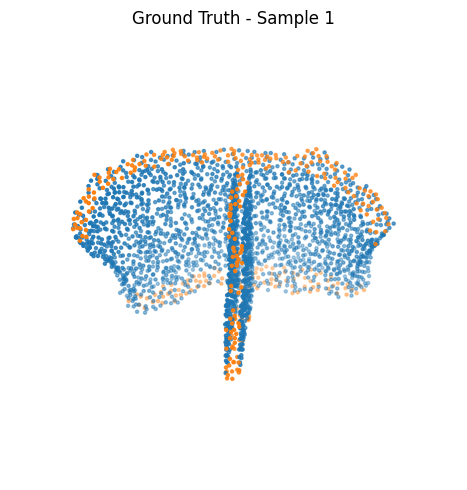

Unique classes [10 11]


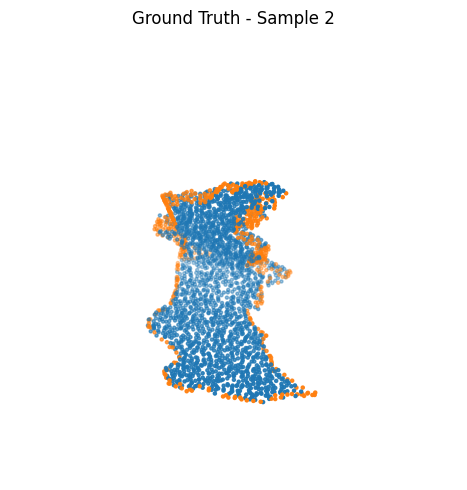

Unique classes [8 9]


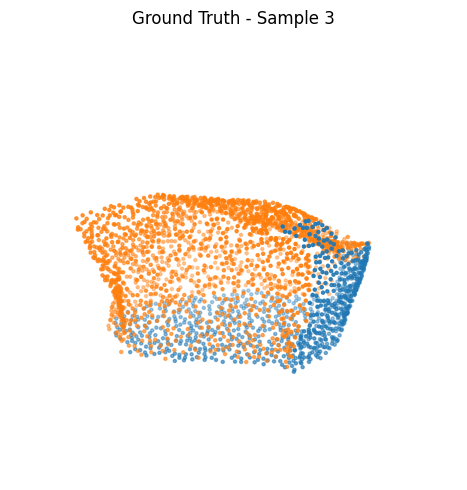

Unique classes [4 5]


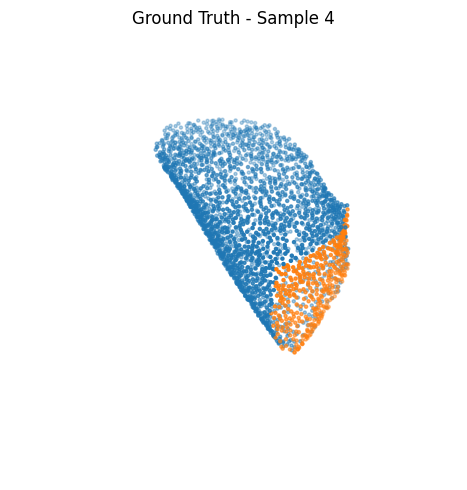

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_ground_truth_3d(test_loader, num_samples=4)

# RanlaNet

In [11]:
from torch.nn import Linear
class FPModule(torch.nn.Module):
    """Upsampling with a skip connection."""
    def __init__(self, k, nn):
        super().__init__()
        self.k = k
        self.nn = nn

    def forward(self, x, pos, batch, x_skip, pos_skip, batch_skip):
        x = knn_interpolate(x, pos, pos_skip, batch, batch_skip, k=self.k)
        x = torch.cat([x, x_skip], dim=1)
        x = self.nn(x)
        return x, pos_skip, batch_skip


class Net(torch.nn.Module):
    def __init__(
        self,
        num_features: int,
        num_classes: int,
        decimation: int = 4,
        num_neighbors: int = 16,
        return_logits: bool = False,
    ):
        super().__init__()

        self.decimation = decimation
        # An option to return logits instead of log probabilities:
        self.return_logits = return_logits

        # Authors use 8, which is a bottleneck
        # for the final MLP, and also when num_classes>8
        # or num_features>8.
        d_bottleneck = max(32, num_classes, num_features)

        self.fc0 = Linear(num_features, d_bottleneck)
        self.block1 = DilatedResidualBlock(num_neighbors, d_bottleneck, 32)
        self.block2 = DilatedResidualBlock(num_neighbors, 32, 128)
        self.block3 = DilatedResidualBlock(num_neighbors, 128, 256)
        self.block4 = DilatedResidualBlock(num_neighbors, 256, 512)
        self.mlp_summit = SharedMLP([512, 512])
        self.fp4 = FPModule(1, SharedMLP([512 + 256, 256]))
        self.fp3 = FPModule(1, SharedMLP([256 + 128, 128]))
        self.fp2 = FPModule(1, SharedMLP([128 + 32, 32]))
        self.fp1 = FPModule(1, SharedMLP([32 + 32, d_bottleneck]))
        self.mlp_classif = SharedMLP([d_bottleneck, 64, 32],
                                     dropout=[0.0, 0.5])
        self.fc_classif = Linear(32, num_classes)

    def forward(self, x, pos, batch, ptr):
        x = x if x is not None else pos

        b1_out = self.block1(self.fc0(x), pos, batch)
        b1_out_decimated, ptr1 = decimate(b1_out, ptr, self.decimation)

        b2_out = self.block2(*b1_out_decimated)
        b2_out_decimated, ptr2 = decimate(b2_out, ptr1, self.decimation)

        b3_out = self.block3(*b2_out_decimated)
        b3_out_decimated, ptr3 = decimate(b3_out, ptr2, self.decimation)

        b4_out = self.block4(*b3_out_decimated)
        b4_out_decimated, _ = decimate(b4_out, ptr3, self.decimation)

        mlp_out = (
            self.mlp_summit(b4_out_decimated[0]),
            b4_out_decimated[1],
            b4_out_decimated[2],
        )

        fp4_out = self.fp4(*mlp_out, *b3_out_decimated)
        fp3_out = self.fp3(*fp4_out, *b2_out_decimated)
        fp2_out = self.fp2(*fp3_out, *b1_out_decimated)
        fp1_out = self.fp1(*fp2_out, *b1_out)

        x = self.mlp_classif(fp1_out[0])
        logits = self.fc_classif(x)

        if self.return_logits:
            return logits

        probas = logits.log_softmax(dim=-1)
        return probas


In [12]:
def jaccard_index(pred: torch.Tensor, target: torch.Tensor, num_classes: int, absent_score: float = 1.0) -> float:
    """
    Compute mean Intersection over Union (IoU) between predicted and target labels.

    Args:
        pred (Tensor): Predicted labels (1D tensor of shape [N]).
        target (Tensor): Ground truth labels (1D tensor of shape [N]).
        num_classes (int): Number of classes to consider (usually the number of part labels for a category).
        absent_score (float): Score to assign if a class is absent in both pred and target.

    Returns:
        float: Mean IoU over classes.
    """
    device = pred.device
    ious = []

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)

        intersection = (pred_inds & target_inds).sum()
        union = (pred_inds | target_inds).sum()

        if union == 0:
            iou = torch.tensor(absent_score, device=device)
        else:
            iou = intersection.float() / union.float()
        ious.append(iou)

    # Stack and compute mean
    return torch.stack(ious).mean().item()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(3,train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


[10/183] Loss: 2.7121 Train Acc: 0.1306
[20/183] Loss: 2.3325 Train Acc: 0.3091
[30/183] Loss: 2.1322 Train Acc: 0.3444
[40/183] Loss: 2.1024 Train Acc: 0.3659
[50/183] Loss: 2.0155 Train Acc: 0.3946
[60/183] Loss: 2.1735 Train Acc: 0.3680
[70/183] Loss: 2.0597 Train Acc: 0.3461
[80/183] Loss: 1.9099 Train Acc: 0.4215
[90/183] Loss: 2.0478 Train Acc: 0.3485
[100/183] Loss: 1.8779 Train Acc: 0.4046
[110/183] Loss: 1.8711 Train Acc: 0.4078
[120/183] Loss: 1.8536 Train Acc: 0.4123
[130/183] Loss: 1.8596 Train Acc: 0.3889
[140/183] Loss: 1.8735 Train Acc: 0.4180
[150/183] Loss: 2.0374 Train Acc: 0.3880
[160/183] Loss: 1.7318 Train Acc: 0.4338
[170/183] Loss: 2.0400 Train Acc: 0.3446
[180/183] Loss: 1.8342 Train Acc: 0.4085
Epoch: 01, Test IoU: 0.3324


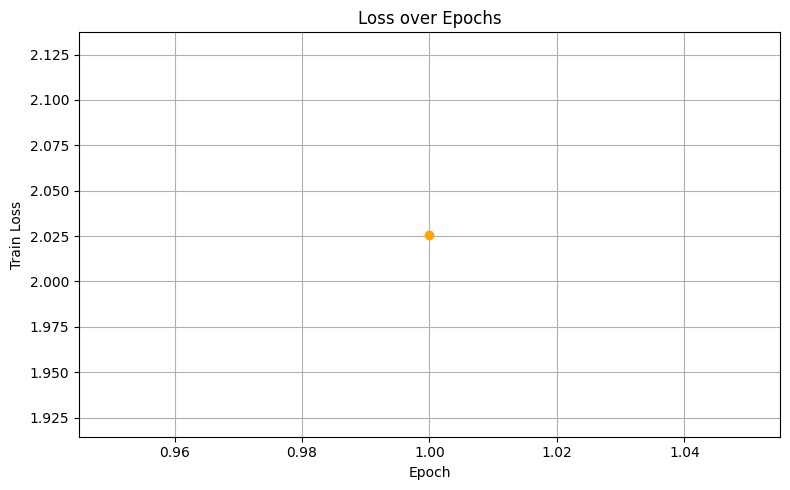

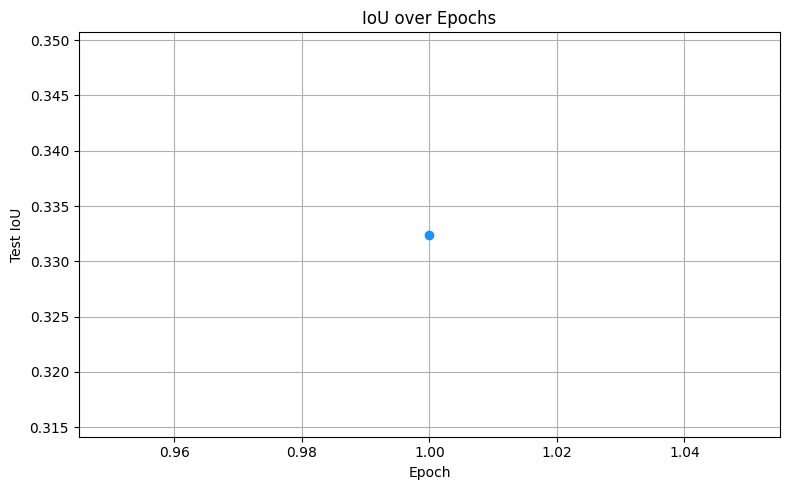

  >> Best model saved at epoch 1 with IoU: 0.3324
[10/183] Loss: 1.9396 Train Acc: 0.3795
[20/183] Loss: 1.7228 Train Acc: 0.4560
[30/183] Loss: 1.6228 Train Acc: 0.4955
[40/183] Loss: 1.7456 Train Acc: 0.4193
[50/183] Loss: 1.8202 Train Acc: 0.4246
[60/183] Loss: 1.6943 Train Acc: 0.4679
[70/183] Loss: 1.8371 Train Acc: 0.4156
[80/183] Loss: 1.7602 Train Acc: 0.4546
[90/183] Loss: 1.6884 Train Acc: 0.4563
[100/183] Loss: 1.6534 Train Acc: 0.4769
[110/183] Loss: 1.8405 Train Acc: 0.4346
[120/183] Loss: 1.6396 Train Acc: 0.4701
[130/183] Loss: 1.5938 Train Acc: 0.4882
[140/183] Loss: 1.7847 Train Acc: 0.4210
[150/183] Loss: 1.9440 Train Acc: 0.4028
[160/183] Loss: 1.6756 Train Acc: 0.4597
[170/183] Loss: 1.6952 Train Acc: 0.4638
[180/183] Loss: 1.5871 Train Acc: 0.4867
Epoch: 02, Test IoU: 0.3103


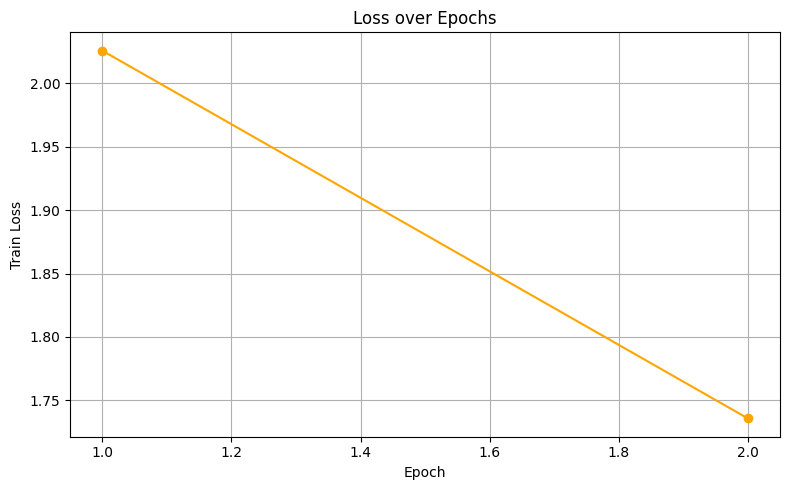

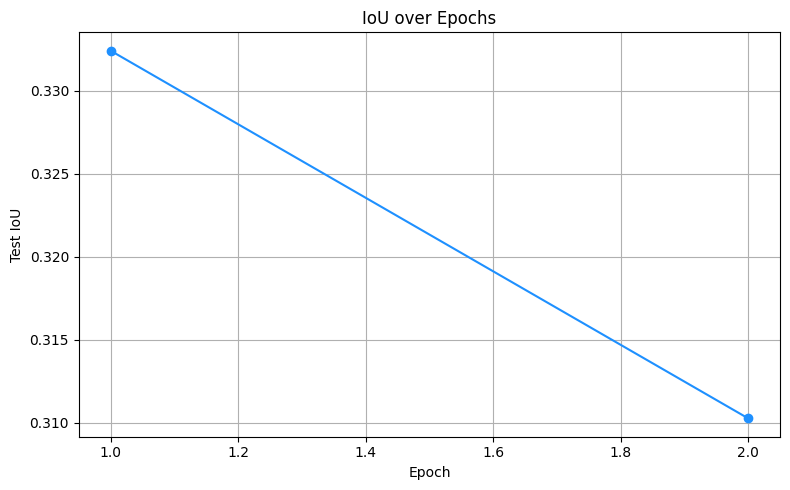

[10/183] Loss: 1.8922 Train Acc: 0.4430
[20/183] Loss: 1.8921 Train Acc: 0.4079
[30/183] Loss: 1.6174 Train Acc: 0.4861
[40/183] Loss: 1.6518 Train Acc: 0.4555
[50/183] Loss: 1.6958 Train Acc: 0.4684
[60/183] Loss: 1.8104 Train Acc: 0.3813
[70/183] Loss: 1.6043 Train Acc: 0.4765
[80/183] Loss: 1.7611 Train Acc: 0.4285
[90/183] Loss: 1.8219 Train Acc: 0.4317
[100/183] Loss: 1.6183 Train Acc: 0.4758
[110/183] Loss: 1.7146 Train Acc: 0.4489
[120/183] Loss: 1.6473 Train Acc: 0.5005
[130/183] Loss: 1.5657 Train Acc: 0.5075
[140/183] Loss: 1.8297 Train Acc: 0.4396
[150/183] Loss: 1.9692 Train Acc: 0.4094
[160/183] Loss: 1.6112 Train Acc: 0.4907
[170/183] Loss: 1.5308 Train Acc: 0.5021
[180/183] Loss: 1.5486 Train Acc: 0.4894
Epoch: 03, Test IoU: 0.4684


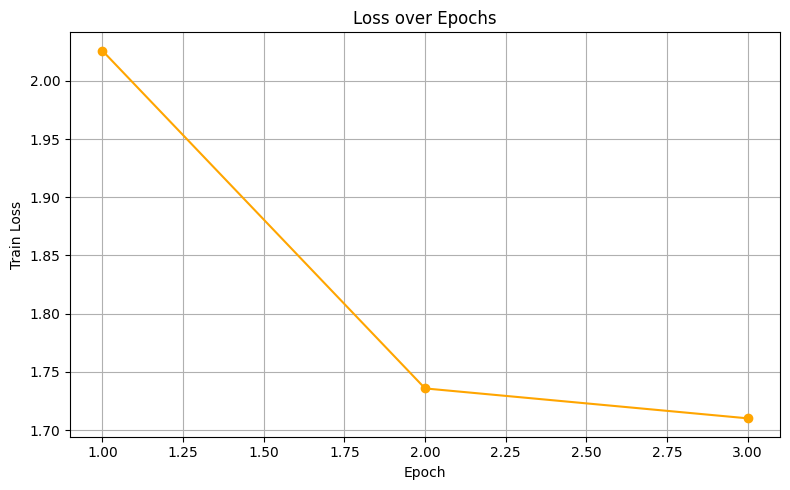

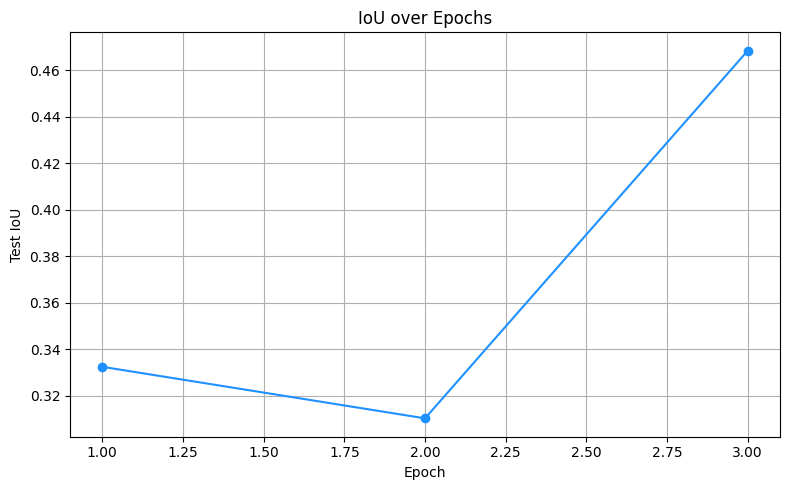

  >> Best model saved at epoch 3 with IoU: 0.4684
[10/183] Loss: 1.9070 Train Acc: 0.4125
[20/183] Loss: 1.6662 Train Acc: 0.4780
[30/183] Loss: 1.5563 Train Acc: 0.4859
[40/183] Loss: 1.5727 Train Acc: 0.4742
[50/183] Loss: 1.4489 Train Acc: 0.5291
[60/183] Loss: 1.5541 Train Acc: 0.5083
[70/183] Loss: 1.4862 Train Acc: 0.5096
[80/183] Loss: 1.5930 Train Acc: 0.4997
[90/183] Loss: 1.6502 Train Acc: 0.4889
[100/183] Loss: 1.9858 Train Acc: 0.3817
[110/183] Loss: 1.5662 Train Acc: 0.5063
[120/183] Loss: 1.5684 Train Acc: 0.4835
[130/183] Loss: 1.6356 Train Acc: 0.4763
[140/183] Loss: 1.5054 Train Acc: 0.4794
[150/183] Loss: 1.6635 Train Acc: 0.4544
[160/183] Loss: 1.4083 Train Acc: 0.5258
[170/183] Loss: 1.5101 Train Acc: 0.5071
[180/183] Loss: 1.7256 Train Acc: 0.4356
Epoch: 04, Test IoU: 0.4758


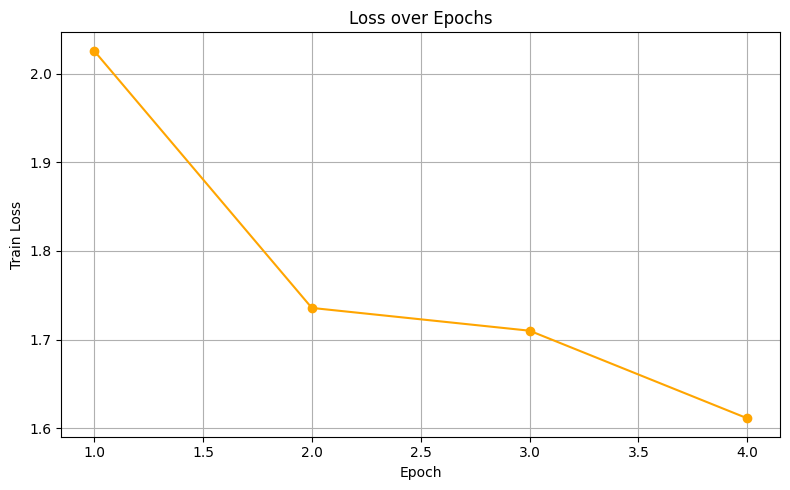

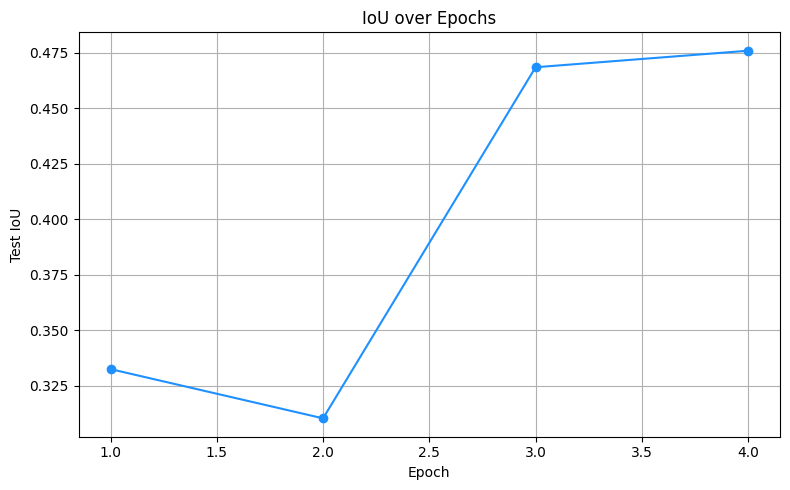

  >> Best model saved at epoch 4 with IoU: 0.4758
[10/183] Loss: 1.6007 Train Acc: 0.4953
[20/183] Loss: 1.6565 Train Acc: 0.4808
[30/183] Loss: 1.6234 Train Acc: 0.4985
[40/183] Loss: 1.5783 Train Acc: 0.4756
[50/183] Loss: 1.6072 Train Acc: 0.4690
[60/183] Loss: 1.4603 Train Acc: 0.5262
[70/183] Loss: 1.6361 Train Acc: 0.4533
[80/183] Loss: 1.7846 Train Acc: 0.4837
[90/183] Loss: 1.8428 Train Acc: 0.4099
[100/183] Loss: 1.4726 Train Acc: 0.5567
[110/183] Loss: 1.5337 Train Acc: 0.4839
[120/183] Loss: 1.5210 Train Acc: 0.4892
[130/183] Loss: 1.5683 Train Acc: 0.4876
[140/183] Loss: 1.6343 Train Acc: 0.4853
[150/183] Loss: 1.5339 Train Acc: 0.5037
[160/183] Loss: 1.4206 Train Acc: 0.5394
[170/183] Loss: 1.3977 Train Acc: 0.5291
[180/183] Loss: 1.5994 Train Acc: 0.4829
Epoch: 05, Test IoU: 0.4036


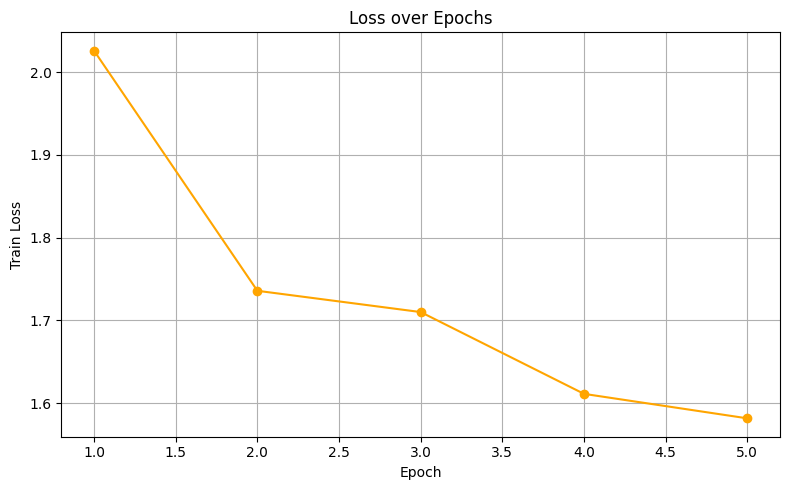

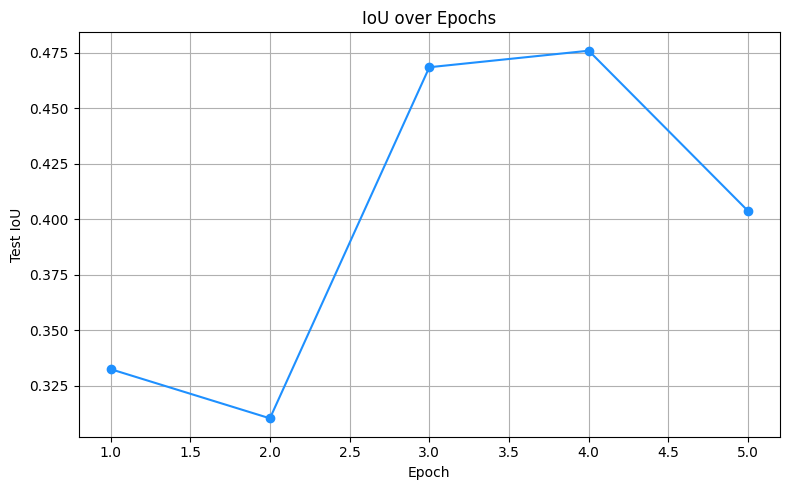

[10/183] Loss: 1.6583 Train Acc: 0.4524
[20/183] Loss: 1.5164 Train Acc: 0.4985
[30/183] Loss: 1.4525 Train Acc: 0.5308
[40/183] Loss: 1.4926 Train Acc: 0.5412
[50/183] Loss: 1.7443 Train Acc: 0.4819
[60/183] Loss: 1.6810 Train Acc: 0.5037
[70/183] Loss: 1.8218 Train Acc: 0.4372
[80/183] Loss: 1.8583 Train Acc: 0.4332
[90/183] Loss: 1.6688 Train Acc: 0.4594
[100/183] Loss: 1.5707 Train Acc: 0.4872
[110/183] Loss: 1.6742 Train Acc: 0.4427
[120/183] Loss: 1.7389 Train Acc: 0.4558
[130/183] Loss: 1.5148 Train Acc: 0.5449
[140/183] Loss: 1.7838 Train Acc: 0.4179
[150/183] Loss: 1.7172 Train Acc: 0.4533
[160/183] Loss: 1.5258 Train Acc: 0.4961
[170/183] Loss: 1.7473 Train Acc: 0.4622
[180/183] Loss: 1.4424 Train Acc: 0.5222
Epoch: 06, Test IoU: 0.3584


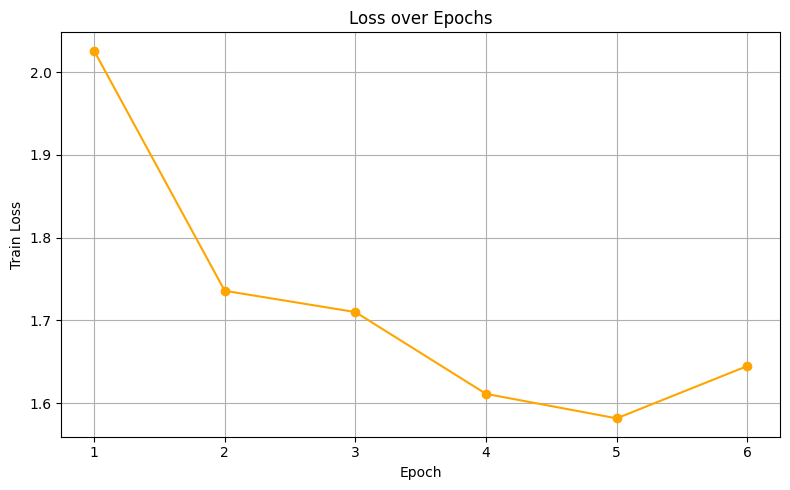

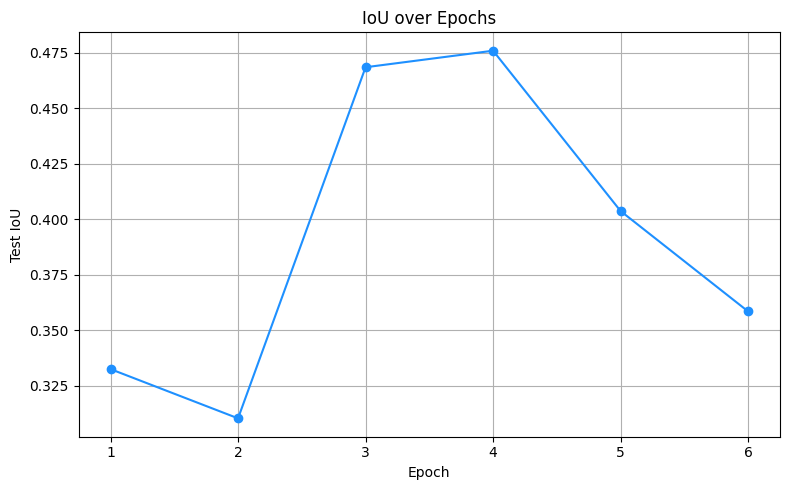

[10/183] Loss: 1.6497 Train Acc: 0.4615
[20/183] Loss: 1.4485 Train Acc: 0.5369
[30/183] Loss: 1.4492 Train Acc: 0.5373
[40/183] Loss: 1.3763 Train Acc: 0.5408
[50/183] Loss: 1.3044 Train Acc: 0.5768
[60/183] Loss: 1.4804 Train Acc: 0.5398
[70/183] Loss: 1.4751 Train Acc: 0.5587
[80/183] Loss: 1.5878 Train Acc: 0.4993
[90/183] Loss: 1.7145 Train Acc: 0.4895
[100/183] Loss: 1.4397 Train Acc: 0.5349
[110/183] Loss: 1.6106 Train Acc: 0.5200
[120/183] Loss: 1.5938 Train Acc: 0.4979
[130/183] Loss: 1.4761 Train Acc: 0.5590
[140/183] Loss: 1.6549 Train Acc: 0.4581
[150/183] Loss: 1.4038 Train Acc: 0.5351
[160/183] Loss: 1.3505 Train Acc: 0.5552
[170/183] Loss: 1.6985 Train Acc: 0.4765
[180/183] Loss: 1.4364 Train Acc: 0.5187
Epoch: 07, Test IoU: 0.5457


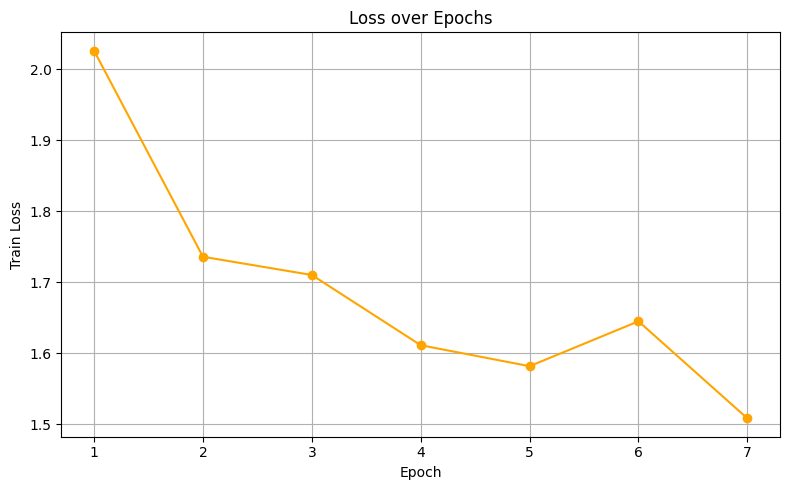

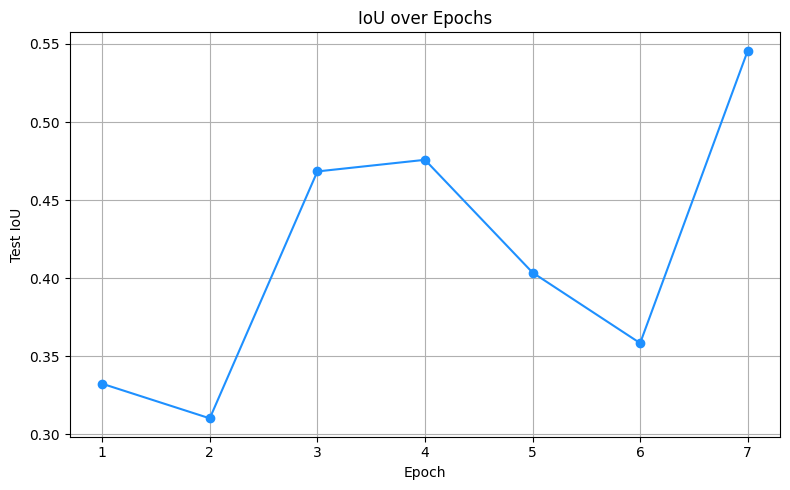

  >> Best model saved at epoch 7 with IoU: 0.5457
[10/183] Loss: 1.2614 Train Acc: 0.5953
[20/183] Loss: 1.7316 Train Acc: 0.4644
[30/183] Loss: 1.4580 Train Acc: 0.5081
[40/183] Loss: 1.3921 Train Acc: 0.5329
[50/183] Loss: 1.5788 Train Acc: 0.5014
[60/183] Loss: 1.5202 Train Acc: 0.4926
[70/183] Loss: 1.7156 Train Acc: 0.4790
[80/183] Loss: 1.3977 Train Acc: 0.5437
[90/183] Loss: 1.5223 Train Acc: 0.5320
[100/183] Loss: 1.9111 Train Acc: 0.4594
[110/183] Loss: 1.5142 Train Acc: 0.5130
[120/183] Loss: 1.7450 Train Acc: 0.4445
[130/183] Loss: 1.7185 Train Acc: 0.4570
[140/183] Loss: 1.6506 Train Acc: 0.4751
[150/183] Loss: 1.2918 Train Acc: 0.5704
[160/183] Loss: 1.7608 Train Acc: 0.5188
[170/183] Loss: 1.3408 Train Acc: 0.5806
[180/183] Loss: 1.6307 Train Acc: 0.4958
Epoch: 08, Test IoU: 0.4989


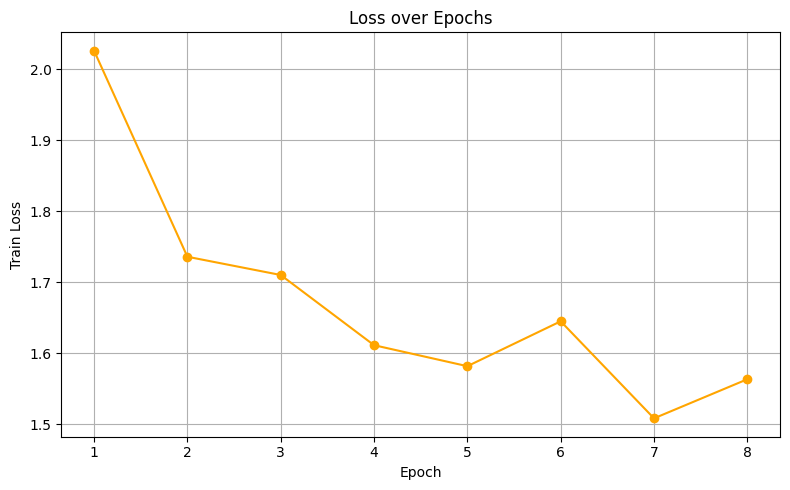

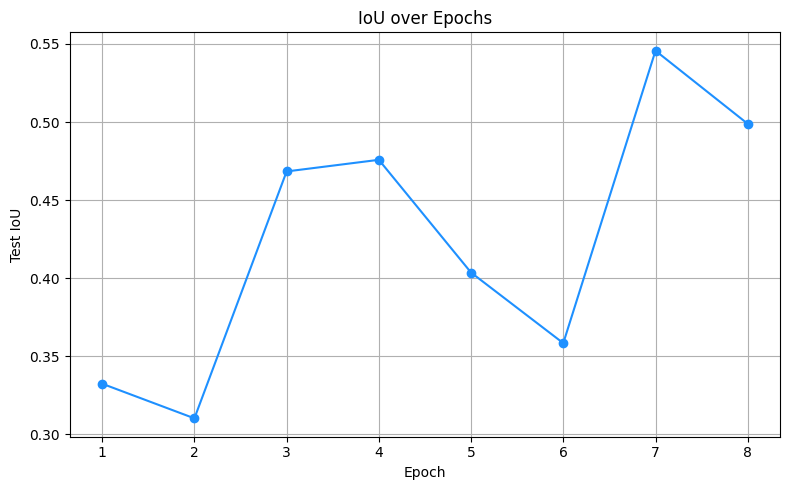

[10/183] Loss: 1.4532 Train Acc: 0.5592
[20/183] Loss: 1.4744 Train Acc: 0.5222
[30/183] Loss: 1.4884 Train Acc: 0.5206
[40/183] Loss: 1.4376 Train Acc: 0.5209
[50/183] Loss: 1.6460 Train Acc: 0.4824
[60/183] Loss: 1.4845 Train Acc: 0.5253
[70/183] Loss: 1.4189 Train Acc: 0.5291
[80/183] Loss: 1.4570 Train Acc: 0.5343
[90/183] Loss: 1.4868 Train Acc: 0.5211
[100/183] Loss: 1.5328 Train Acc: 0.5004
[110/183] Loss: 1.5489 Train Acc: 0.4896
[120/183] Loss: 1.2910 Train Acc: 0.6021
[130/183] Loss: 1.6163 Train Acc: 0.4778
[140/183] Loss: 1.4417 Train Acc: 0.5313
[150/183] Loss: 1.4095 Train Acc: 0.5527
[160/183] Loss: 1.5961 Train Acc: 0.5186
[170/183] Loss: 1.5722 Train Acc: 0.5145
[180/183] Loss: 1.4696 Train Acc: 0.5185
Epoch: 09, Test IoU: 0.5584


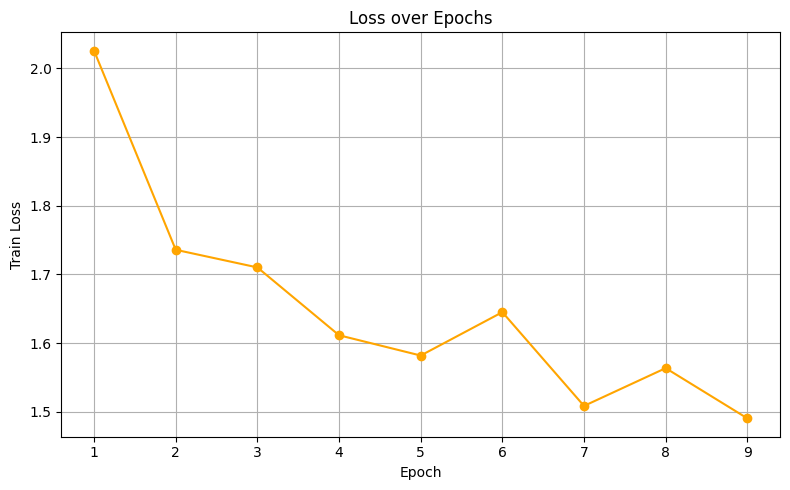

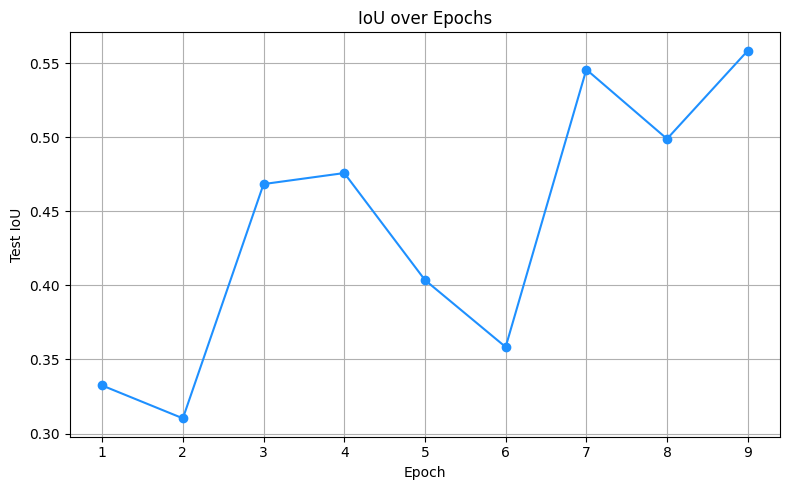

  >> Best model saved at epoch 9 with IoU: 0.5584
[10/183] Loss: 1.6563 Train Acc: 0.4851
[20/183] Loss: 1.4664 Train Acc: 0.5449
[30/183] Loss: 1.5808 Train Acc: 0.5354
[40/183] Loss: 1.4403 Train Acc: 0.5432
[50/183] Loss: 1.6292 Train Acc: 0.5012
[60/183] Loss: 1.4553 Train Acc: 0.5280
[70/183] Loss: 1.2273 Train Acc: 0.6138
[80/183] Loss: 1.4865 Train Acc: 0.5007
[90/183] Loss: 1.2796 Train Acc: 0.5954
[100/183] Loss: 1.2503 Train Acc: 0.5739
[110/183] Loss: 1.4983 Train Acc: 0.4863
[120/183] Loss: 1.4422 Train Acc: 0.5529
[130/183] Loss: 1.7130 Train Acc: 0.4708
[140/183] Loss: 1.5417 Train Acc: 0.5422
[150/183] Loss: 1.3248 Train Acc: 0.5644
[160/183] Loss: 1.3804 Train Acc: 0.5757
[170/183] Loss: 1.4433 Train Acc: 0.5232
[180/183] Loss: 1.5432 Train Acc: 0.4968
Epoch: 10, Test IoU: 0.5924


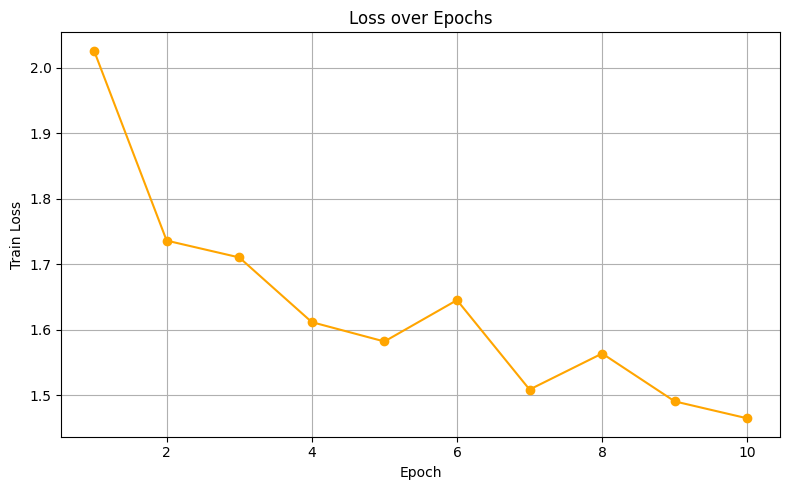

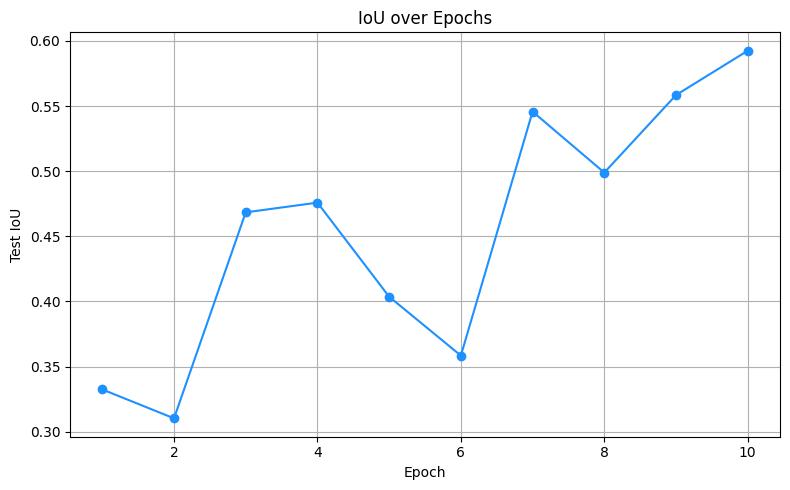

  >> Best model saved at epoch 10 with IoU: 0.5924
[10/183] Loss: 1.4804 Train Acc: 0.5172
[20/183] Loss: 1.3386 Train Acc: 0.5945
[30/183] Loss: 1.3996 Train Acc: 0.5607
[40/183] Loss: 1.4924 Train Acc: 0.5220
[50/183] Loss: 1.2184 Train Acc: 0.6049
[60/183] Loss: 1.1061 Train Acc: 0.6386
[70/183] Loss: 1.5338 Train Acc: 0.4985
[80/183] Loss: 1.7534 Train Acc: 0.5240
[90/183] Loss: 1.2116 Train Acc: 0.6106
[100/183] Loss: 1.5004 Train Acc: 0.5406
[110/183] Loss: 1.5675 Train Acc: 0.4940
[120/183] Loss: 1.3987 Train Acc: 0.5337
[130/183] Loss: 1.3201 Train Acc: 0.5811
[140/183] Loss: 1.5219 Train Acc: 0.5366
[150/183] Loss: 1.4917 Train Acc: 0.5167
[160/183] Loss: 1.5696 Train Acc: 0.5093
[170/183] Loss: 1.4436 Train Acc: 0.5387
[180/183] Loss: 1.2545 Train Acc: 0.5943
Epoch: 11, Test IoU: 0.4679


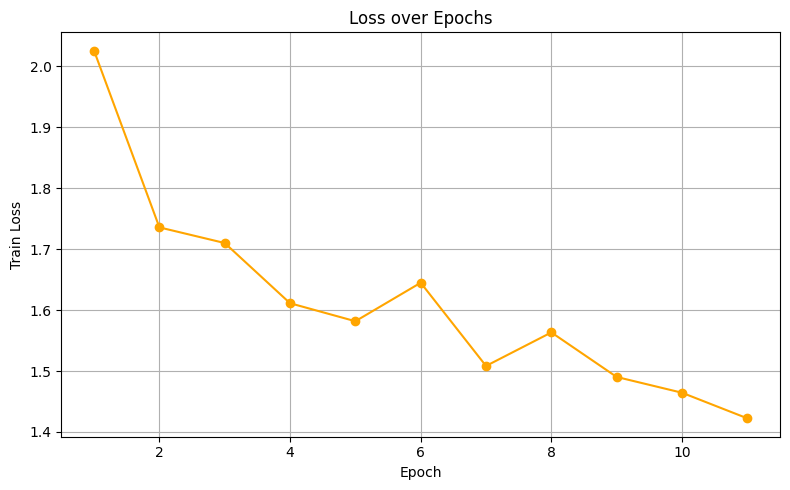

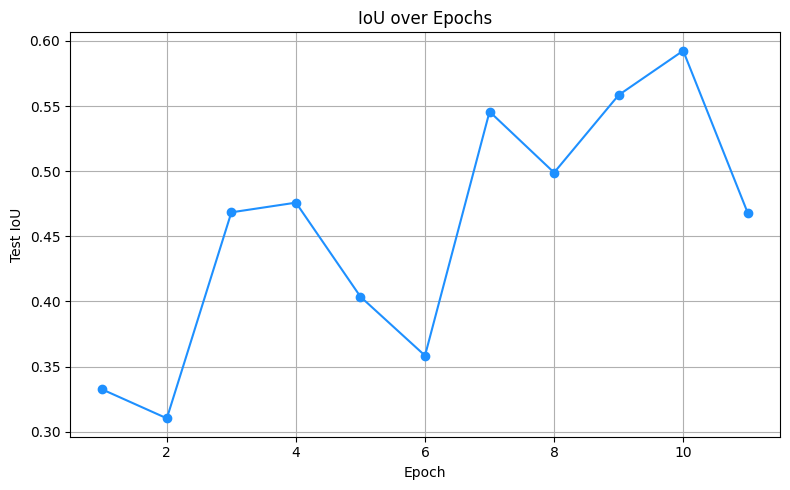

[10/183] Loss: 1.4662 Train Acc: 0.5091
[20/183] Loss: 1.4670 Train Acc: 0.5347
[30/183] Loss: 1.3530 Train Acc: 0.5543
[40/183] Loss: 1.2432 Train Acc: 0.5885
[50/183] Loss: 1.4808 Train Acc: 0.4990
[60/183] Loss: 1.3326 Train Acc: 0.5531
[70/183] Loss: 1.2336 Train Acc: 0.5951
[80/183] Loss: 1.4160 Train Acc: 0.5627
[90/183] Loss: 1.6805 Train Acc: 0.4833
[100/183] Loss: 1.5966 Train Acc: 0.5114
[110/183] Loss: 1.4190 Train Acc: 0.5307
[120/183] Loss: 1.6087 Train Acc: 0.5086
[130/183] Loss: 1.4954 Train Acc: 0.5361
[140/183] Loss: 1.4698 Train Acc: 0.5448
[150/183] Loss: 1.3981 Train Acc: 0.5491
[160/183] Loss: 1.4446 Train Acc: 0.5838
[170/183] Loss: 1.5115 Train Acc: 0.5120
[180/183] Loss: 1.4178 Train Acc: 0.5760
Epoch: 12, Test IoU: 0.5095


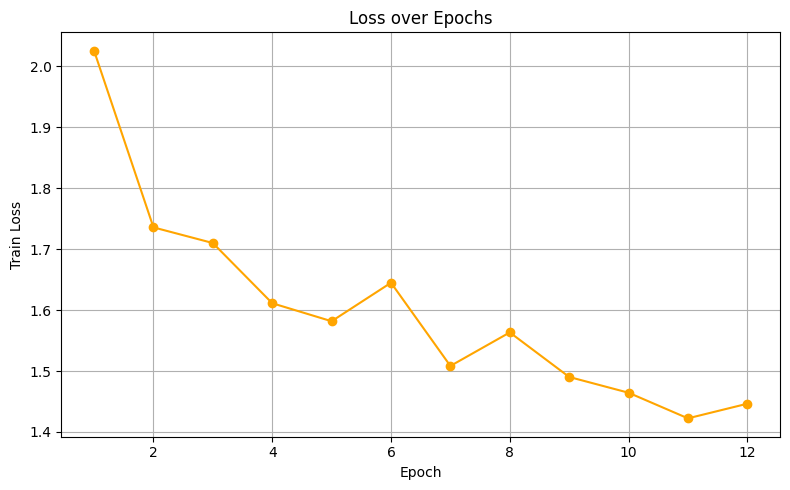

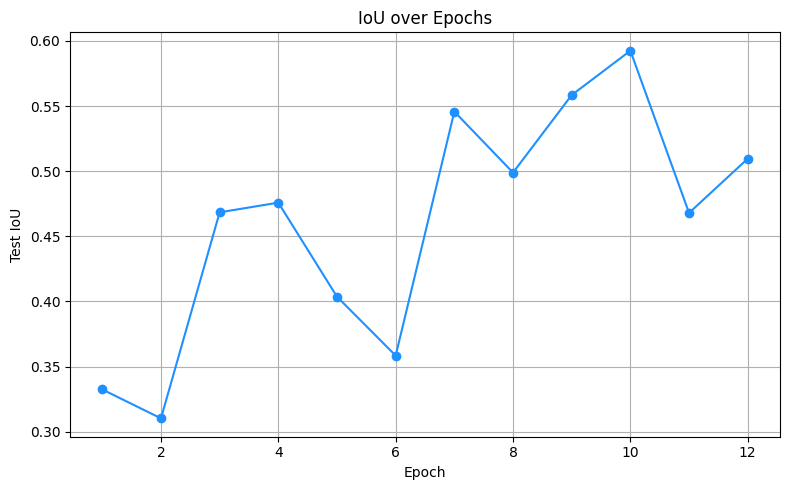

[10/183] Loss: 1.5779 Train Acc: 0.4961
[20/183] Loss: 1.4660 Train Acc: 0.5813
[30/183] Loss: 1.5123 Train Acc: 0.5021
[40/183] Loss: 1.3088 Train Acc: 0.5609
[50/183] Loss: 1.4135 Train Acc: 0.5349
[60/183] Loss: 1.2757 Train Acc: 0.5953
[70/183] Loss: 1.3483 Train Acc: 0.5459
[80/183] Loss: 1.3664 Train Acc: 0.5474
[90/183] Loss: 1.3990 Train Acc: 0.5713
[100/183] Loss: 1.3362 Train Acc: 0.5850
[110/183] Loss: 1.4098 Train Acc: 0.5137
[120/183] Loss: 1.2980 Train Acc: 0.5635
[130/183] Loss: 1.4368 Train Acc: 0.5123
[140/183] Loss: 1.2680 Train Acc: 0.6034
[150/183] Loss: 1.3556 Train Acc: 0.5692
[160/183] Loss: 1.3400 Train Acc: 0.5623
[170/183] Loss: 1.1389 Train Acc: 0.6343
[180/183] Loss: 1.3466 Train Acc: 0.5569
Epoch: 13, Test IoU: 0.6037


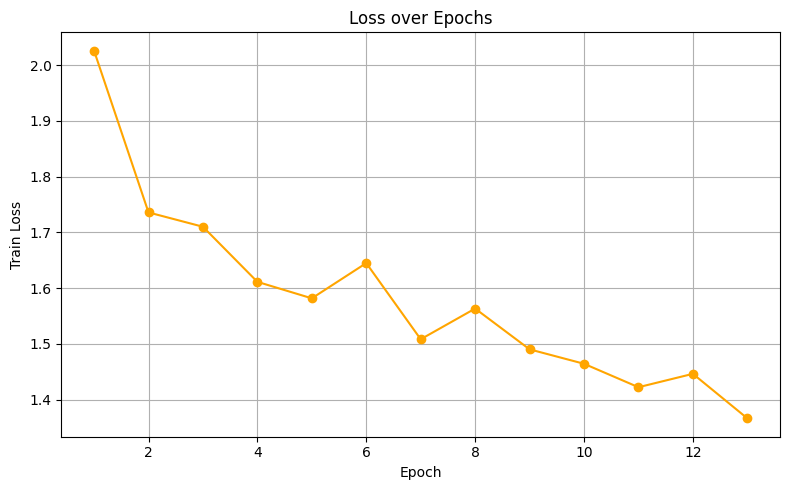

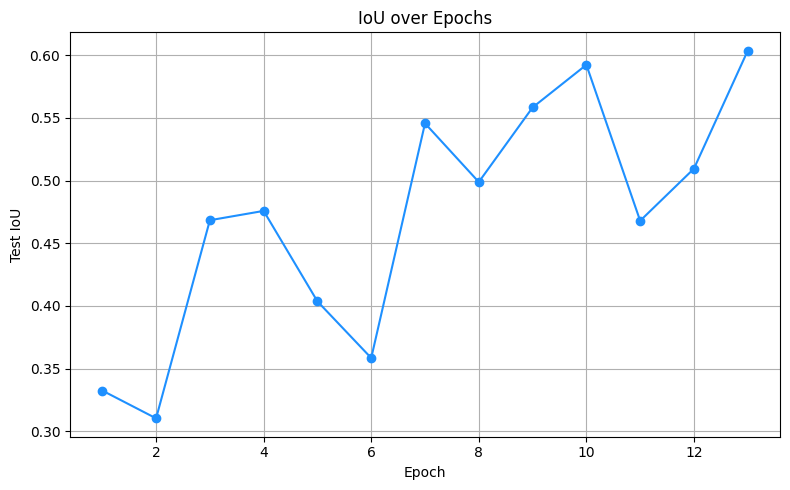

  >> Best model saved at epoch 13 with IoU: 0.6037
[10/183] Loss: 1.1681 Train Acc: 0.6100
[20/183] Loss: 1.2714 Train Acc: 0.5604
[30/183] Loss: 1.4822 Train Acc: 0.5321
[40/183] Loss: 1.5281 Train Acc: 0.5333
[50/183] Loss: 1.3215 Train Acc: 0.5635
[60/183] Loss: 1.1612 Train Acc: 0.6102
[70/183] Loss: 1.2022 Train Acc: 0.5946
[80/183] Loss: 1.5174 Train Acc: 0.5116
[90/183] Loss: 1.4272 Train Acc: 0.5240
[100/183] Loss: 1.3857 Train Acc: 0.5334
[110/183] Loss: 1.1300 Train Acc: 0.6370
[120/183] Loss: 1.5093 Train Acc: 0.4772
[130/183] Loss: 1.4639 Train Acc: 0.5498
[140/183] Loss: 1.1997 Train Acc: 0.5977
[150/183] Loss: 1.2967 Train Acc: 0.5660
[160/183] Loss: 1.3410 Train Acc: 0.5788
[170/183] Loss: 1.6342 Train Acc: 0.5059
[180/183] Loss: 1.2117 Train Acc: 0.6077
Epoch: 14, Test IoU: 0.5904


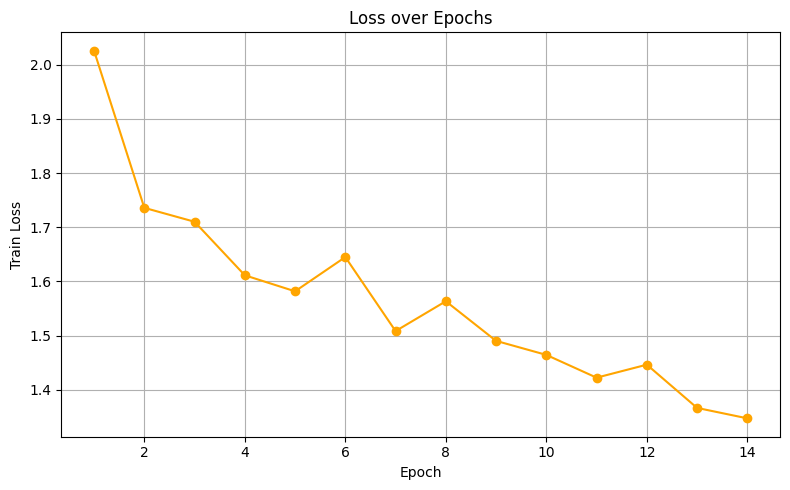

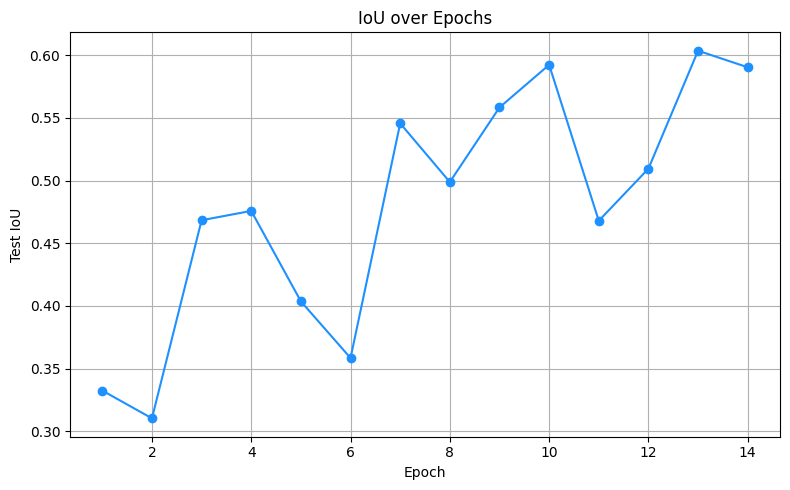

[10/183] Loss: 1.2645 Train Acc: 0.6055
[20/183] Loss: 1.3998 Train Acc: 0.5303
[30/183] Loss: 1.3545 Train Acc: 0.5624
[40/183] Loss: 1.2353 Train Acc: 0.6060
[50/183] Loss: 1.5444 Train Acc: 0.5058
[60/183] Loss: 1.4655 Train Acc: 0.5246
[70/183] Loss: 1.3174 Train Acc: 0.5842
[80/183] Loss: 1.2109 Train Acc: 0.5947
[90/183] Loss: 1.2460 Train Acc: 0.5784
[100/183] Loss: 1.3282 Train Acc: 0.5737
[110/183] Loss: 1.2987 Train Acc: 0.5800
[120/183] Loss: 1.2893 Train Acc: 0.5742
[130/183] Loss: 1.3085 Train Acc: 0.5357
[140/183] Loss: 1.2034 Train Acc: 0.6100
[150/183] Loss: 1.4241 Train Acc: 0.5574
[160/183] Loss: 1.3650 Train Acc: 0.5578
[170/183] Loss: 1.1862 Train Acc: 0.6097
[180/183] Loss: 1.2588 Train Acc: 0.5615
Epoch: 15, Test IoU: 0.6031


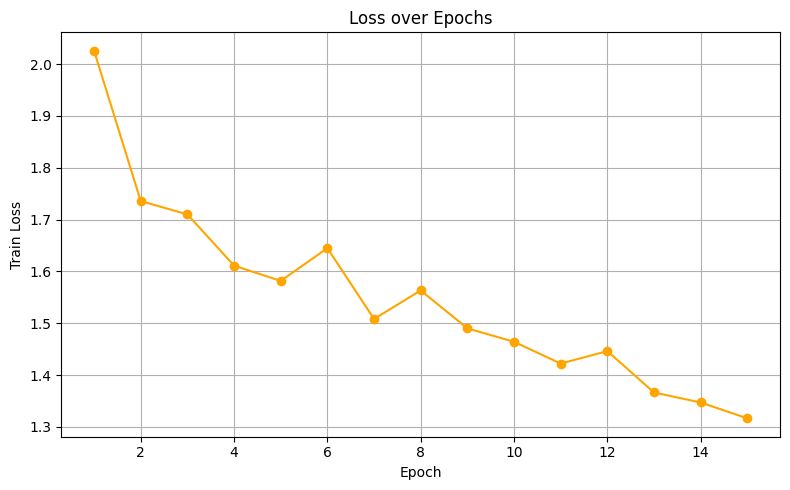

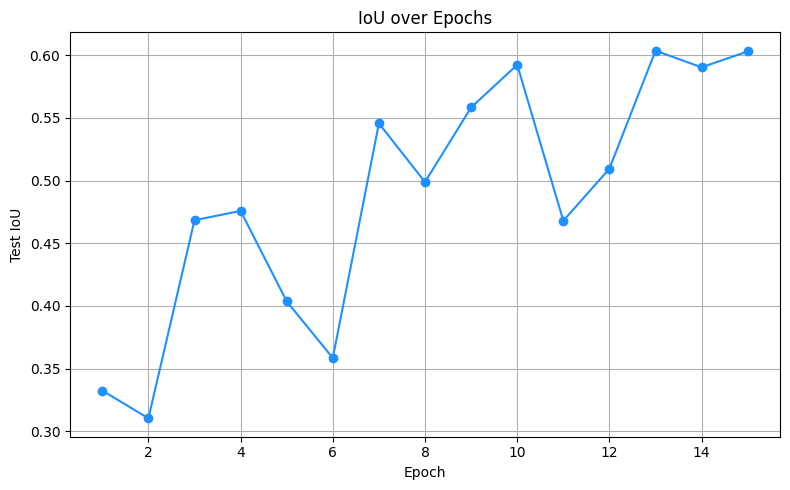

[10/183] Loss: 1.1966 Train Acc: 0.6092
[20/183] Loss: 1.2289 Train Acc: 0.5960
[30/183] Loss: 1.6358 Train Acc: 0.4834
[40/183] Loss: 1.5119 Train Acc: 0.5259
[50/183] Loss: 1.2806 Train Acc: 0.5748
[60/183] Loss: 1.3376 Train Acc: 0.5671
[70/183] Loss: 1.2771 Train Acc: 0.5928
[80/183] Loss: 1.2301 Train Acc: 0.5785
[90/183] Loss: 1.1732 Train Acc: 0.6016
[100/183] Loss: 1.2620 Train Acc: 0.5906
[110/183] Loss: 1.5672 Train Acc: 0.5169
[120/183] Loss: 1.3060 Train Acc: 0.5622
[130/183] Loss: 1.7207 Train Acc: 0.4733
[140/183] Loss: 1.6094 Train Acc: 0.4721
[150/183] Loss: 1.2495 Train Acc: 0.5815
[160/183] Loss: 1.3099 Train Acc: 0.5833
[170/183] Loss: 1.2115 Train Acc: 0.6036
[180/183] Loss: 1.5054 Train Acc: 0.5092
Epoch: 16, Test IoU: 0.6040


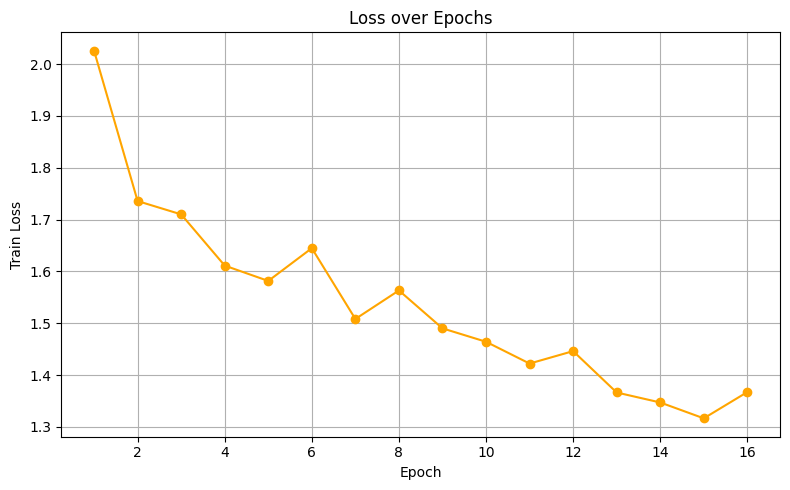

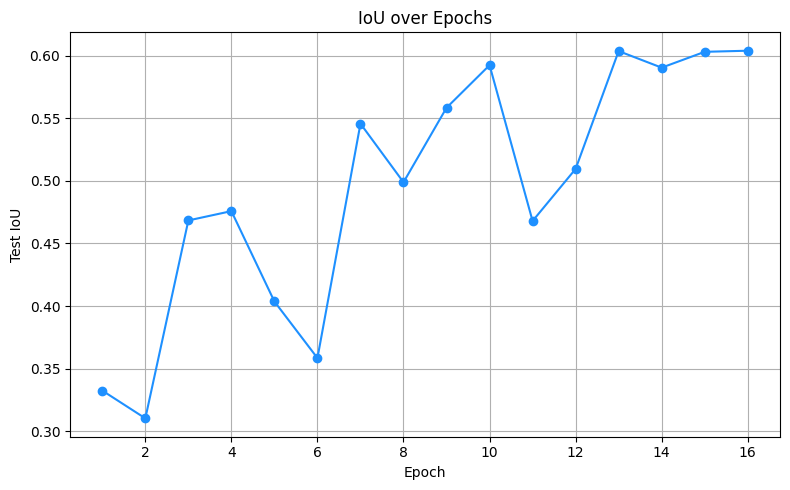

  >> Best model saved at epoch 16 with IoU: 0.6040
[10/183] Loss: 1.1571 Train Acc: 0.6163
[20/183] Loss: 1.2444 Train Acc: 0.5838
[30/183] Loss: 1.2053 Train Acc: 0.5775
[40/183] Loss: 1.3574 Train Acc: 0.5662
[50/183] Loss: 1.3944 Train Acc: 0.5452
[60/183] Loss: 1.4248 Train Acc: 0.5474
[70/183] Loss: 1.3616 Train Acc: 0.5675
[80/183] Loss: 1.3884 Train Acc: 0.5721
[90/183] Loss: 1.3390 Train Acc: 0.5785
[100/183] Loss: 1.3093 Train Acc: 0.5900
[110/183] Loss: 1.2092 Train Acc: 0.6091
[120/183] Loss: 1.2152 Train Acc: 0.6067
[130/183] Loss: 1.1867 Train Acc: 0.6085
[140/183] Loss: 1.2942 Train Acc: 0.5523
[150/183] Loss: 1.5143 Train Acc: 0.5207
[160/183] Loss: 1.1643 Train Acc: 0.5985
[170/183] Loss: 1.2271 Train Acc: 0.5938
[180/183] Loss: 1.3189 Train Acc: 0.5536
Epoch: 17, Test IoU: 0.6310


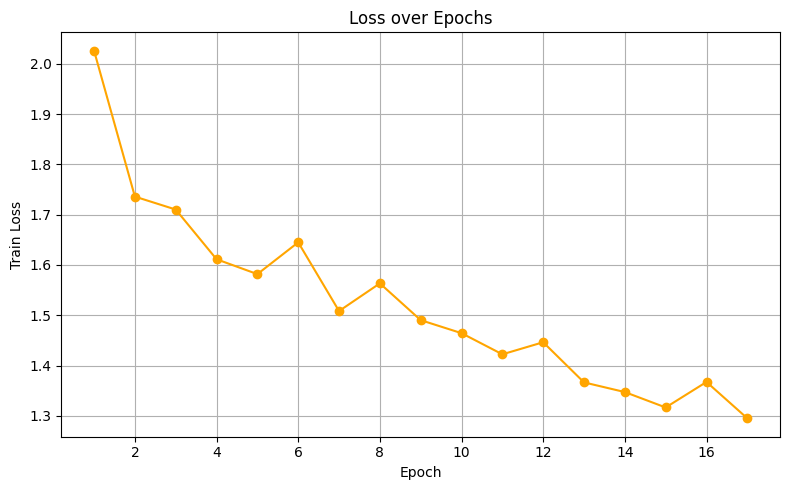

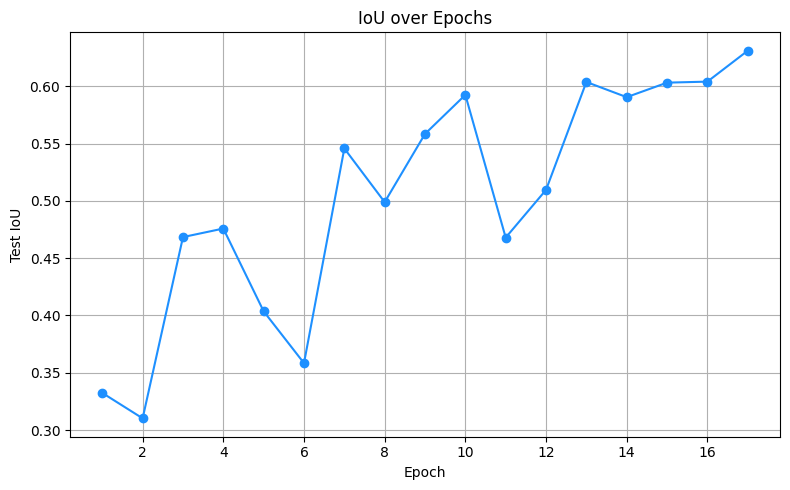

  >> Best model saved at epoch 17 with IoU: 0.6310
[10/183] Loss: 1.2189 Train Acc: 0.6059
[20/183] Loss: 1.2507 Train Acc: 0.5800
[30/183] Loss: 1.5139 Train Acc: 0.5194
[40/183] Loss: 1.2007 Train Acc: 0.6069
[50/183] Loss: 1.2051 Train Acc: 0.6000
[60/183] Loss: 1.5562 Train Acc: 0.5730
[70/183] Loss: 1.5437 Train Acc: 0.4953
[80/183] Loss: 1.3564 Train Acc: 0.5474
[90/183] Loss: 1.4310 Train Acc: 0.5347
[100/183] Loss: 1.3288 Train Acc: 0.5564
[110/183] Loss: 1.3183 Train Acc: 0.5611
[120/183] Loss: 1.1548 Train Acc: 0.5884
[130/183] Loss: 1.1433 Train Acc: 0.6315
[140/183] Loss: 1.3549 Train Acc: 0.5677
[150/183] Loss: 1.2570 Train Acc: 0.6101
[160/183] Loss: 1.2209 Train Acc: 0.6178
[170/183] Loss: 1.5434 Train Acc: 0.5575
[180/183] Loss: 1.2915 Train Acc: 0.5610
Epoch: 18, Test IoU: 0.5914


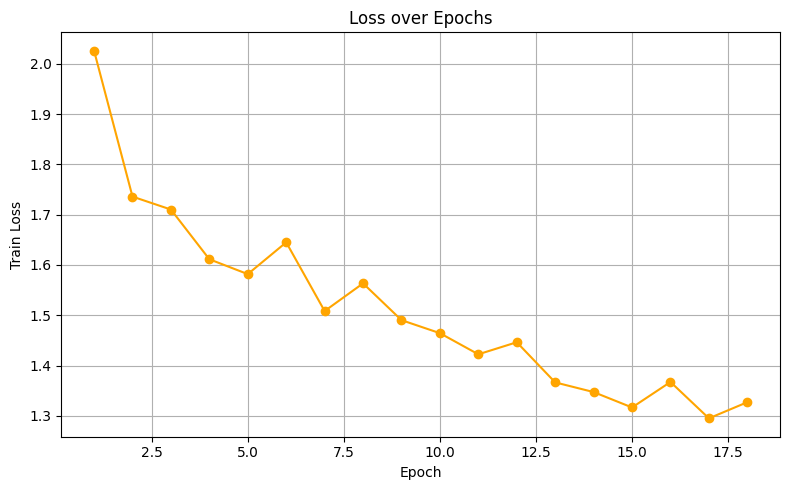

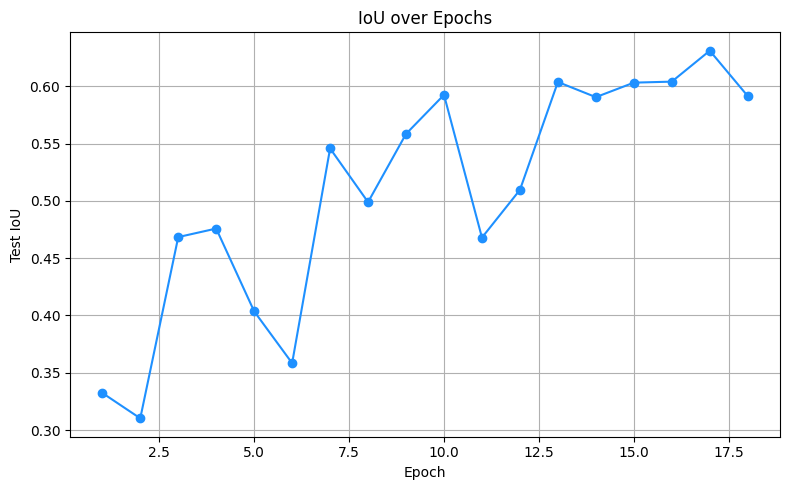

[10/183] Loss: 1.2365 Train Acc: 0.5961
[20/183] Loss: 1.4112 Train Acc: 0.5455
[30/183] Loss: 1.0945 Train Acc: 0.6211
[40/183] Loss: 1.4062 Train Acc: 0.5444
[50/183] Loss: 1.3624 Train Acc: 0.5553
[60/183] Loss: 1.5127 Train Acc: 0.5070
[70/183] Loss: 1.1637 Train Acc: 0.6200
[80/183] Loss: 1.4172 Train Acc: 0.5423
[90/183] Loss: 1.1857 Train Acc: 0.6005
[100/183] Loss: 0.9955 Train Acc: 0.6785
[110/183] Loss: 1.1845 Train Acc: 0.6125
[120/183] Loss: 1.3366 Train Acc: 0.5413
[130/183] Loss: 1.4358 Train Acc: 0.5397
[140/183] Loss: 1.2566 Train Acc: 0.6037
[150/183] Loss: 1.4091 Train Acc: 0.5429
[160/183] Loss: 1.4863 Train Acc: 0.5192
[170/183] Loss: 1.2669 Train Acc: 0.5595
[180/183] Loss: 1.2159 Train Acc: 0.5752
Epoch: 19, Test IoU: 0.6241


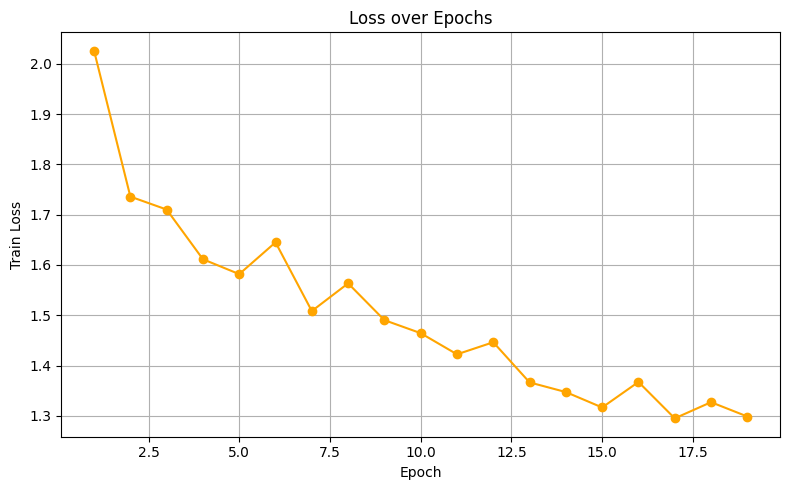

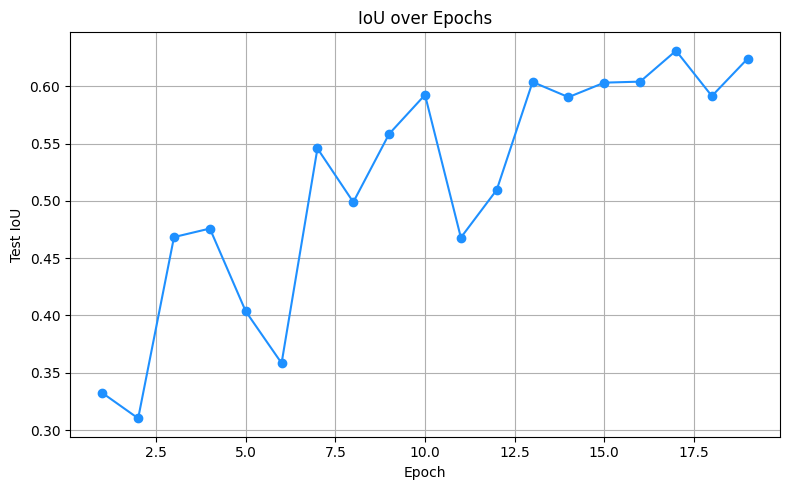

[10/183] Loss: 1.4623 Train Acc: 0.5201
[20/183] Loss: 1.3873 Train Acc: 0.5492
[30/183] Loss: 1.2159 Train Acc: 0.5705
[40/183] Loss: 1.1565 Train Acc: 0.6153
[50/183] Loss: 1.3000 Train Acc: 0.5760
[60/183] Loss: 1.3344 Train Acc: 0.5410
[70/183] Loss: 1.1651 Train Acc: 0.6069
[80/183] Loss: 1.2177 Train Acc: 0.6009
[90/183] Loss: 1.3018 Train Acc: 0.5589
[100/183] Loss: 1.1700 Train Acc: 0.6204
[110/183] Loss: 1.5095 Train Acc: 0.5498
[120/183] Loss: 1.2342 Train Acc: 0.5849
[130/183] Loss: 1.1986 Train Acc: 0.6006
[140/183] Loss: 1.2348 Train Acc: 0.5911
[150/183] Loss: 1.1957 Train Acc: 0.5952
[160/183] Loss: 1.2097 Train Acc: 0.6031
[170/183] Loss: 1.4355 Train Acc: 0.5806
[180/183] Loss: 1.1353 Train Acc: 0.6440
Epoch: 20, Test IoU: 0.6065


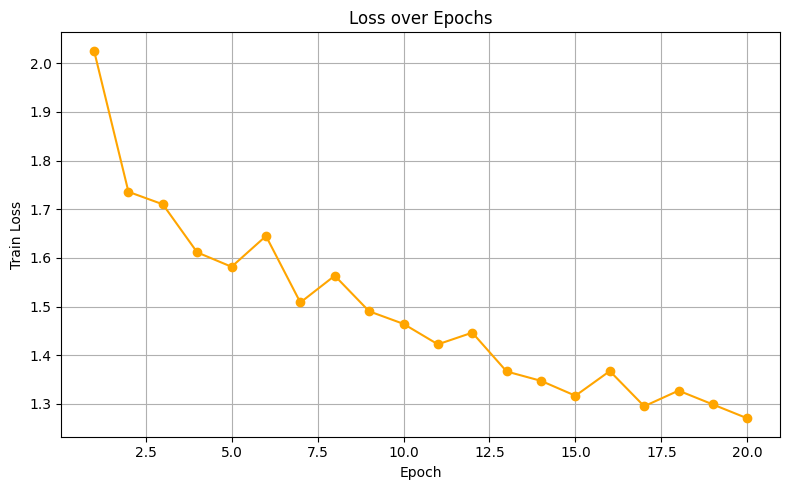

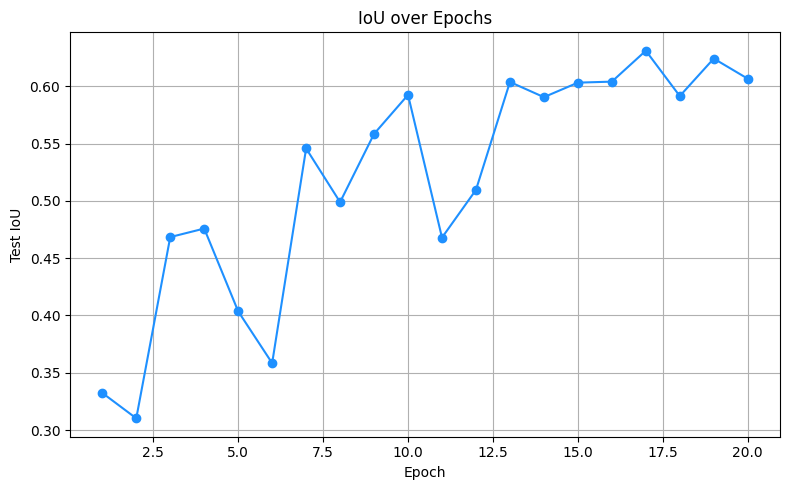

[10/183] Loss: 1.1715 Train Acc: 0.5736
[20/183] Loss: 1.0499 Train Acc: 0.6433
[30/183] Loss: 1.0349 Train Acc: 0.6443
[40/183] Loss: 1.1229 Train Acc: 0.6132
[50/183] Loss: 1.1428 Train Acc: 0.6277
[60/183] Loss: 1.2088 Train Acc: 0.5929
[70/183] Loss: 1.3553 Train Acc: 0.5401
[80/183] Loss: 1.4135 Train Acc: 0.5597
[90/183] Loss: 1.4960 Train Acc: 0.5167
[100/183] Loss: 1.2052 Train Acc: 0.5753
[110/183] Loss: 1.2558 Train Acc: 0.5618
[120/183] Loss: 1.3452 Train Acc: 0.5545
[130/183] Loss: 1.0436 Train Acc: 0.6411
[140/183] Loss: 1.1976 Train Acc: 0.6035
[150/183] Loss: 1.0468 Train Acc: 0.6306
[160/183] Loss: 1.1909 Train Acc: 0.5888
[170/183] Loss: 1.4688 Train Acc: 0.5150
[180/183] Loss: 1.4400 Train Acc: 0.5393
Epoch: 21, Test IoU: 0.6068


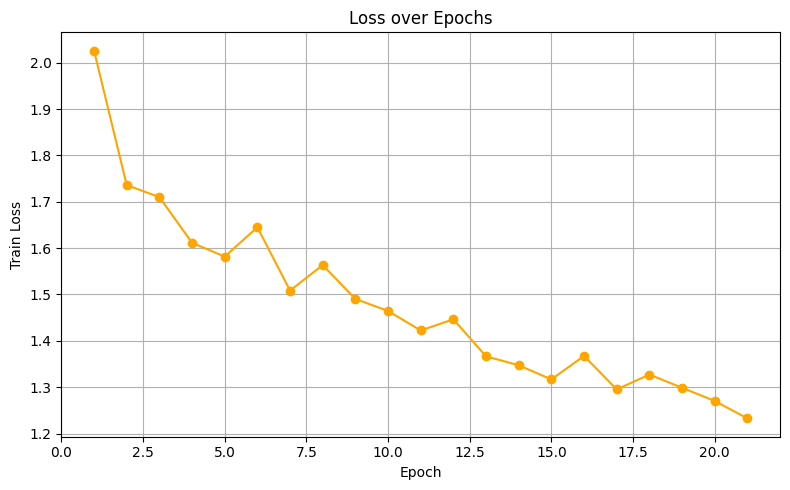

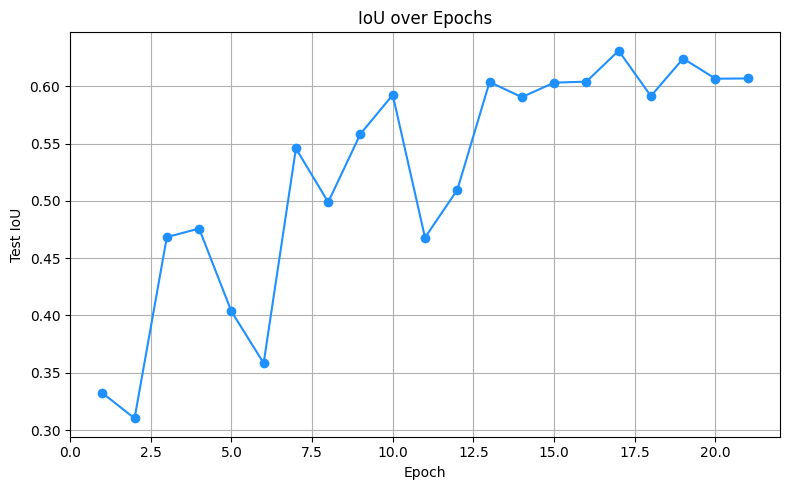

[10/183] Loss: 1.2442 Train Acc: 0.5961
[20/183] Loss: 1.2640 Train Acc: 0.5992
[30/183] Loss: 1.1579 Train Acc: 0.6103
[40/183] Loss: 1.1929 Train Acc: 0.6104
[50/183] Loss: 1.4843 Train Acc: 0.5315
[60/183] Loss: 1.3378 Train Acc: 0.5920
[70/183] Loss: 1.2315 Train Acc: 0.5893
[80/183] Loss: 1.4135 Train Acc: 0.5451
[90/183] Loss: 1.3216 Train Acc: 0.5291
[100/183] Loss: 1.0883 Train Acc: 0.6300
[110/183] Loss: 1.2972 Train Acc: 0.5556
[120/183] Loss: 1.2495 Train Acc: 0.6017
[130/183] Loss: 1.3883 Train Acc: 0.5260
[140/183] Loss: 1.2144 Train Acc: 0.5917
[150/183] Loss: 1.4086 Train Acc: 0.5493
[160/183] Loss: 1.4270 Train Acc: 0.5631
[170/183] Loss: 1.2611 Train Acc: 0.5966
[180/183] Loss: 1.1068 Train Acc: 0.6281
Epoch: 22, Test IoU: 0.6410


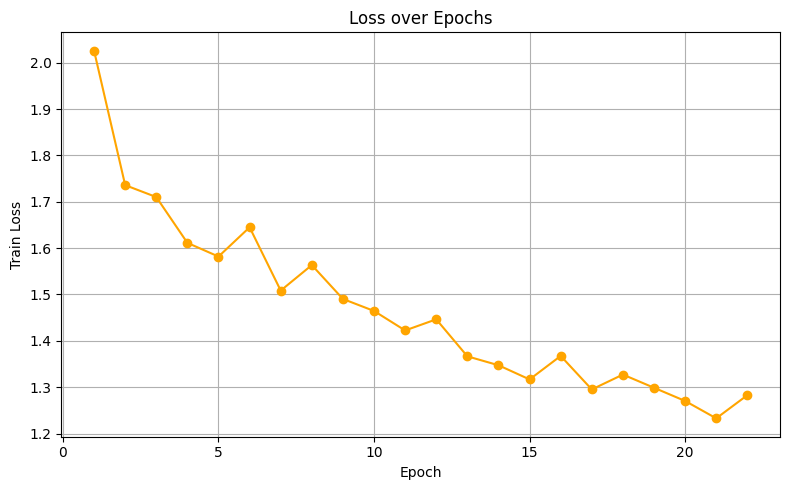

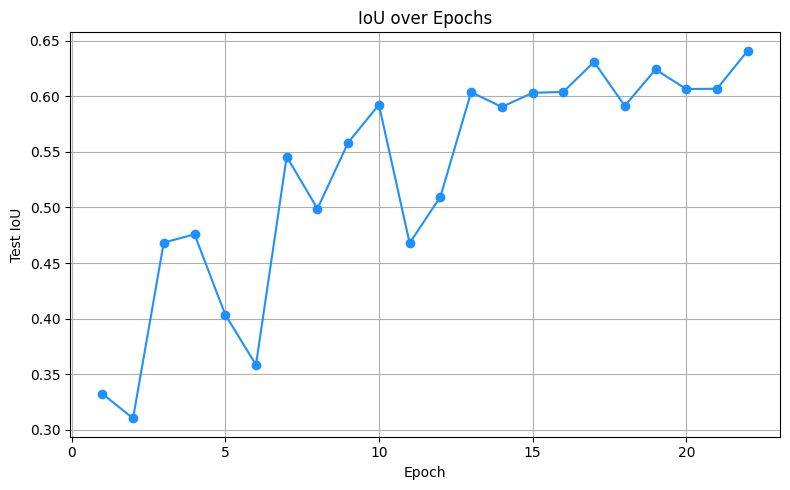

  >> Best model saved at epoch 22 with IoU: 0.6410
[10/183] Loss: 1.1978 Train Acc: 0.5849
[20/183] Loss: 1.5687 Train Acc: 0.5163
[30/183] Loss: 1.0927 Train Acc: 0.6094
[40/183] Loss: 1.2427 Train Acc: 0.5796
[50/183] Loss: 1.2621 Train Acc: 0.5553
[60/183] Loss: 1.4120 Train Acc: 0.5332
[70/183] Loss: 1.2470 Train Acc: 0.5891
[80/183] Loss: 0.9707 Train Acc: 0.6569
[90/183] Loss: 1.0387 Train Acc: 0.6446
[100/183] Loss: 1.2160 Train Acc: 0.6042
[110/183] Loss: 1.2612 Train Acc: 0.5986
[120/183] Loss: 1.1753 Train Acc: 0.5912
[130/183] Loss: 1.0297 Train Acc: 0.6576
[140/183] Loss: 1.2917 Train Acc: 0.5879
[150/183] Loss: 1.0871 Train Acc: 0.6389
[160/183] Loss: 1.1847 Train Acc: 0.6135
[170/183] Loss: 1.3548 Train Acc: 0.5601
[180/183] Loss: 1.3019 Train Acc: 0.5900
Epoch: 23, Test IoU: 0.6518


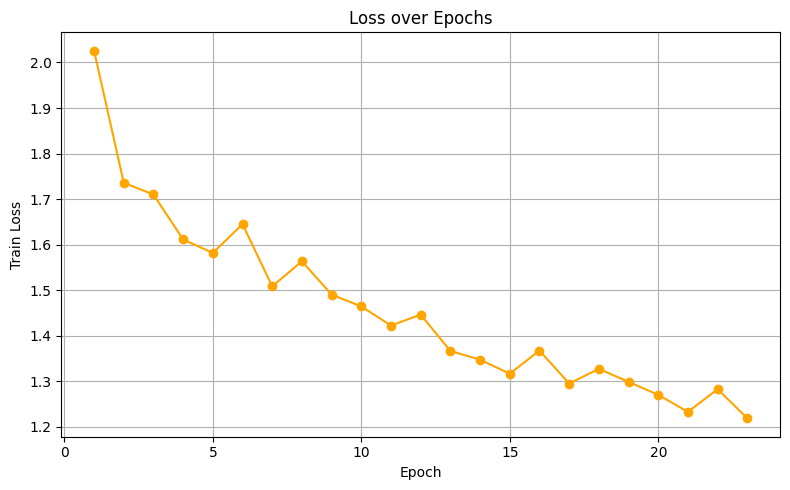

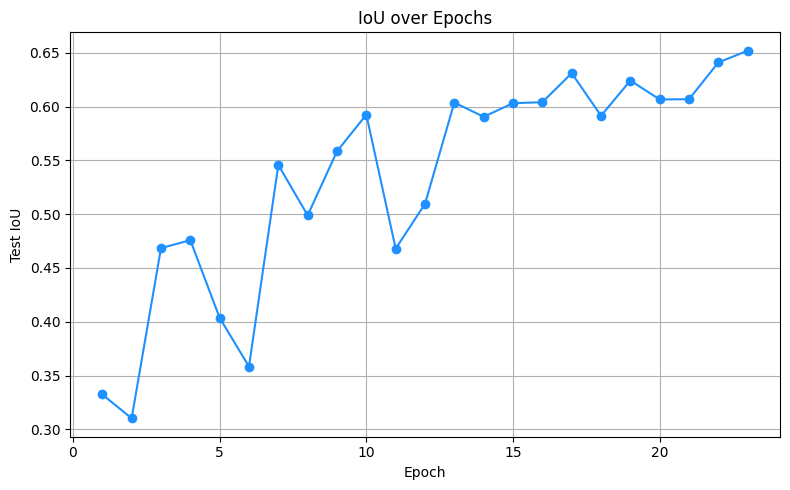

  >> Best model saved at epoch 23 with IoU: 0.6518
[10/183] Loss: 1.3046 Train Acc: 0.5678
[20/183] Loss: 1.2442 Train Acc: 0.5732
[30/183] Loss: 1.0792 Train Acc: 0.5974
[40/183] Loss: 1.1420 Train Acc: 0.6145
[50/183] Loss: 1.2804 Train Acc: 0.5746
[60/183] Loss: 1.2232 Train Acc: 0.5969
[70/183] Loss: 1.2463 Train Acc: 0.6111
[80/183] Loss: 1.1899 Train Acc: 0.6013
[90/183] Loss: 1.2244 Train Acc: 0.6017
[100/183] Loss: 1.0635 Train Acc: 0.6342
[110/183] Loss: 1.1252 Train Acc: 0.6510
[120/183] Loss: 1.0362 Train Acc: 0.6549
[130/183] Loss: 1.3225 Train Acc: 0.5626
[140/183] Loss: 1.4813 Train Acc: 0.5148
[150/183] Loss: 1.4907 Train Acc: 0.5262
[160/183] Loss: 1.3275 Train Acc: 0.5326
[170/183] Loss: 1.2121 Train Acc: 0.5842
[180/183] Loss: 1.0362 Train Acc: 0.6245
Epoch: 24, Test IoU: 0.5727


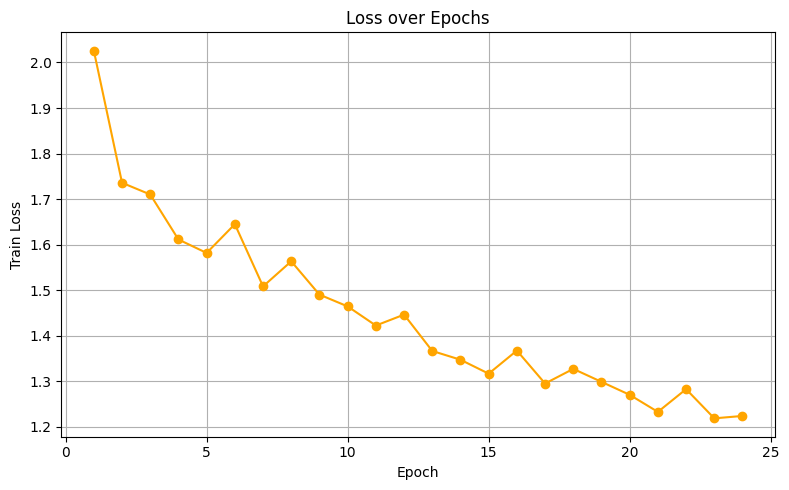

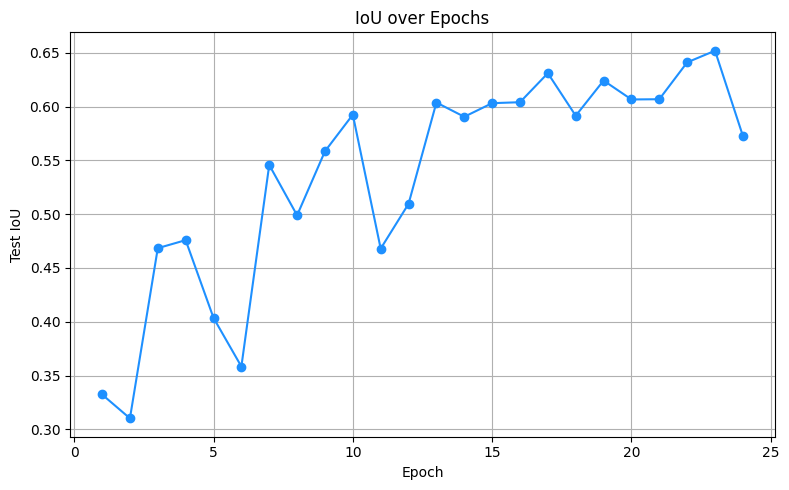

[10/183] Loss: 1.1428 Train Acc: 0.6103
[20/183] Loss: 1.1555 Train Acc: 0.6470
[30/183] Loss: 1.2583 Train Acc: 0.5487
[40/183] Loss: 1.1955 Train Acc: 0.6011
[50/183] Loss: 1.2245 Train Acc: 0.5925
[60/183] Loss: 1.3313 Train Acc: 0.5716
[70/183] Loss: 1.2464 Train Acc: 0.5932
[80/183] Loss: 1.0782 Train Acc: 0.6406
[90/183] Loss: 1.2193 Train Acc: 0.5782
[100/183] Loss: 1.1727 Train Acc: 0.5958
[110/183] Loss: 1.3147 Train Acc: 0.5439
[120/183] Loss: 1.1832 Train Acc: 0.6219
[130/183] Loss: 1.4474 Train Acc: 0.5561
[140/183] Loss: 1.4977 Train Acc: 0.5250
[150/183] Loss: 1.3998 Train Acc: 0.5402
[160/183] Loss: 1.1145 Train Acc: 0.6321
[170/183] Loss: 1.0687 Train Acc: 0.6380
[180/183] Loss: 1.1849 Train Acc: 0.6011
Epoch: 25, Test IoU: 0.6497


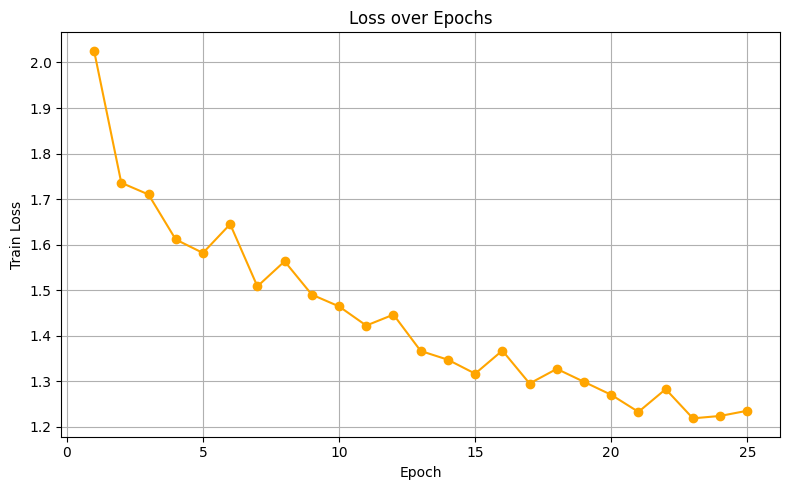

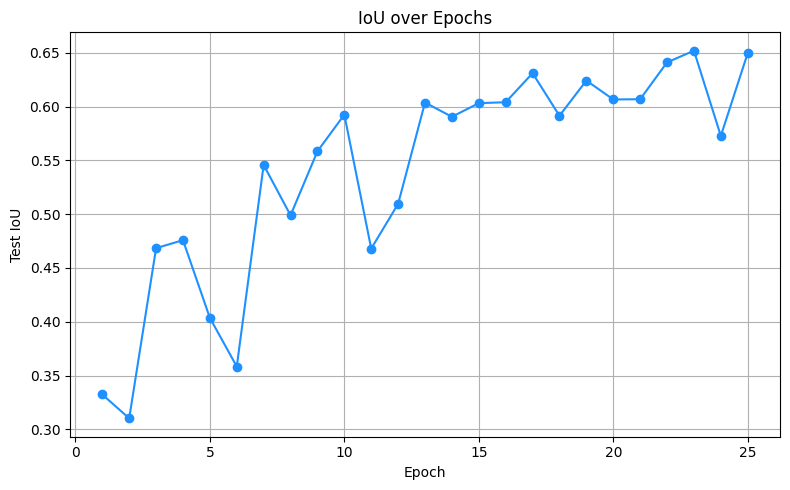

[10/183] Loss: 1.1519 Train Acc: 0.6222
[20/183] Loss: 1.0225 Train Acc: 0.6883
[30/183] Loss: 1.1567 Train Acc: 0.6245
[40/183] Loss: 1.2305 Train Acc: 0.5985
[50/183] Loss: 1.1302 Train Acc: 0.6027
[60/183] Loss: 1.1886 Train Acc: 0.6161
[70/183] Loss: 1.4257 Train Acc: 0.6040
[80/183] Loss: 1.1645 Train Acc: 0.5901
[90/183] Loss: 1.2891 Train Acc: 0.5912
[100/183] Loss: 1.1619 Train Acc: 0.6152
[110/183] Loss: 1.2669 Train Acc: 0.5778
[120/183] Loss: 1.2964 Train Acc: 0.5561
[130/183] Loss: 1.3314 Train Acc: 0.5781
[140/183] Loss: 1.3343 Train Acc: 0.5814
[150/183] Loss: 1.0807 Train Acc: 0.6453
[160/183] Loss: 1.0585 Train Acc: 0.6504
[170/183] Loss: 1.1262 Train Acc: 0.6045
[180/183] Loss: 1.1291 Train Acc: 0.6130
Epoch: 26, Test IoU: 0.6380


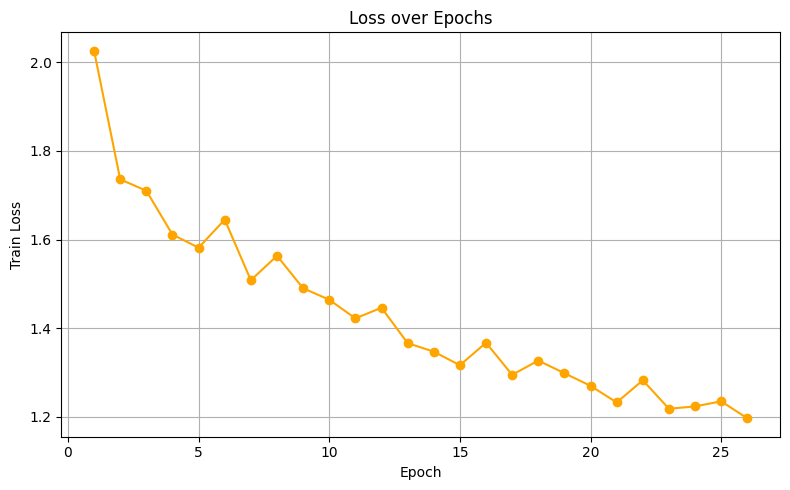

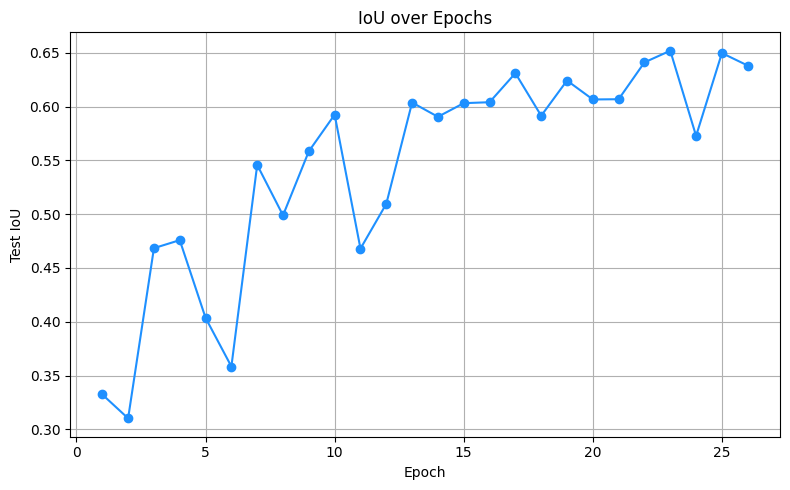

[10/183] Loss: 1.1405 Train Acc: 0.6474
[20/183] Loss: 0.9714 Train Acc: 0.6585
[30/183] Loss: 1.0863 Train Acc: 0.6198
[40/183] Loss: 1.4853 Train Acc: 0.5528
[50/183] Loss: 1.2836 Train Acc: 0.5695
[60/183] Loss: 1.0115 Train Acc: 0.6430
[70/183] Loss: 1.3089 Train Acc: 0.5778
[80/183] Loss: 1.0791 Train Acc: 0.6421
[90/183] Loss: 1.0661 Train Acc: 0.6347
[100/183] Loss: 1.0742 Train Acc: 0.6355
[110/183] Loss: 1.2122 Train Acc: 0.5842
[120/183] Loss: 1.1966 Train Acc: 0.6357
[130/183] Loss: 1.3136 Train Acc: 0.5521
[140/183] Loss: 1.3327 Train Acc: 0.5509
[150/183] Loss: 1.1791 Train Acc: 0.6095
[160/183] Loss: 1.1316 Train Acc: 0.6072
[170/183] Loss: 1.1804 Train Acc: 0.6206
[180/183] Loss: 1.0210 Train Acc: 0.6600
Epoch: 27, Test IoU: 0.6491


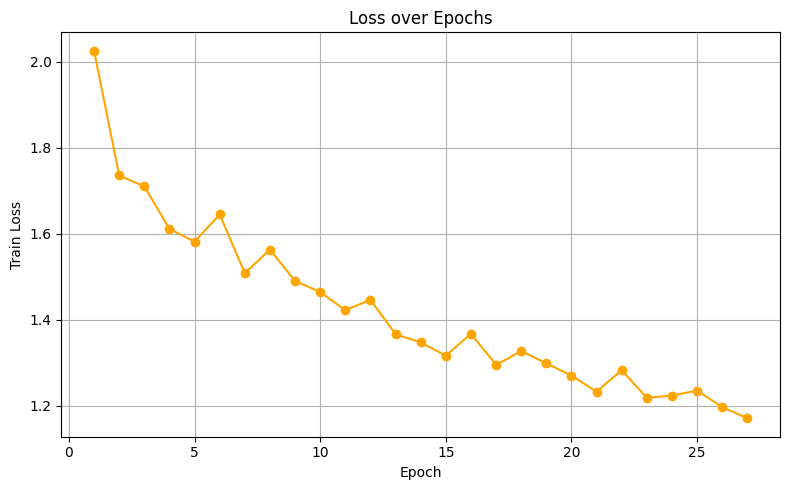

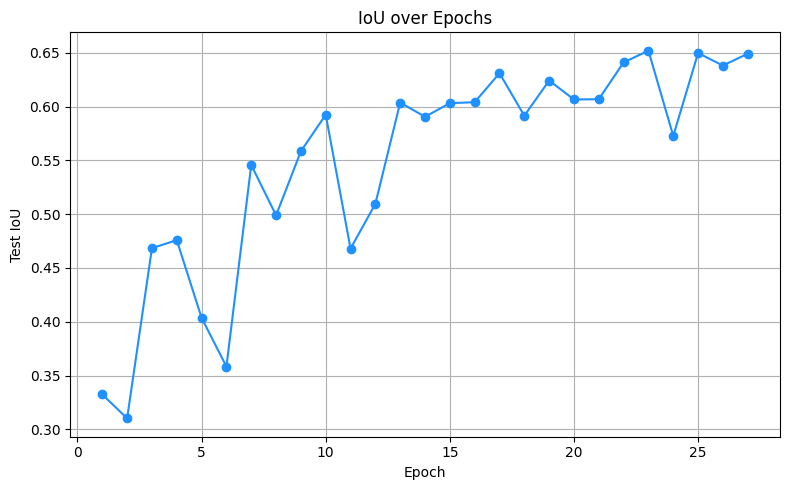

[10/183] Loss: 1.3335 Train Acc: 0.5647
[20/183] Loss: 1.3557 Train Acc: 0.5562
[30/183] Loss: 1.3888 Train Acc: 0.5456
[40/183] Loss: 1.0241 Train Acc: 0.6507
[50/183] Loss: 1.2549 Train Acc: 0.5772
[60/183] Loss: 1.1608 Train Acc: 0.6129
[70/183] Loss: 1.2363 Train Acc: 0.6036
[80/183] Loss: 1.1957 Train Acc: 0.5907
[90/183] Loss: 1.0920 Train Acc: 0.6167
[100/183] Loss: 1.1126 Train Acc: 0.6248
[110/183] Loss: 1.2233 Train Acc: 0.5784
[120/183] Loss: 1.1686 Train Acc: 0.5986
[130/183] Loss: 1.3019 Train Acc: 0.5514
[140/183] Loss: 1.1024 Train Acc: 0.6358
[150/183] Loss: 1.0609 Train Acc: 0.6360
[160/183] Loss: 0.9861 Train Acc: 0.6665
[170/183] Loss: 1.1055 Train Acc: 0.6252
[180/183] Loss: 1.1327 Train Acc: 0.6069
Epoch: 28, Test IoU: 0.6742


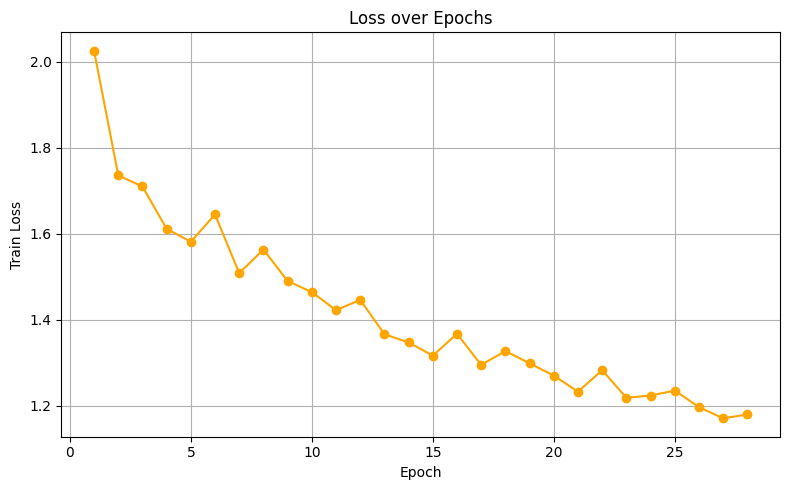

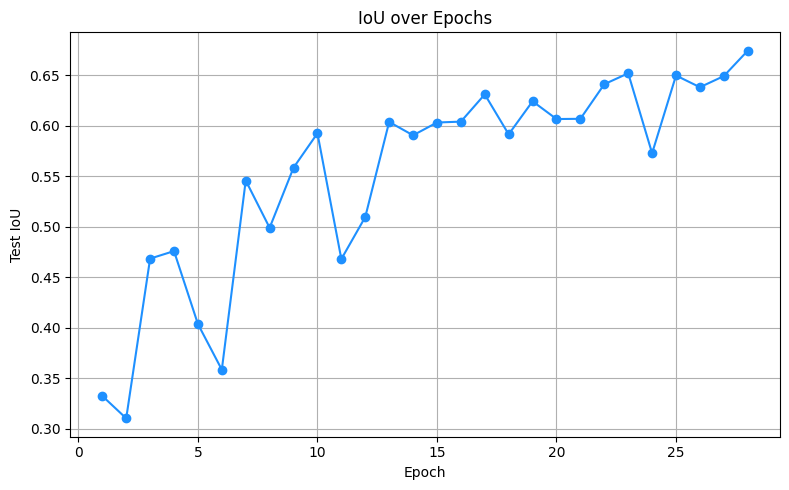

  >> Best model saved at epoch 28 with IoU: 0.6742
[10/183] Loss: 1.1734 Train Acc: 0.6148
[20/183] Loss: 1.1892 Train Acc: 0.6139
[30/183] Loss: 1.0216 Train Acc: 0.6343
[40/183] Loss: 1.0534 Train Acc: 0.6403
[50/183] Loss: 1.1643 Train Acc: 0.6197
[60/183] Loss: 1.2538 Train Acc: 0.5731
[70/183] Loss: 1.0657 Train Acc: 0.6328
[80/183] Loss: 1.1143 Train Acc: 0.6514
[90/183] Loss: 1.1480 Train Acc: 0.6363
[100/183] Loss: 1.5214 Train Acc: 0.5386
[110/183] Loss: 1.2887 Train Acc: 0.5700
[120/183] Loss: 1.1382 Train Acc: 0.5898
[130/183] Loss: 1.3314 Train Acc: 0.5563
[140/183] Loss: 1.3535 Train Acc: 0.5680
[150/183] Loss: 1.1540 Train Acc: 0.5939
[160/183] Loss: 1.3487 Train Acc: 0.5832
[170/183] Loss: 1.2544 Train Acc: 0.5808
[180/183] Loss: 1.0327 Train Acc: 0.6445
Epoch: 29, Test IoU: 0.6457


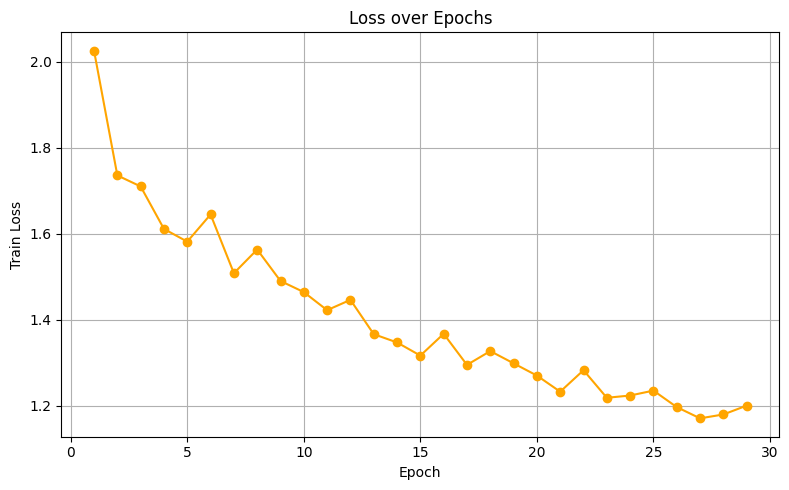

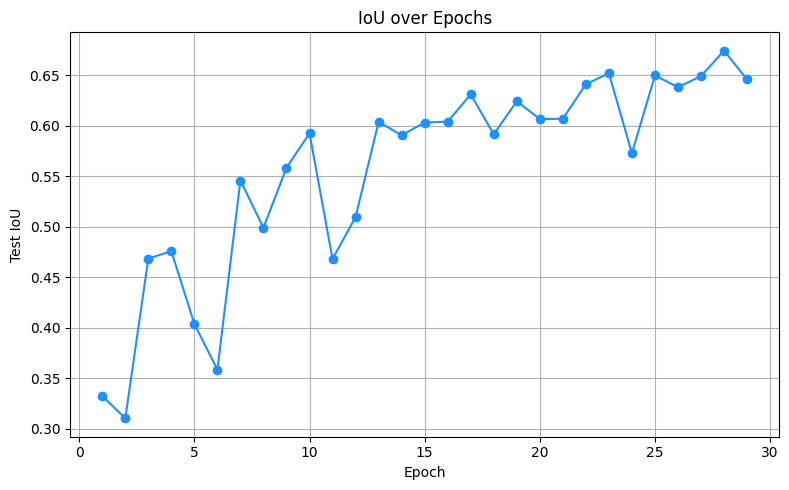

[10/183] Loss: 1.1572 Train Acc: 0.5943
[20/183] Loss: 1.4291 Train Acc: 0.5270
[30/183] Loss: 1.1984 Train Acc: 0.6043
[40/183] Loss: 1.1206 Train Acc: 0.5968
[50/183] Loss: 1.2411 Train Acc: 0.5776
[60/183] Loss: 1.0655 Train Acc: 0.6391
[70/183] Loss: 1.1616 Train Acc: 0.6201
[80/183] Loss: 1.3368 Train Acc: 0.5495
[90/183] Loss: 1.1360 Train Acc: 0.6037
[100/183] Loss: 1.3318 Train Acc: 0.5958
[110/183] Loss: 1.3095 Train Acc: 0.5744
[120/183] Loss: 1.1261 Train Acc: 0.6208
[130/183] Loss: 1.0212 Train Acc: 0.6350
[140/183] Loss: 1.0990 Train Acc: 0.6204
[150/183] Loss: 1.2696 Train Acc: 0.5795
[160/183] Loss: 1.1462 Train Acc: 0.6267
[170/183] Loss: 1.1464 Train Acc: 0.6762
[180/183] Loss: 1.2667 Train Acc: 0.5825
Epoch: 30, Test IoU: 0.6696


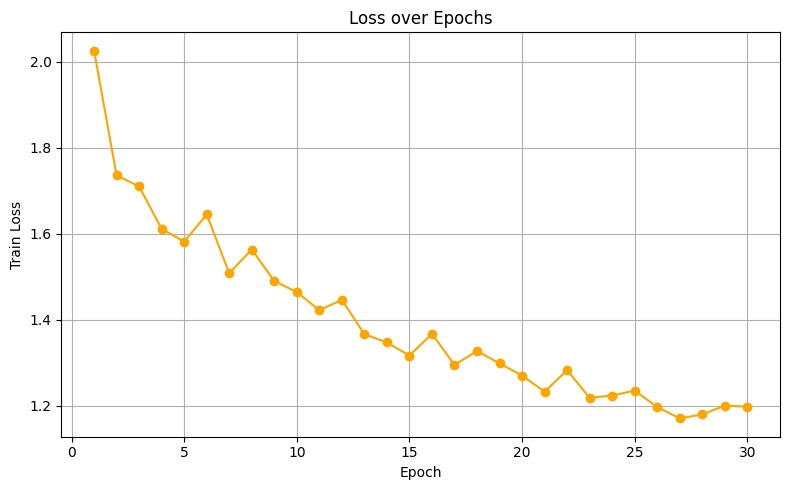

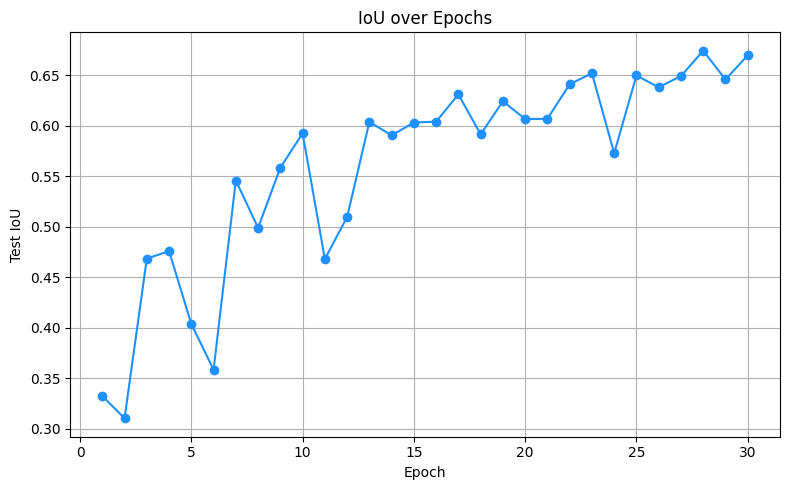

[10/183] Loss: 1.0246 Train Acc: 0.6535
[20/183] Loss: 1.6288 Train Acc: 0.5201
[30/183] Loss: 0.9697 Train Acc: 0.6664
[40/183] Loss: 1.1399 Train Acc: 0.6062
[50/183] Loss: 1.0903 Train Acc: 0.6202
[60/183] Loss: 1.2218 Train Acc: 0.6004
[70/183] Loss: 0.8925 Train Acc: 0.7004
[80/183] Loss: 1.0303 Train Acc: 0.6432
[90/183] Loss: 1.2132 Train Acc: 0.5892
[100/183] Loss: 0.9862 Train Acc: 0.6613
[110/183] Loss: 1.0070 Train Acc: 0.6375
[120/183] Loss: 1.2679 Train Acc: 0.5981
[130/183] Loss: 1.2143 Train Acc: 0.6055
[140/183] Loss: 1.0896 Train Acc: 0.6412
[150/183] Loss: 1.1588 Train Acc: 0.6001
[160/183] Loss: 1.2249 Train Acc: 0.5793
[170/183] Loss: 1.0553 Train Acc: 0.6453
[180/183] Loss: 1.1217 Train Acc: 0.6099
Epoch: 31, Test IoU: 0.6604


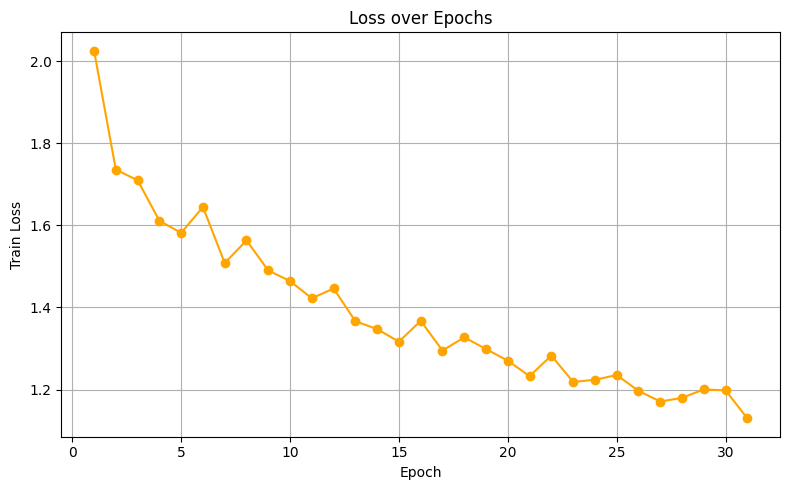

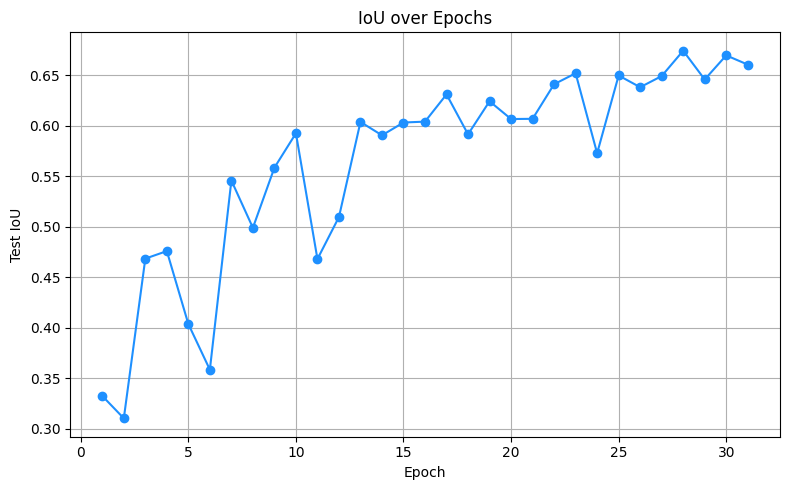

[10/183] Loss: 1.0072 Train Acc: 0.6650
[20/183] Loss: 1.1232 Train Acc: 0.6017
[30/183] Loss: 1.1098 Train Acc: 0.6052
[40/183] Loss: 1.0899 Train Acc: 0.5890
[50/183] Loss: 0.9567 Train Acc: 0.6738
[60/183] Loss: 1.1024 Train Acc: 0.6072
[70/183] Loss: 1.3531 Train Acc: 0.5713
[80/183] Loss: 1.1254 Train Acc: 0.6362
[90/183] Loss: 1.2505 Train Acc: 0.5549
[100/183] Loss: 0.9951 Train Acc: 0.6601
[110/183] Loss: 0.9553 Train Acc: 0.6590
[120/183] Loss: 1.0034 Train Acc: 0.6455
[130/183] Loss: 1.4952 Train Acc: 0.5972
[140/183] Loss: 1.2433 Train Acc: 0.5645
[150/183] Loss: 1.2474 Train Acc: 0.5978
[160/183] Loss: 1.0246 Train Acc: 0.6417
[170/183] Loss: 1.1250 Train Acc: 0.6218
[180/183] Loss: 0.9677 Train Acc: 0.6599
Epoch: 32, Test IoU: 0.6417


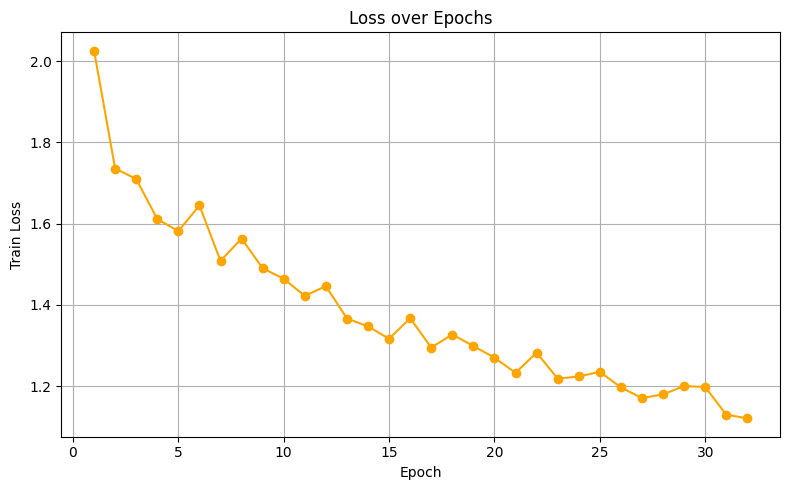

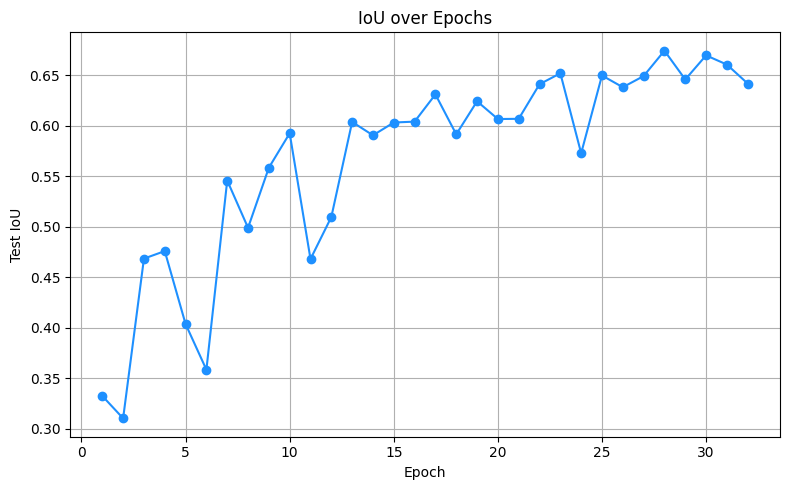

[10/183] Loss: 1.2351 Train Acc: 0.5744
[20/183] Loss: 1.1496 Train Acc: 0.6142
[30/183] Loss: 1.0135 Train Acc: 0.6413
[40/183] Loss: 1.1534 Train Acc: 0.6079
[50/183] Loss: 1.3905 Train Acc: 0.5853
[60/183] Loss: 1.1037 Train Acc: 0.6232
[70/183] Loss: 1.1238 Train Acc: 0.6332
[80/183] Loss: 1.1158 Train Acc: 0.6295
[90/183] Loss: 1.1045 Train Acc: 0.6014
[100/183] Loss: 1.0424 Train Acc: 0.6449
[110/183] Loss: 0.8786 Train Acc: 0.7001
[120/183] Loss: 1.1493 Train Acc: 0.6100
[130/183] Loss: 1.0612 Train Acc: 0.6417
[140/183] Loss: 1.2210 Train Acc: 0.6064
[150/183] Loss: 1.2012 Train Acc: 0.5711
[160/183] Loss: 1.0707 Train Acc: 0.6443
[170/183] Loss: 1.1475 Train Acc: 0.6219
[180/183] Loss: 1.1056 Train Acc: 0.6049
Epoch: 33, Test IoU: 0.6617


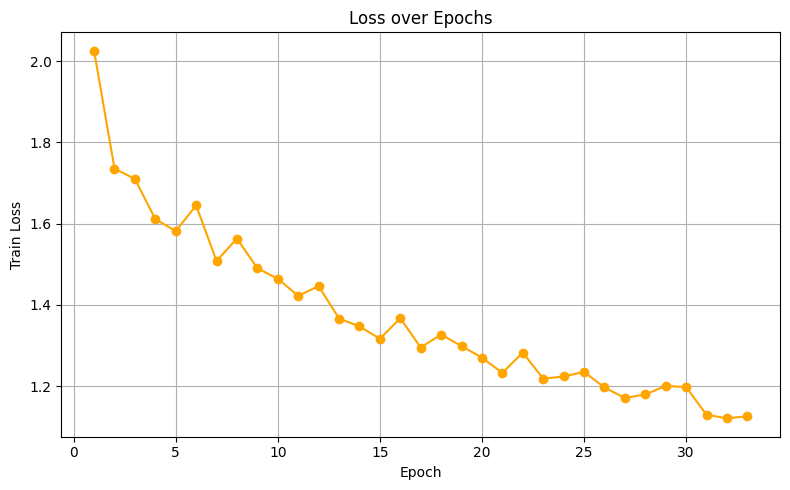

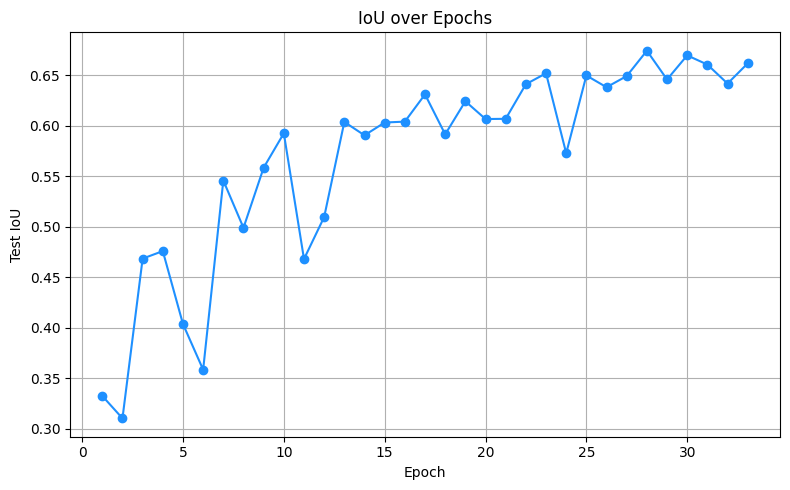

[10/183] Loss: 1.1531 Train Acc: 0.5923
[20/183] Loss: 1.3047 Train Acc: 0.5667
[30/183] Loss: 1.2725 Train Acc: 0.5603
[40/183] Loss: 1.1933 Train Acc: 0.5937
[50/183] Loss: 1.2224 Train Acc: 0.5925
[60/183] Loss: 1.2885 Train Acc: 0.5607
[70/183] Loss: 1.1044 Train Acc: 0.6220
[80/183] Loss: 1.0588 Train Acc: 0.6416
[90/183] Loss: 1.0220 Train Acc: 0.6712
[100/183] Loss: 1.1183 Train Acc: 0.6406
[110/183] Loss: 1.2484 Train Acc: 0.5864
[120/183] Loss: 1.1826 Train Acc: 0.5948
[130/183] Loss: 1.0492 Train Acc: 0.6508
[140/183] Loss: 0.9172 Train Acc: 0.6843
[150/183] Loss: 1.2323 Train Acc: 0.5838
[160/183] Loss: 1.2822 Train Acc: 0.6087
[170/183] Loss: 1.2134 Train Acc: 0.5805
[180/183] Loss: 0.9990 Train Acc: 0.6559
Epoch: 34, Test IoU: 0.6377


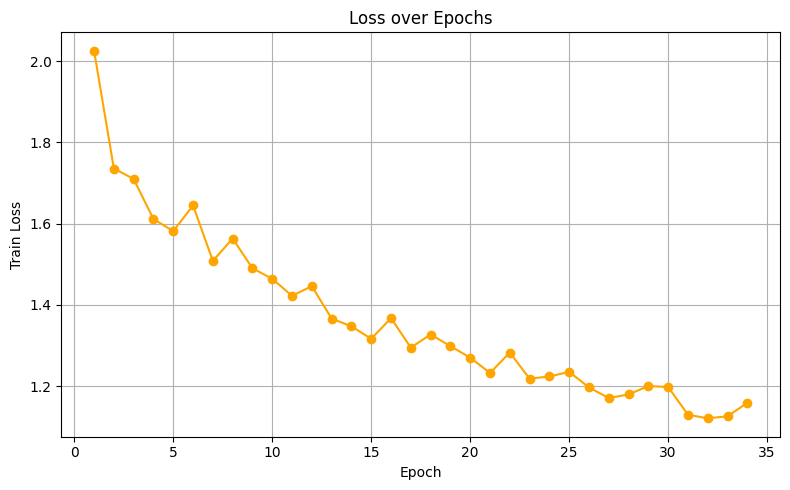

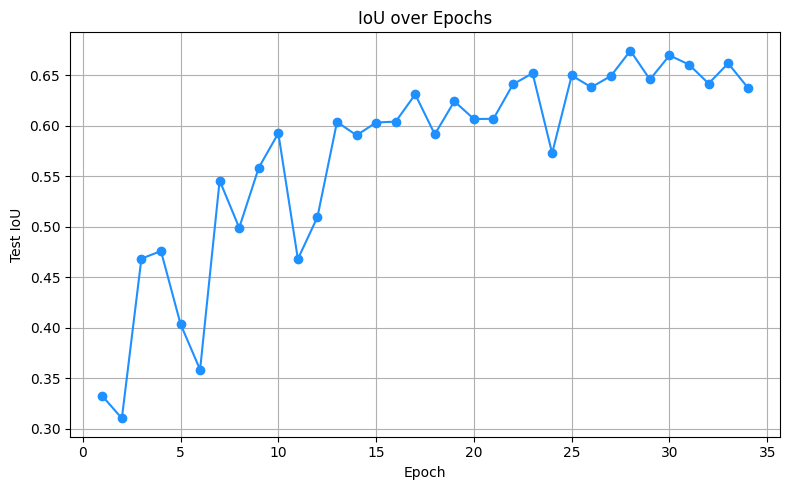

[10/183] Loss: 0.9717 Train Acc: 0.6732
[20/183] Loss: 1.1689 Train Acc: 0.5919
[30/183] Loss: 1.1104 Train Acc: 0.6462
[40/183] Loss: 0.9394 Train Acc: 0.6823
[50/183] Loss: 1.0697 Train Acc: 0.6233
[60/183] Loss: 1.0585 Train Acc: 0.6370
[70/183] Loss: 1.3564 Train Acc: 0.5830
[80/183] Loss: 1.1551 Train Acc: 0.5937
[90/183] Loss: 1.3154 Train Acc: 0.5773
[100/183] Loss: 1.1607 Train Acc: 0.5660
[110/183] Loss: 1.0172 Train Acc: 0.6394
[120/183] Loss: 1.1604 Train Acc: 0.6052
[130/183] Loss: 1.2805 Train Acc: 0.5838
[140/183] Loss: 1.2228 Train Acc: 0.5755
[150/183] Loss: 1.1654 Train Acc: 0.5988
[160/183] Loss: 1.0390 Train Acc: 0.6507
[170/183] Loss: 1.3633 Train Acc: 0.5695
[180/183] Loss: 1.1880 Train Acc: 0.6203
Epoch: 35, Test IoU: 0.6676


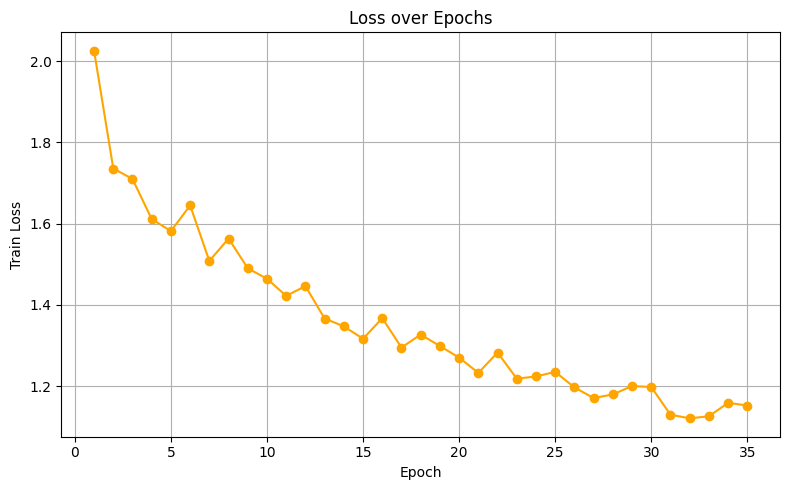

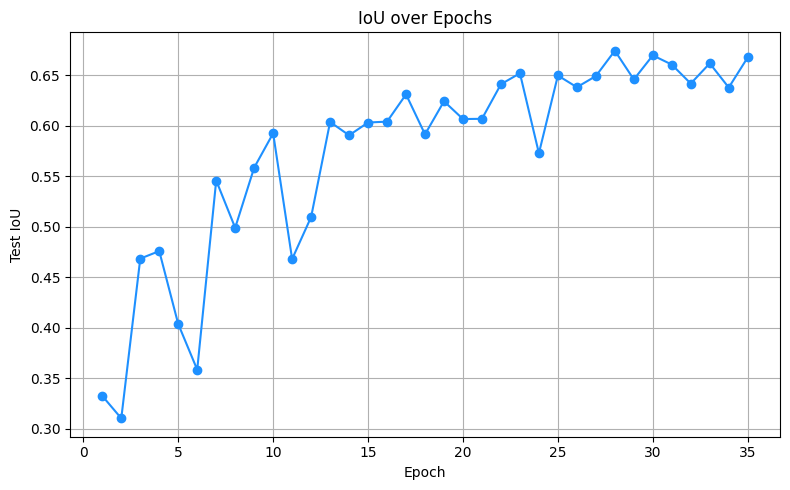

[10/183] Loss: 1.0863 Train Acc: 0.6420
[20/183] Loss: 1.0964 Train Acc: 0.6230
[30/183] Loss: 1.1677 Train Acc: 0.6140
[40/183] Loss: 1.0983 Train Acc: 0.6150
[50/183] Loss: 1.2941 Train Acc: 0.5842
[60/183] Loss: 1.2034 Train Acc: 0.6154
[70/183] Loss: 1.1421 Train Acc: 0.6311
[80/183] Loss: 1.1704 Train Acc: 0.6096
[90/183] Loss: 1.0708 Train Acc: 0.6429
[100/183] Loss: 1.2483 Train Acc: 0.5868
[110/183] Loss: 1.1090 Train Acc: 0.6081
[120/183] Loss: 1.1404 Train Acc: 0.6062
[130/183] Loss: 1.1090 Train Acc: 0.6155
[140/183] Loss: 1.0391 Train Acc: 0.6332
[150/183] Loss: 1.3794 Train Acc: 0.6095
[160/183] Loss: 1.1521 Train Acc: 0.6040
[170/183] Loss: 1.2211 Train Acc: 0.5770
[180/183] Loss: 1.1150 Train Acc: 0.6129
Epoch: 36, Test IoU: 0.6373


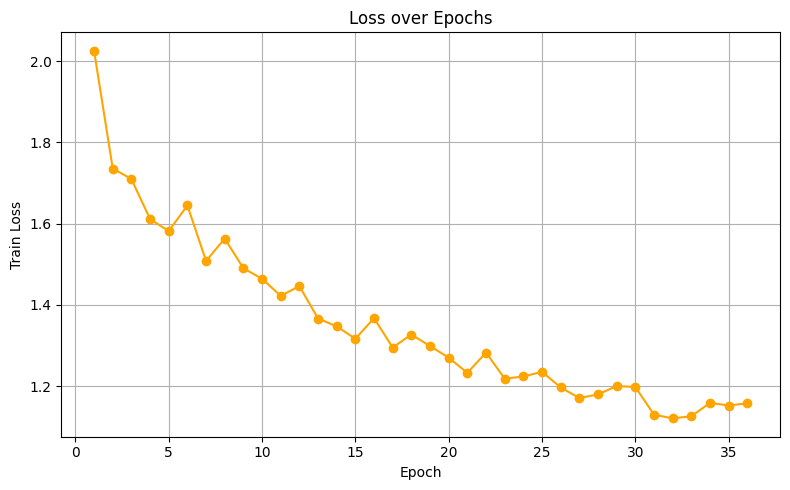

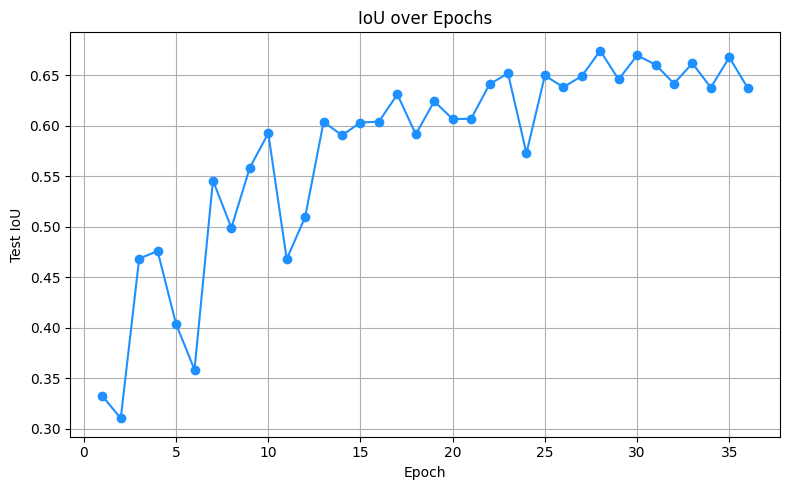

[10/183] Loss: 1.1312 Train Acc: 0.6219
[20/183] Loss: 1.3090 Train Acc: 0.5546
[30/183] Loss: 1.1204 Train Acc: 0.6219
[40/183] Loss: 1.1985 Train Acc: 0.6097
[50/183] Loss: 0.9910 Train Acc: 0.6624
[60/183] Loss: 1.2042 Train Acc: 0.5953
[70/183] Loss: 1.1964 Train Acc: 0.6332
[80/183] Loss: 1.1342 Train Acc: 0.6261
[90/183] Loss: 1.0483 Train Acc: 0.6190
[100/183] Loss: 1.3335 Train Acc: 0.5557
[110/183] Loss: 0.9589 Train Acc: 0.6775
[120/183] Loss: 1.0941 Train Acc: 0.6397
[130/183] Loss: 0.9854 Train Acc: 0.6494
[140/183] Loss: 1.0673 Train Acc: 0.6145
[150/183] Loss: 1.2233 Train Acc: 0.5560
[160/183] Loss: 1.1126 Train Acc: 0.6126
[170/183] Loss: 1.0833 Train Acc: 0.6097
[180/183] Loss: 1.1471 Train Acc: 0.6061
Epoch: 37, Test IoU: 0.6506


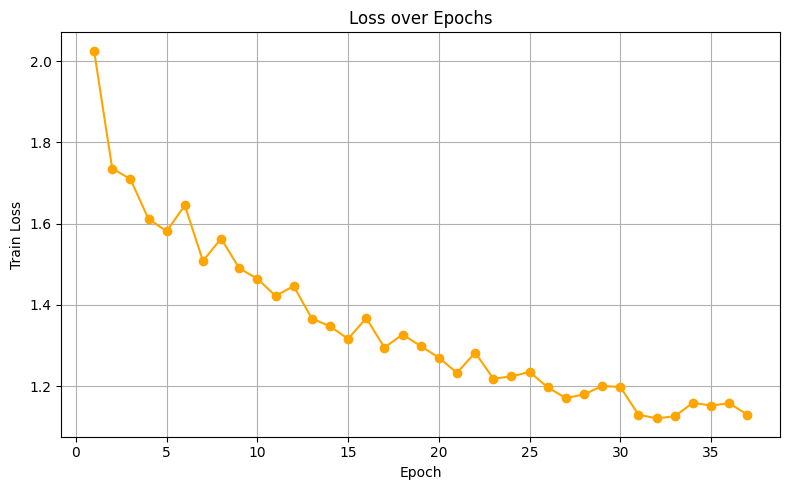

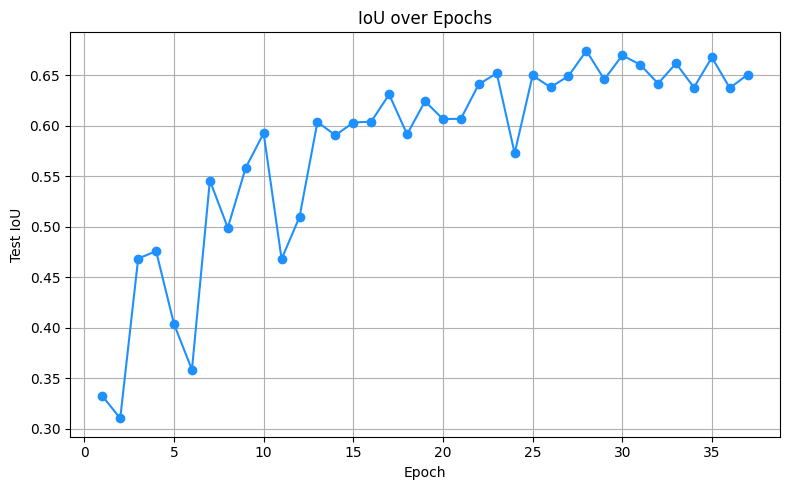

[10/183] Loss: 0.9231 Train Acc: 0.6933
[20/183] Loss: 1.1573 Train Acc: 0.5523
[30/183] Loss: 0.9922 Train Acc: 0.6590
[40/183] Loss: 1.1488 Train Acc: 0.6226
[50/183] Loss: 0.9281 Train Acc: 0.6652
[60/183] Loss: 0.9027 Train Acc: 0.6700
[70/183] Loss: 1.2402 Train Acc: 0.5999
[80/183] Loss: 1.1156 Train Acc: 0.6195
[90/183] Loss: 1.0747 Train Acc: 0.6616
[100/183] Loss: 1.3173 Train Acc: 0.5712
[110/183] Loss: 1.3110 Train Acc: 0.5965
[120/183] Loss: 1.3675 Train Acc: 0.5765
[130/183] Loss: 1.0423 Train Acc: 0.6449
[140/183] Loss: 1.0295 Train Acc: 0.6404
[150/183] Loss: 1.0900 Train Acc: 0.6256
[160/183] Loss: 1.1738 Train Acc: 0.6017
[170/183] Loss: 1.0521 Train Acc: 0.6677
[180/183] Loss: 1.0435 Train Acc: 0.6455
Epoch: 38, Test IoU: 0.6788


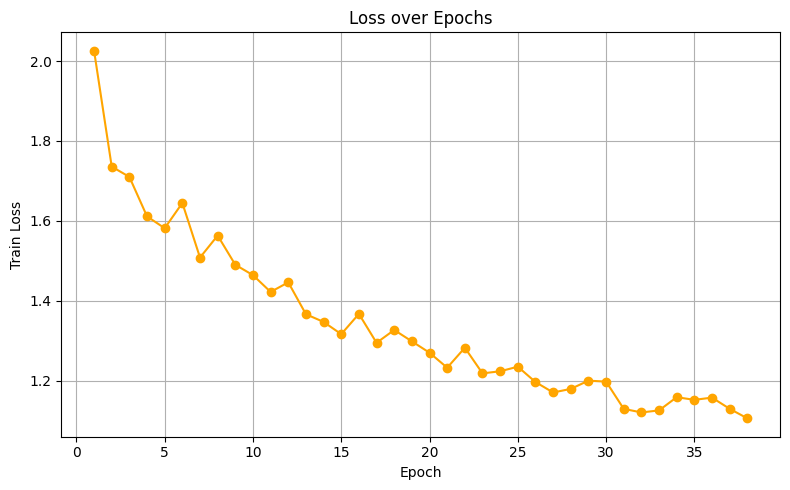

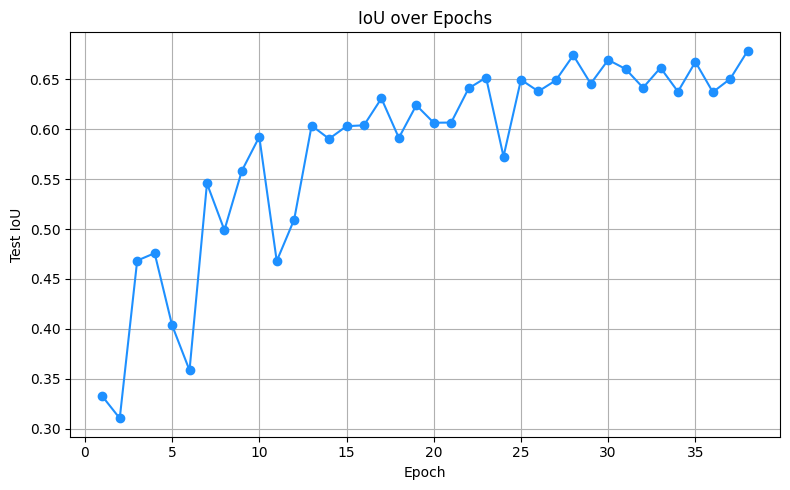

  >> Best model saved at epoch 38 with IoU: 0.6788
[10/183] Loss: 1.1686 Train Acc: 0.5976
[20/183] Loss: 1.0776 Train Acc: 0.6186
[30/183] Loss: 0.9864 Train Acc: 0.6552
[40/183] Loss: 1.0017 Train Acc: 0.6523
[50/183] Loss: 0.9838 Train Acc: 0.6666
[60/183] Loss: 1.3540 Train Acc: 0.5736
[70/183] Loss: 0.9316 Train Acc: 0.6846
[80/183] Loss: 0.8869 Train Acc: 0.7044
[90/183] Loss: 0.8995 Train Acc: 0.6919
[100/183] Loss: 1.0733 Train Acc: 0.6242
[110/183] Loss: 0.9822 Train Acc: 0.6372
[120/183] Loss: 1.0817 Train Acc: 0.6267
[130/183] Loss: 1.1063 Train Acc: 0.6286
[140/183] Loss: 1.0943 Train Acc: 0.6292
[150/183] Loss: 1.1285 Train Acc: 0.5988
[160/183] Loss: 0.9714 Train Acc: 0.6842
[170/183] Loss: 1.0422 Train Acc: 0.6291
[180/183] Loss: 1.1303 Train Acc: 0.6566
Epoch: 39, Test IoU: 0.6663


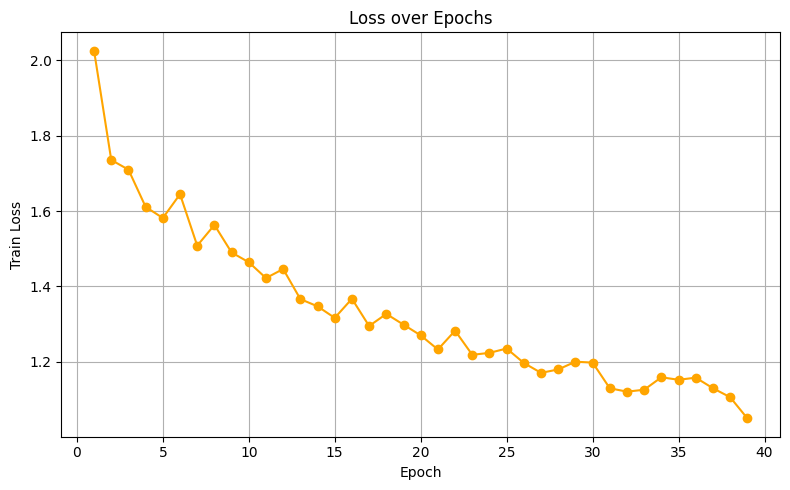

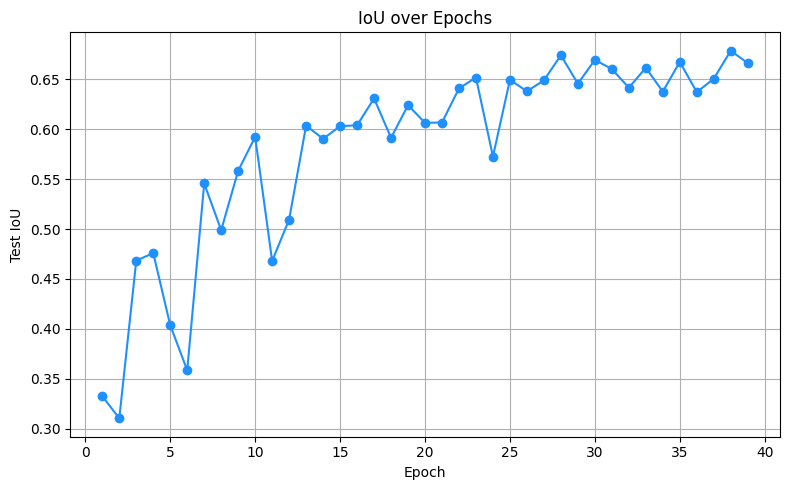

[10/183] Loss: 0.9713 Train Acc: 0.6888
[20/183] Loss: 1.1502 Train Acc: 0.6321
[30/183] Loss: 1.0453 Train Acc: 0.6541
[40/183] Loss: 0.9787 Train Acc: 0.6766
[50/183] Loss: 1.0628 Train Acc: 0.6399
[60/183] Loss: 1.1872 Train Acc: 0.5934
[70/183] Loss: 0.9207 Train Acc: 0.6696
[80/183] Loss: 1.0047 Train Acc: 0.6440
[90/183] Loss: 1.0512 Train Acc: 0.6298
[100/183] Loss: 0.8186 Train Acc: 0.7048
[110/183] Loss: 1.1380 Train Acc: 0.6281
[120/183] Loss: 1.2088 Train Acc: 0.6136
[130/183] Loss: 1.4242 Train Acc: 0.5783
[140/183] Loss: 1.4291 Train Acc: 0.5351
[150/183] Loss: 1.5175 Train Acc: 0.5284
[160/183] Loss: 1.2430 Train Acc: 0.5822
[170/183] Loss: 0.9715 Train Acc: 0.6609
[180/183] Loss: 1.1080 Train Acc: 0.6276
Epoch: 40, Test IoU: 0.6619


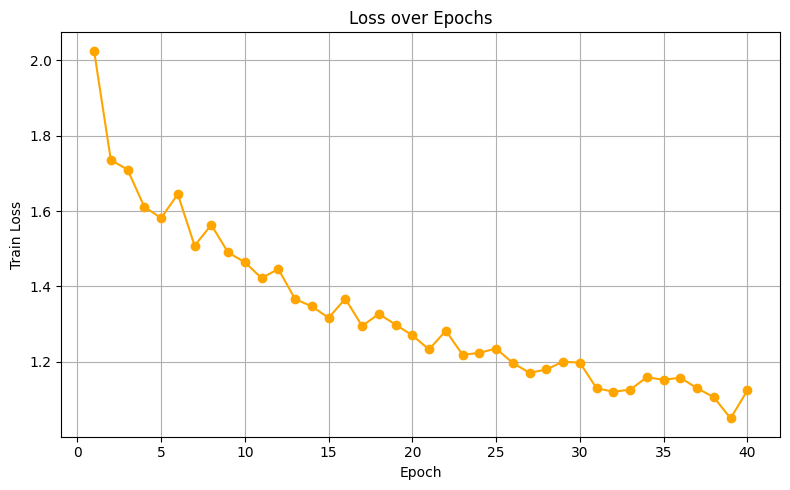

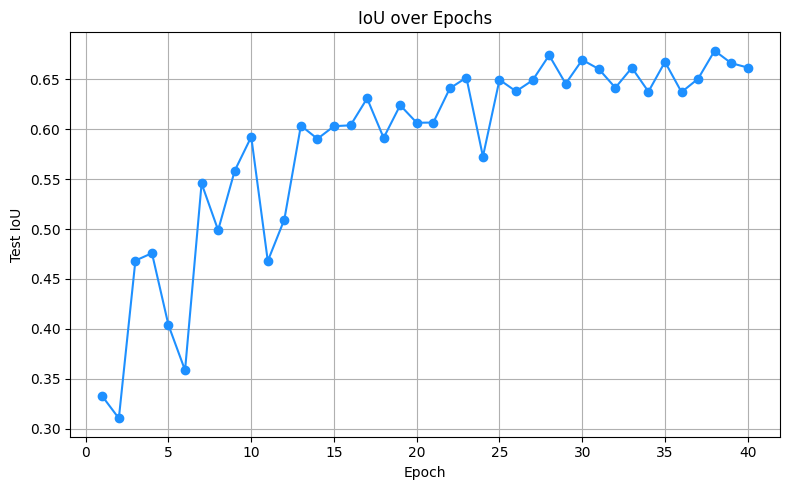

[10/183] Loss: 1.0262 Train Acc: 0.6492
[20/183] Loss: 1.2753 Train Acc: 0.6164
[30/183] Loss: 1.1026 Train Acc: 0.6045
[40/183] Loss: 1.1552 Train Acc: 0.5999
[50/183] Loss: 1.0828 Train Acc: 0.6289
[60/183] Loss: 0.9162 Train Acc: 0.6862
[70/183] Loss: 0.8826 Train Acc: 0.6980
[80/183] Loss: 1.0160 Train Acc: 0.6142
[90/183] Loss: 1.1136 Train Acc: 0.6259
[100/183] Loss: 1.4154 Train Acc: 0.5422
[110/183] Loss: 1.1687 Train Acc: 0.6155
[120/183] Loss: 0.9771 Train Acc: 0.6656
[130/183] Loss: 0.8825 Train Acc: 0.6871
[140/183] Loss: 1.0228 Train Acc: 0.6390
[150/183] Loss: 0.9712 Train Acc: 0.6870
[160/183] Loss: 0.9747 Train Acc: 0.6366
[170/183] Loss: 0.8925 Train Acc: 0.6975
[180/183] Loss: 1.3634 Train Acc: 0.5803
Epoch: 41, Test IoU: 0.5575


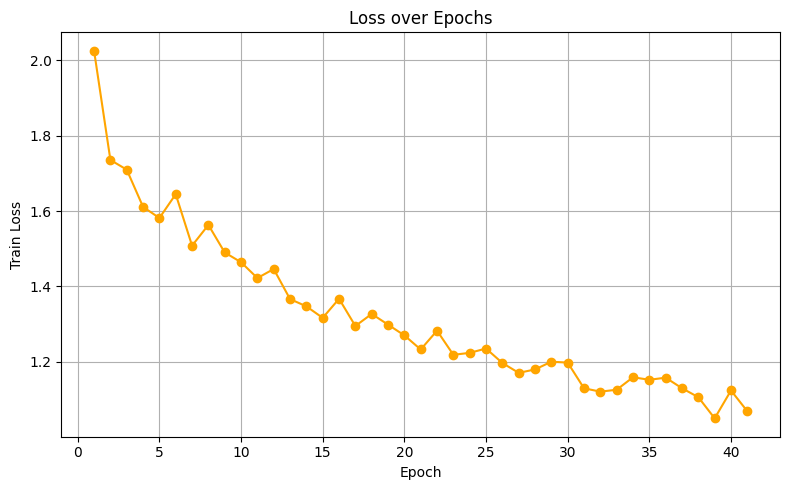

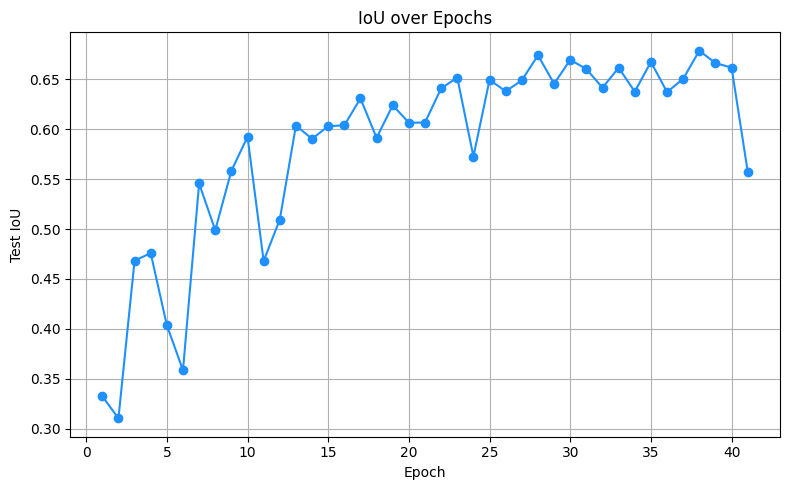

[10/183] Loss: 1.3105 Train Acc: 0.5466
[20/183] Loss: 1.1433 Train Acc: 0.6252
[30/183] Loss: 1.2142 Train Acc: 0.6025
[40/183] Loss: 1.0087 Train Acc: 0.6486
[50/183] Loss: 1.1176 Train Acc: 0.6016
[60/183] Loss: 1.0034 Train Acc: 0.6493
[70/183] Loss: 1.0940 Train Acc: 0.6357
[80/183] Loss: 0.9368 Train Acc: 0.6634
[90/183] Loss: 0.9842 Train Acc: 0.6547
[100/183] Loss: 1.1163 Train Acc: 0.6336
[110/183] Loss: 1.1331 Train Acc: 0.6202
[120/183] Loss: 0.9631 Train Acc: 0.7028
[130/183] Loss: 0.9499 Train Acc: 0.6467
[140/183] Loss: 1.3282 Train Acc: 0.5587
[150/183] Loss: 1.1090 Train Acc: 0.6366
[160/183] Loss: 1.1445 Train Acc: 0.6047
[170/183] Loss: 0.9287 Train Acc: 0.6832
[180/183] Loss: 0.8984 Train Acc: 0.6857
Epoch: 42, Test IoU: 0.6571


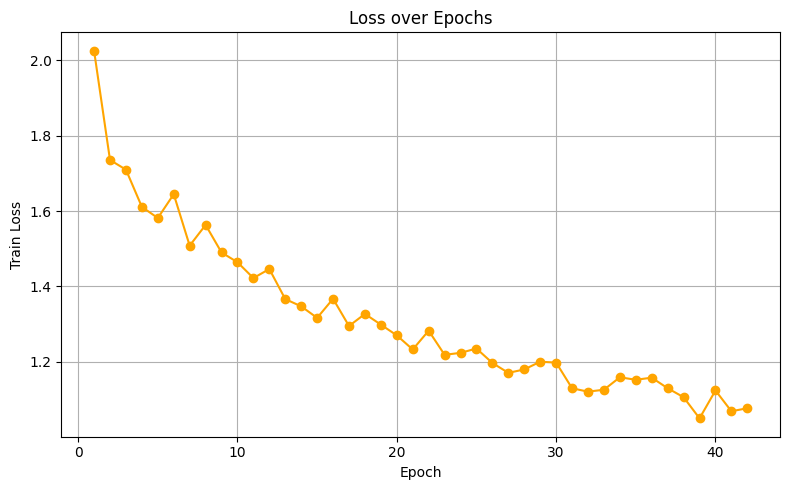

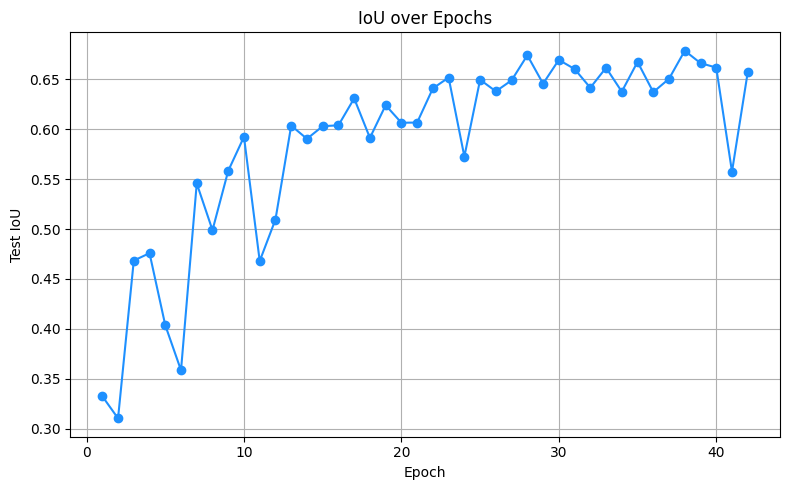

[10/183] Loss: 1.0089 Train Acc: 0.6510
[20/183] Loss: 1.0236 Train Acc: 0.6402
[30/183] Loss: 0.9399 Train Acc: 0.6747
[40/183] Loss: 1.1181 Train Acc: 0.6151
[50/183] Loss: 1.0681 Train Acc: 0.6285
[60/183] Loss: 1.0031 Train Acc: 0.6879
[70/183] Loss: 1.1461 Train Acc: 0.6075
[80/183] Loss: 1.4147 Train Acc: 0.5322
[90/183] Loss: 1.0249 Train Acc: 0.6508
[100/183] Loss: 1.1866 Train Acc: 0.6044
[110/183] Loss: 1.2421 Train Acc: 0.6217
[120/183] Loss: 1.3080 Train Acc: 0.5615
[130/183] Loss: 1.0537 Train Acc: 0.6359
[140/183] Loss: 1.1003 Train Acc: 0.6367
[150/183] Loss: 0.8969 Train Acc: 0.6882
[160/183] Loss: 1.1884 Train Acc: 0.6095
[170/183] Loss: 0.9086 Train Acc: 0.6931
[180/183] Loss: 0.9458 Train Acc: 0.6558
Epoch: 43, Test IoU: 0.6175


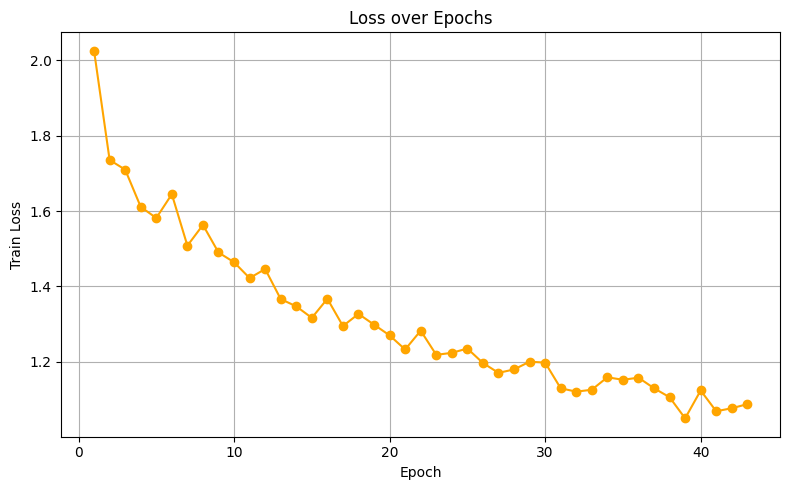

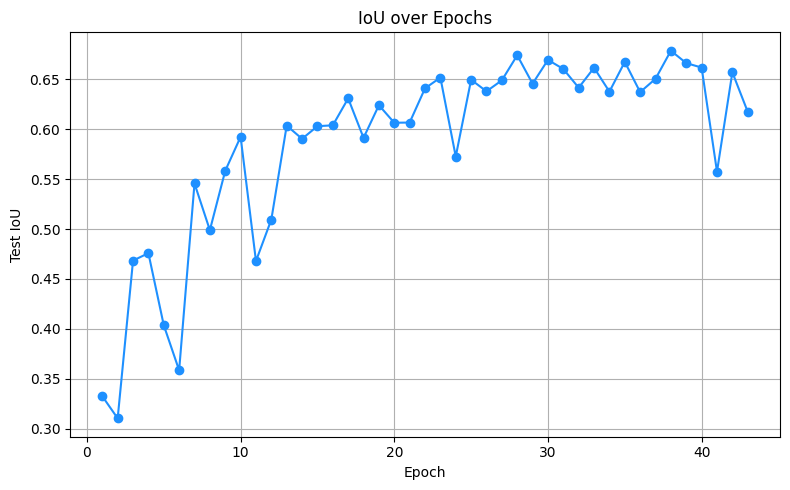

[10/183] Loss: 0.9017 Train Acc: 0.6859
[20/183] Loss: 0.9671 Train Acc: 0.6491
[30/183] Loss: 1.0477 Train Acc: 0.6305
[40/183] Loss: 0.9310 Train Acc: 0.6468
[50/183] Loss: 1.1438 Train Acc: 0.6128
[60/183] Loss: 1.1348 Train Acc: 0.6093
[70/183] Loss: 1.1825 Train Acc: 0.5976
[80/183] Loss: 0.9917 Train Acc: 0.6583
[90/183] Loss: 0.9998 Train Acc: 0.6463
[100/183] Loss: 0.9497 Train Acc: 0.6676
[110/183] Loss: 1.1682 Train Acc: 0.6280
[120/183] Loss: 1.5149 Train Acc: 0.5488
[130/183] Loss: 1.2660 Train Acc: 0.5669
[140/183] Loss: 0.9949 Train Acc: 0.6528
[150/183] Loss: 1.1890 Train Acc: 0.6225
[160/183] Loss: 1.3066 Train Acc: 0.5536
[170/183] Loss: 0.9969 Train Acc: 0.6705
[180/183] Loss: 1.0208 Train Acc: 0.6329
Epoch: 44, Test IoU: 0.6141


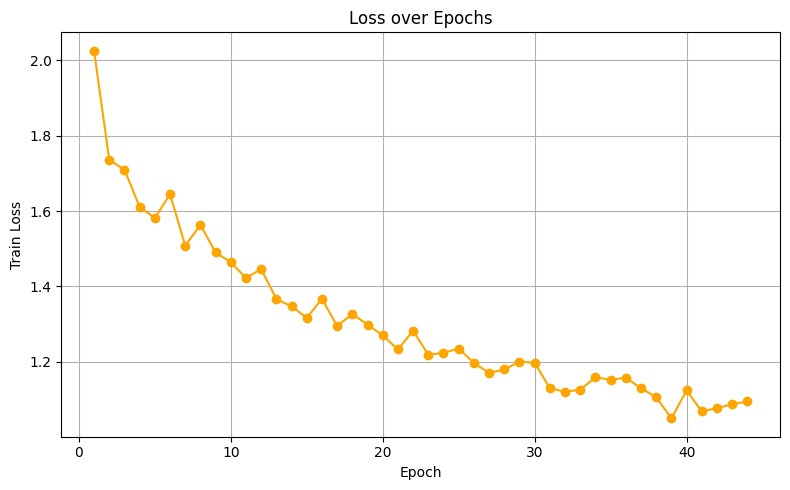

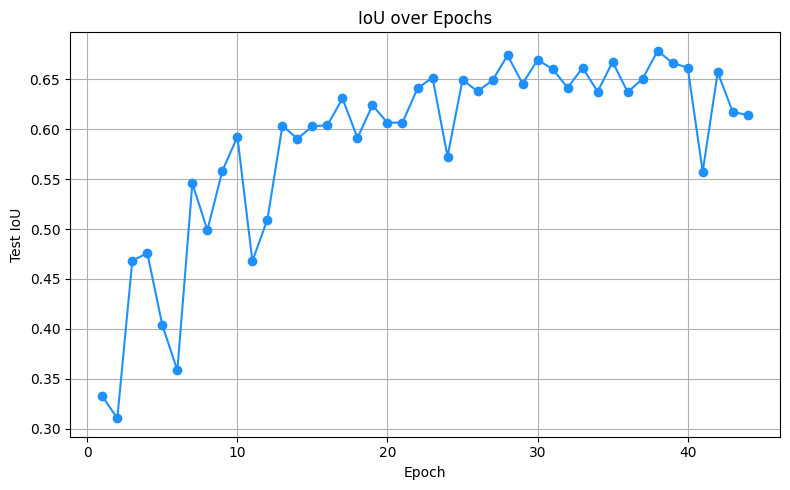

[10/183] Loss: 1.2411 Train Acc: 0.5959
[20/183] Loss: 1.3166 Train Acc: 0.5447
[30/183] Loss: 1.0588 Train Acc: 0.6335
[40/183] Loss: 1.2374 Train Acc: 0.5681
[50/183] Loss: 1.1737 Train Acc: 0.6231
[60/183] Loss: 0.9138 Train Acc: 0.6854
[70/183] Loss: 0.8479 Train Acc: 0.6937
[80/183] Loss: 1.1200 Train Acc: 0.6215
[90/183] Loss: 0.9849 Train Acc: 0.6875
[100/183] Loss: 1.0727 Train Acc: 0.6043
[110/183] Loss: 1.0872 Train Acc: 0.6578
[120/183] Loss: 1.2530 Train Acc: 0.5642
[130/183] Loss: 1.0398 Train Acc: 0.6336
[140/183] Loss: 0.8754 Train Acc: 0.6757
[150/183] Loss: 1.0170 Train Acc: 0.6414
[160/183] Loss: 0.8552 Train Acc: 0.6883
[170/183] Loss: 1.2641 Train Acc: 0.5680
[180/183] Loss: 1.0643 Train Acc: 0.6289
Epoch: 45, Test IoU: 0.6370


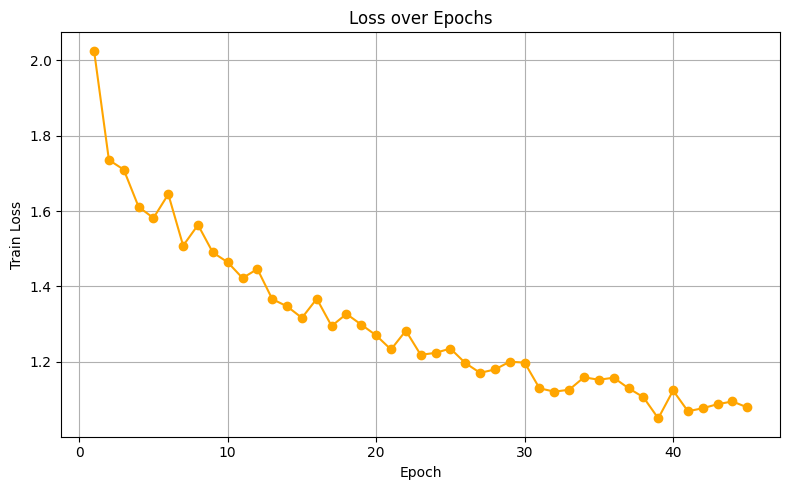

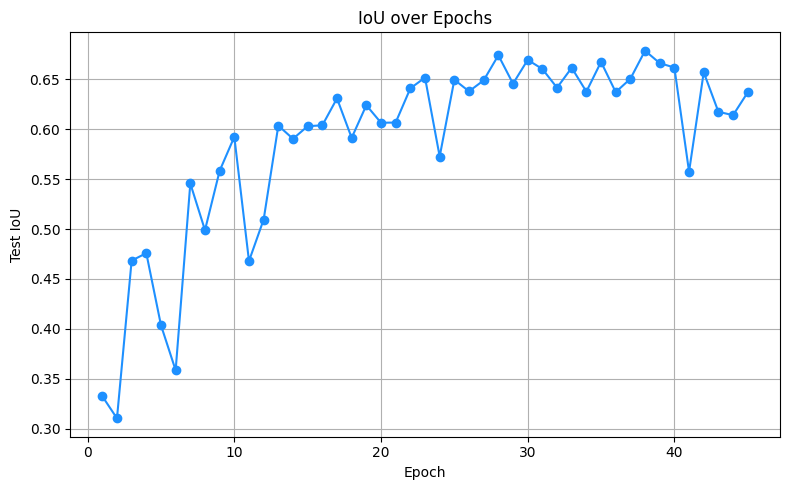

[10/183] Loss: 0.9526 Train Acc: 0.6619
[20/183] Loss: 1.0315 Train Acc: 0.6352
[30/183] Loss: 1.4242 Train Acc: 0.5768
[40/183] Loss: 0.8770 Train Acc: 0.7047
[50/183] Loss: 1.2485 Train Acc: 0.6099
[60/183] Loss: 1.1963 Train Acc: 0.5925
[70/183] Loss: 1.0072 Train Acc: 0.6501
[80/183] Loss: 1.3616 Train Acc: 0.6116
[90/183] Loss: 1.1171 Train Acc: 0.6091
[100/183] Loss: 1.1857 Train Acc: 0.6097
[110/183] Loss: 0.9158 Train Acc: 0.6684
[120/183] Loss: 0.9430 Train Acc: 0.6794
[130/183] Loss: 0.8624 Train Acc: 0.6803
[140/183] Loss: 0.9889 Train Acc: 0.6609
[150/183] Loss: 1.1320 Train Acc: 0.6371
[160/183] Loss: 0.9576 Train Acc: 0.6568
[170/183] Loss: 0.8542 Train Acc: 0.6952
[180/183] Loss: 0.9289 Train Acc: 0.6623
Epoch: 46, Test IoU: 0.6756


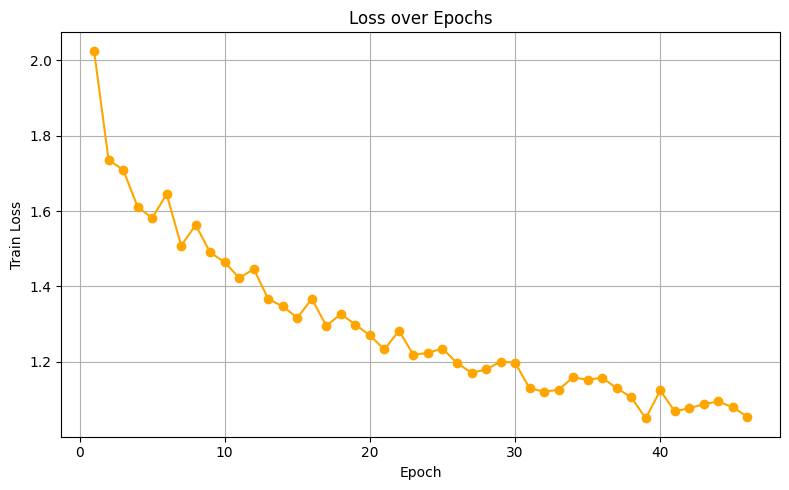

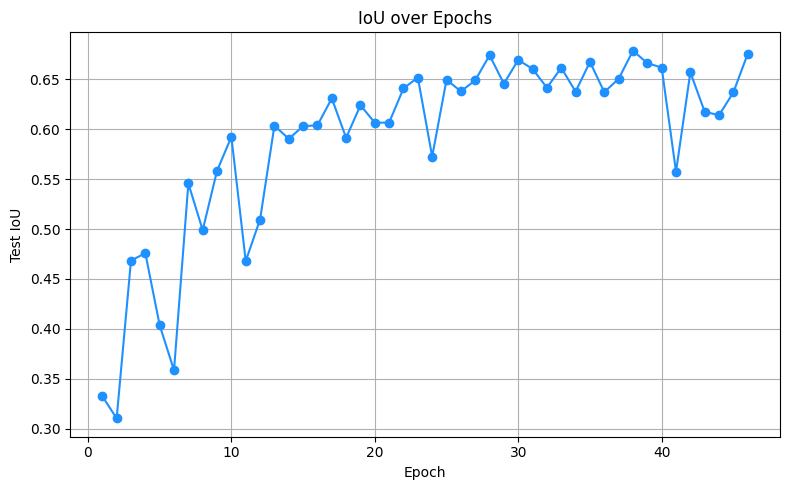

[10/183] Loss: 1.1235 Train Acc: 0.6259
[20/183] Loss: 0.9478 Train Acc: 0.6411
[30/183] Loss: 1.0758 Train Acc: 0.6474
[40/183] Loss: 1.0129 Train Acc: 0.6404
[50/183] Loss: 0.9742 Train Acc: 0.6443
[60/183] Loss: 0.8586 Train Acc: 0.6882
[70/183] Loss: 0.9159 Train Acc: 0.6750
[80/183] Loss: 0.8670 Train Acc: 0.6914
[90/183] Loss: 0.9491 Train Acc: 0.7127
[100/183] Loss: 1.0941 Train Acc: 0.6330
[110/183] Loss: 0.9721 Train Acc: 0.6728
[120/183] Loss: 0.9367 Train Acc: 0.6727
[130/183] Loss: 1.0646 Train Acc: 0.6166
[140/183] Loss: 1.0460 Train Acc: 0.6381
[150/183] Loss: 1.0117 Train Acc: 0.6459
[160/183] Loss: 0.8914 Train Acc: 0.6882
[170/183] Loss: 0.8057 Train Acc: 0.7004
[180/183] Loss: 0.9788 Train Acc: 0.6657
Epoch: 47, Test IoU: 0.6611


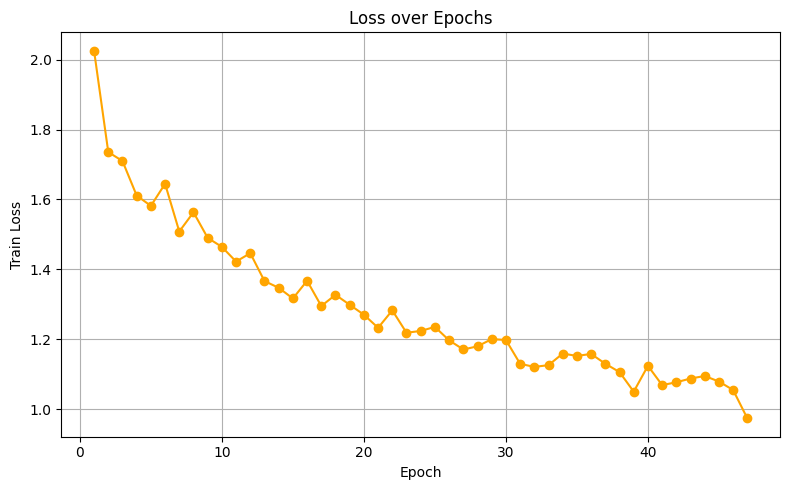

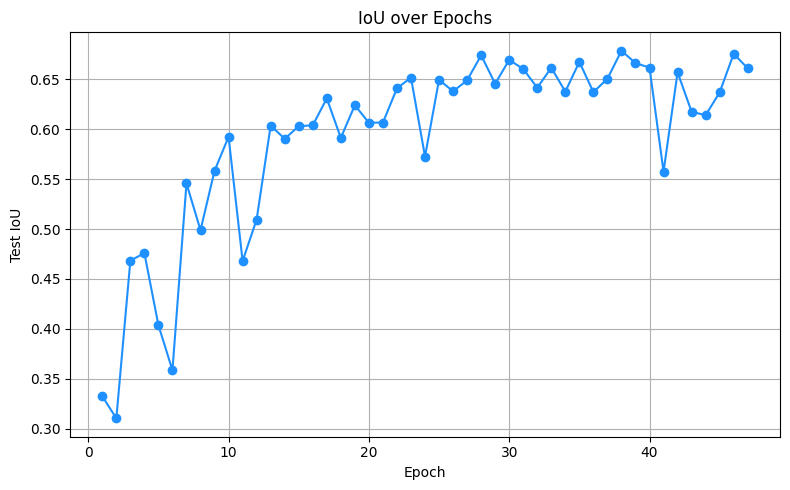

[10/183] Loss: 0.8206 Train Acc: 0.7278
[20/183] Loss: 0.8535 Train Acc: 0.6916
[30/183] Loss: 0.9129 Train Acc: 0.6796
[40/183] Loss: 1.0403 Train Acc: 0.6511
[50/183] Loss: 0.8156 Train Acc: 0.7205
[60/183] Loss: 1.0715 Train Acc: 0.6397
[70/183] Loss: 0.9796 Train Acc: 0.6587
[80/183] Loss: 0.9942 Train Acc: 0.6524
[90/183] Loss: 0.9904 Train Acc: 0.6768
[100/183] Loss: 1.0306 Train Acc: 0.6196
[110/183] Loss: 1.0298 Train Acc: 0.6622
[120/183] Loss: 0.9973 Train Acc: 0.6464
[130/183] Loss: 0.9946 Train Acc: 0.6546
[140/183] Loss: 1.0942 Train Acc: 0.6263
[150/183] Loss: 1.1136 Train Acc: 0.6556
[160/183] Loss: 1.4753 Train Acc: 0.5800
[170/183] Loss: 0.9905 Train Acc: 0.6650
[180/183] Loss: 1.0990 Train Acc: 0.6278
Epoch: 48, Test IoU: 0.6503


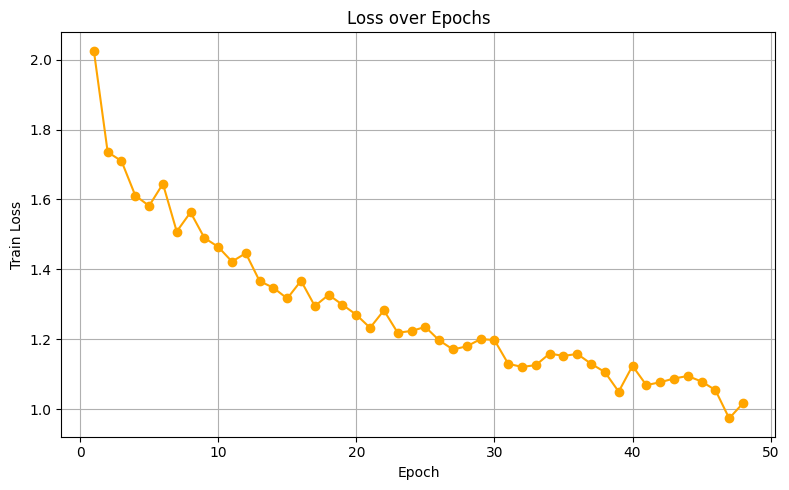

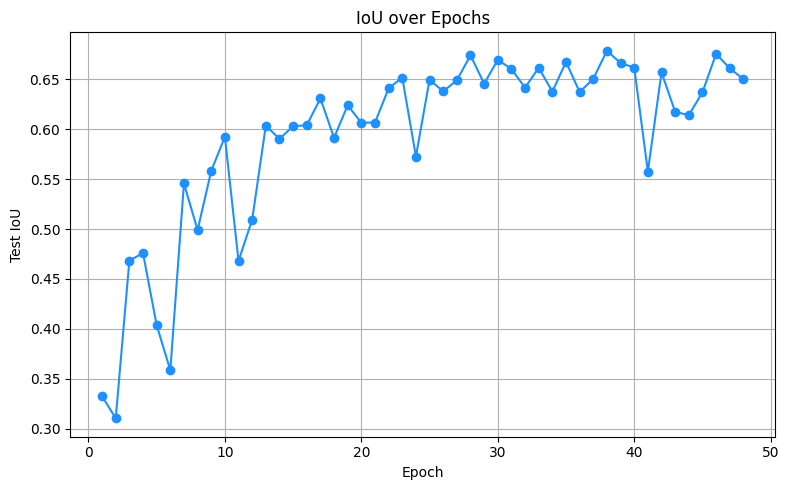

[10/183] Loss: 1.1695 Train Acc: 0.6028
[20/183] Loss: 0.9684 Train Acc: 0.6400
[30/183] Loss: 0.9615 Train Acc: 0.6605
[40/183] Loss: 0.9958 Train Acc: 0.6463
[50/183] Loss: 1.2105 Train Acc: 0.6012
[60/183] Loss: 0.9102 Train Acc: 0.6862
[70/183] Loss: 0.8836 Train Acc: 0.6704
[80/183] Loss: 1.0221 Train Acc: 0.6302
[90/183] Loss: 0.9691 Train Acc: 0.6937
[100/183] Loss: 0.8202 Train Acc: 0.7008
[110/183] Loss: 0.8542 Train Acc: 0.6991
[120/183] Loss: 0.8328 Train Acc: 0.6982
[130/183] Loss: 0.8785 Train Acc: 0.6568
[140/183] Loss: 0.9869 Train Acc: 0.6309
[150/183] Loss: 1.0893 Train Acc: 0.6703
[160/183] Loss: 1.0216 Train Acc: 0.6383
[170/183] Loss: 0.9594 Train Acc: 0.6712
[180/183] Loss: 1.0567 Train Acc: 0.6171
Epoch: 49, Test IoU: 0.6424


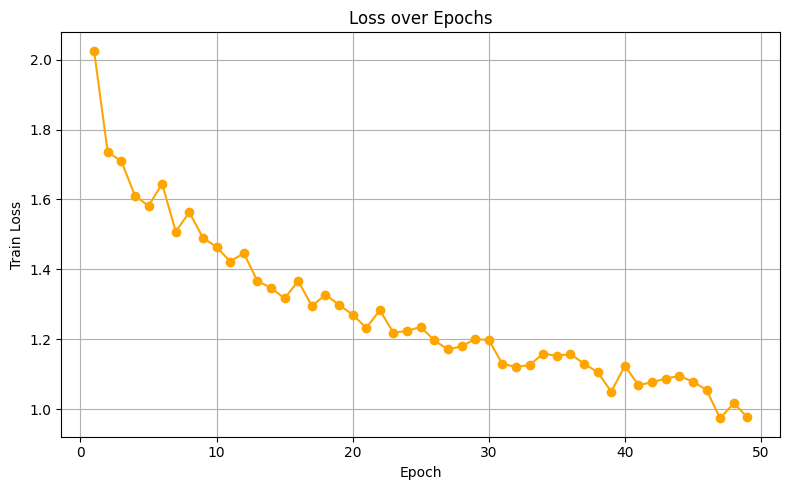

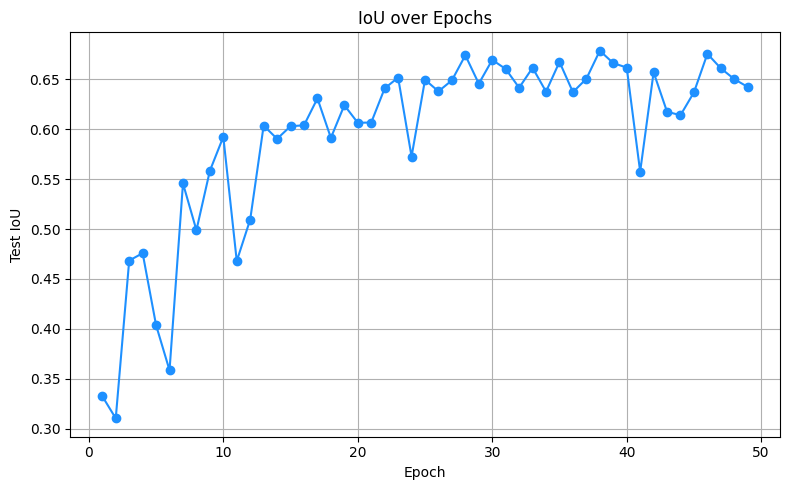

[10/183] Loss: 1.1746 Train Acc: 0.6411
[20/183] Loss: 0.9079 Train Acc: 0.6957
[30/183] Loss: 0.9912 Train Acc: 0.6799
[40/183] Loss: 0.8928 Train Acc: 0.6737
[50/183] Loss: 1.0679 Train Acc: 0.6301
[60/183] Loss: 0.9675 Train Acc: 0.6524
[70/183] Loss: 1.2765 Train Acc: 0.5794
[80/183] Loss: 0.9874 Train Acc: 0.6897
[90/183] Loss: 0.9474 Train Acc: 0.6957
[100/183] Loss: 1.0205 Train Acc: 0.6440
[110/183] Loss: 1.1765 Train Acc: 0.5934
[120/183] Loss: 0.9266 Train Acc: 0.6622
[130/183] Loss: 1.0652 Train Acc: 0.6284
[140/183] Loss: 1.0499 Train Acc: 0.6408
[150/183] Loss: 1.1214 Train Acc: 0.6052
[160/183] Loss: 0.8134 Train Acc: 0.6955
[170/183] Loss: 1.0961 Train Acc: 0.6152
[180/183] Loss: 0.9291 Train Acc: 0.6707
Epoch: 50, Test IoU: 0.6493


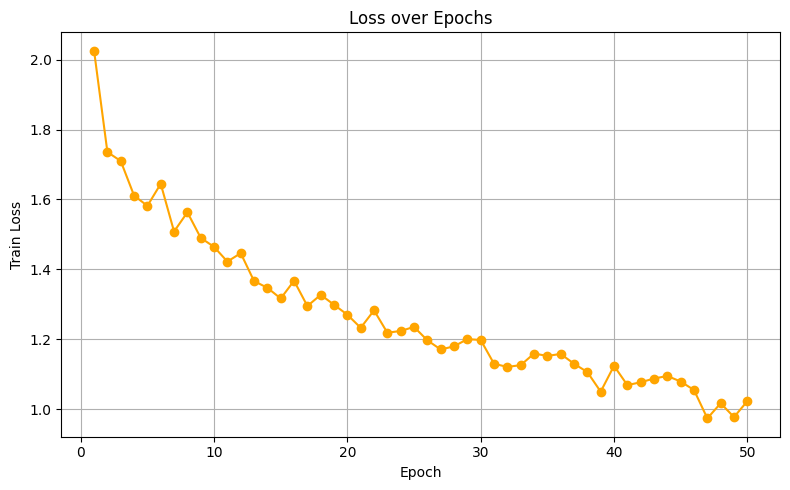

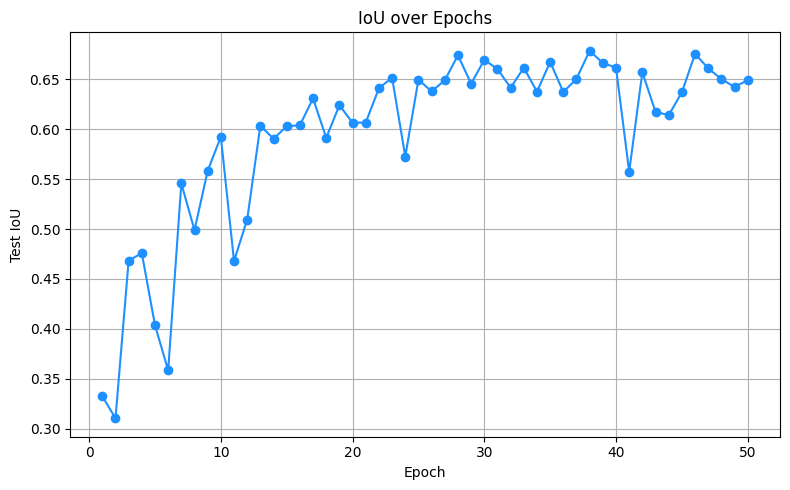

CPU times: user 25min 4s, sys: 29.3 s, total: 25min 34s
Wall time: 26min 40s


In [16]:
%%time

import matplotlib.pyplot as plt

def train():
    model.train()
    loss_list = []
    acc_list = []
    total_loss = correct_nodes = total_nodes = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.pos, data.batch, data.ptr)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct_nodes += out.argmax(dim=1).eq(data.y).sum().item()
        total_nodes += data.num_nodes

        if (i + 1) % 10 == 0:
            tloss = total_loss / 10
            tacc = correct_nodes / total_nodes
            print(f'[{i+1}/{len(train_loader)}] Loss: {tloss:.4f} '
                  f'Train Acc: {tacc:.4f}')
            total_loss = correct_nodes = total_nodes = 0
            loss_list.append(tloss)
            acc_list.append(tacc)

    return np.mean(loss_list), np.mean(acc_list)

@torch.no_grad()
def test(loader):
    model.eval()

    ious, categories = [], []
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    for data in loader:
        data = data.to(device)
        outs = model(data.x, data.pos, data.batch, data.ptr)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)


            iou = jaccard_index(out[:, part].argmax(dim=-1), y_map[y],
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)
        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    return float(mean_iou.mean())  # Global IoU.

def plot_iou_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='dodgerblue')
    plt.title('IoU over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test IoU')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

iou_list = []
loss_list = []

best_iou = 0.0  # or float('-inf') if you're maximizing
best_model_path = "ranlanet.pth"

for epoch in range(1, 51):
    loss, acc = train()
    loss_list.append(loss)
    iou = test(test_loader)
    iou_list.append(iou)
    print(f'Epoch: {epoch:02d}, Test IoU: {iou:.4f}')
    plot_loss_over_epochs(loss_list)
    plot_iou_over_epochs(iou_list)
    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), best_model_path)
        print(f"  >> Best model saved at epoch {epoch} with IoU: {best_iou:.4f}")





In [17]:
print(max(iou_list))


0.6787557601928711


#Test


In [18]:
model.load_state_dict(torch.load("/content/ranlanet.pth"))

<All keys matched successfully>

In [19]:
import os
import numpy as np
from pathlib import Path

@torch.no_grad()
def predict_and_save_per_sample(loader, output_dir="results"):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    y_map = torch.empty(loader.dataset.num_classes, device=device).long()
    idx = 0  # sample index

    for data in loader:
        data = data.to(device)
        outs = model(data.x, data.pos, data.batch, data.ptr)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)  # assume input is point positions

        ys = data.y.split(sizes)
        categories = data.category.tolist()

        for x, out, y, category in zip(xs, outs.split(sizes), ys, categories):
            category_str = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category_str]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            y_pred = out[:, part].argmax(dim=-1)
            y_true = y_map[y]

            # Save as npz
            file_path = Path(output_dir) / f"sample_{idx:04d}.npz"
            np.savez_compressed(
                file_path,
                x=x.cpu().numpy(),             # 3D points
                y_true=y_true.cpu().numpy(),   # ground truth labels
                y_pred=y_pred.cpu().numpy()    # predicted labels
            )
            idx += 1

    print(f"Saved {idx} samples to: {output_dir}")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


gt_cmap = np.array([
    [0.121, 0.466, 0.705],  # Blue for class 0
    [1.000, 0.498, 0.054],  # Orange for class 1
])
pred_cmap = np.array([
    [0.054, 0.705, 0.054],  # Blue
    [1.000, 0.498, 0.054],  # Orange
])

def visualize_sample_npz(file_path):
    data = np.load(file_path)
    x = data['x']           # shape: (N, 3)
    y_true = data['y_true'] # shape: (N,)
    print(np.unique(y_true))
    y_pred = data['y_pred'] # shape: (N,)
    print(np.unique(y_pred))

    gt_colors = gt_cmap[y_true]
    pred_colors = pred_cmap[y_pred]

    fig = plt.figure(figsize=(12, 6))

    # --- Ground Truth ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.scatter(x[:, 0], x[:, 1], x[:, 2], c=gt_colors, s=5)
    ax1.set_title("Ground Truth Labels")
    ax1.axis('off')

    # --- Prediction ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(x[:, 0], x[:, 1], x[:, 2], c=pred_colors, s=5)
    ax2.set_title("Predicted Labels")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()




In [22]:

@torch.no_grad()
def eval_value(loader):
    model.eval()

    ious, categories = [], []
    correct, total = 0, 0  # For accuracy
    y_map = torch.empty(loader.dataset.num_classes, device=device).long()

    for data in loader:
        data = data.to(device)
        outs = model(data.x, data.pos, data.batch, data.ptr)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        for out, y, category in zip(outs.split(sizes), data.y.split(sizes),
                                    data.category.tolist()):
            category = list(BreakBad.seg_classes.keys())[category]
            part = BreakBad.seg_classes[category]
            part = torch.tensor(part, device=device)

            y_map[part] = torch.arange(part.size(0), device=device)

            pred = out[:, part].argmax(dim=-1)
            target = y_map[y]

            correct += (pred == target).sum().item()
            total += target.numel()

            iou = jaccard_index(pred, target,
                                num_classes=part.size(0), absent_score=1.0)
            ious.append(iou)

        categories.append(data.category)

    iou = torch.tensor(ious, device=device)
    category = torch.cat(categories, dim=0)

    mean_iou = scatter(iou, category, reduce='mean')  # Per-category IoU.
    accuracy = correct / total

    return accuracy, float(mean_iou.mean())  # Return both Accuracy and Mean IoU

In [23]:
acc, miou = eval_value(test_loader)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.8819, Mean IoU: 0.6782


In [24]:
predict_and_save_per_sample(test_loader)

Saved 549 samples to: results


Sample_0253.npz
[0 1]
[0 1]


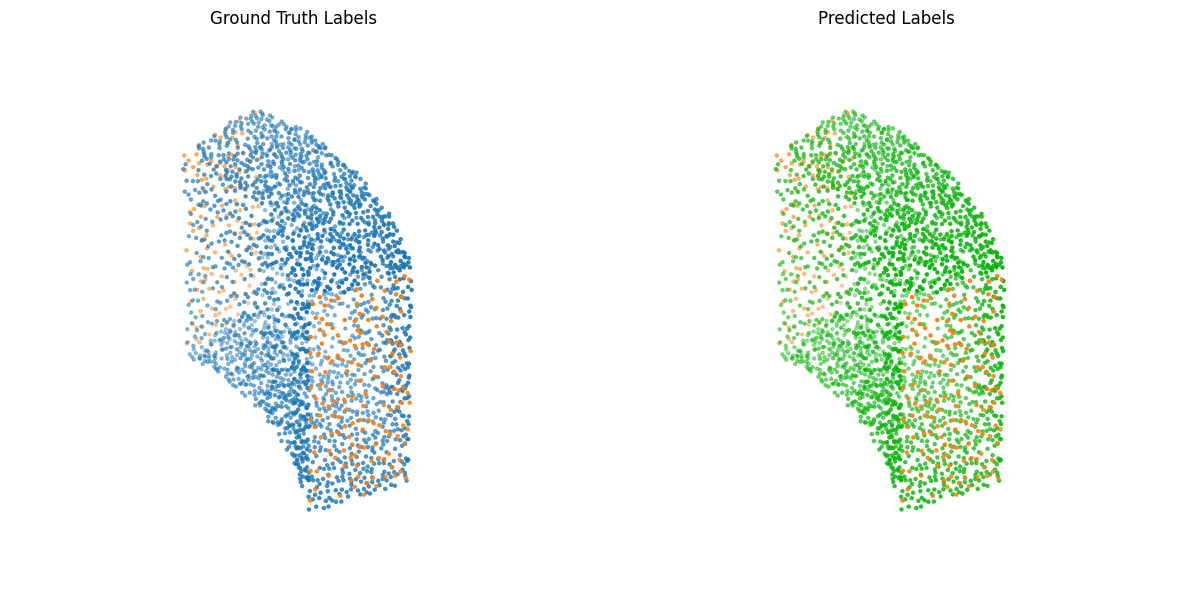

In [59]:
idx = random.randint(0, 549)
print(f"Sample_{idx:04d}.npz")
visualize_sample_npz(f"/content/results/sample_{idx:04d}.npz")

[0 1]
[0 1]


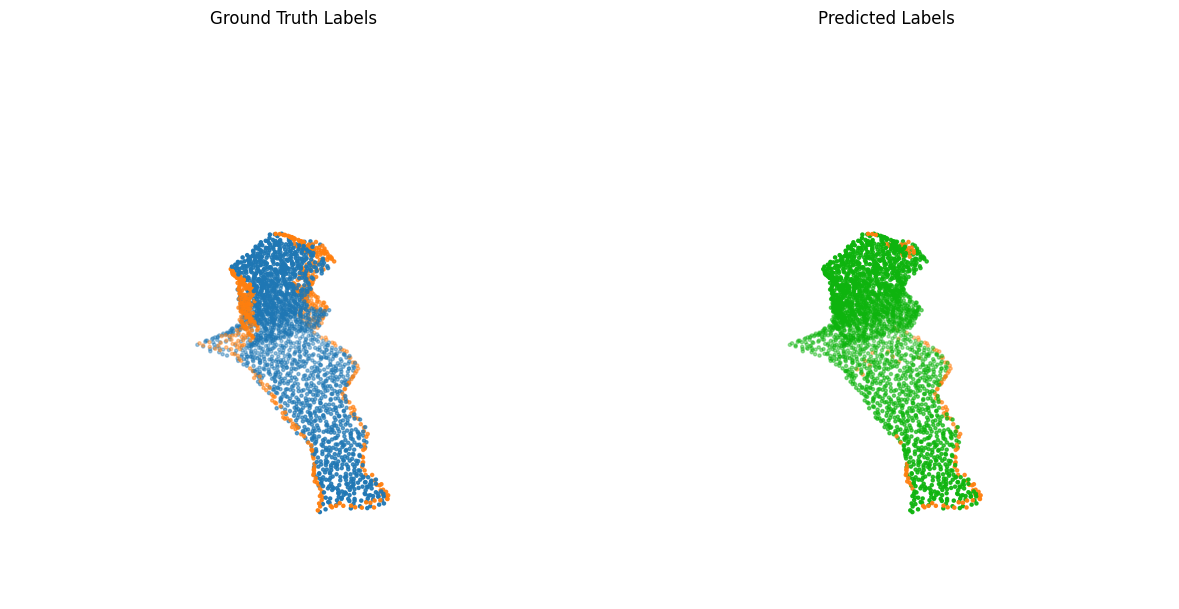

In [62]:
visualize_sample_npz(f"/content/results/sample_0100.npz")

[0 1]
[0]


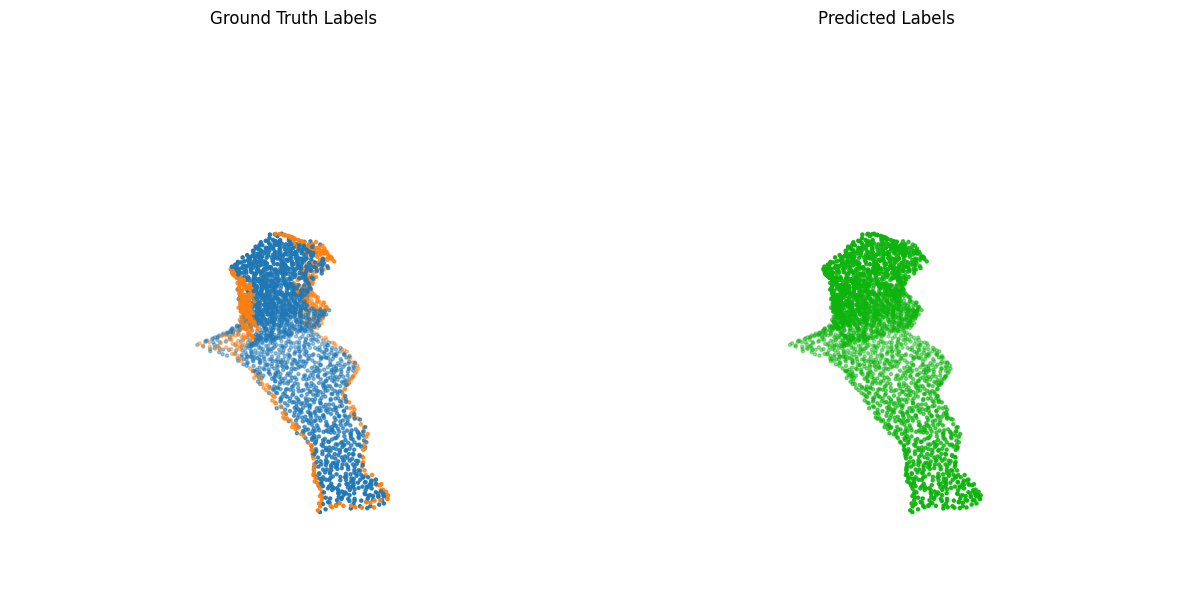

In [63]:
visualize_sample_npz(f"/content/sample_0100.npz")

In [60]:
name = "lanet_r"
!zip -r /content/drive/MyDrive/Test/{name}.zip /content/results

zip I/O error: No such file or directory
zip error: Could not create output file (/content/drive/MyDrive/Test/lanet_r.zip)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#fanta


In [64]:
!unzip /content/processed_fanta_1_obj.zip -d /content/temp_extract
!mkdir /content/data2
!mkdir /content/data2/raw
!mv /content/temp_extract/processed_fanta_1_obj/* /content/data2/raw
!rm -r /content/temp_extract

Archive:  /content/processed_fanta_1_obj.zip
   creating: /content/temp_extract/processed_fanta_1_obj/
   creating: /content/temp_extract/processed_fanta_1_obj/abc/
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00002.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00003.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00005.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00006.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00008.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00011.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00012.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00013.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00014.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00015.txt  
  inflating: /content/temp_extract/processed_fanta_1_obj/abc/00016.txt  
  inflating: /content/temp_extra

In [65]:

class FantaBrk(InMemoryDataset):
    r"""The ShapeNet part level segmentation dataset from the `"A Scalable
    Active Framework for Region Annotation in 3D Shape Collections"
    <http://web.stanford.edu/~ericyi/papers/part_annotation_16_small.pdf>`_
    paper, containing about 17,000 3D shape point clouds from 16 shape
    categories.
    Each category is annotated with 2 to 6 parts.

    Args:
        root (str): Root directory where the dataset should be saved.
        categories (str or [str], optional): The category of the CAD models
            (one or a combination of :obj:`"Airplane"`, :obj:`"Bag"`,
            :obj:`"Cap"`, :obj:`"Car"`, :obj:`"Chair"`, :obj:`"Earphone"`,
            :obj:`"Guitar"`, :obj:`"Knife"`, :obj:`"Lamp"`, :obj:`"Laptop"`,
            :obj:`"Motorbike"`, :obj:`"Mug"`, :obj:`"Pistol"`, :obj:`"Rocket"`,
            :obj:`"Skateboard"`, :obj:`"Table"`).
            Can be explicitly set to :obj:`None` to load all categories.
            (default: :obj:`None`)
        include_normals (bool, optional): If set to :obj:`False`, will not
            include normal vectors as input features to :obj:`data.x`.
            As a result, :obj:`data.x` will be :obj:`None`.
            (default: :obj:`True`)
        split (str, optional): If :obj:`"train"`, loads the training dataset.
            If :obj:`"val"`, loads the validation dataset.
            If :obj:`"trainval"`, loads the training and validation dataset.
            If :obj:`"test"`, loads the test dataset.
            (default: :obj:`"trainval"`)
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        force_reload (bool, optional): Whether to re-process the dataset.
            (default: :obj:`False`)

    **STATS:**

    .. list-table::
        :widths: 10 10 10 10 10
        :header-rows: 1

        * - #graphs
          - #nodes
          - #edges
          - #features
          - #classes
        * - 16,881
          - ~2,616.2
          - 0
          - 3
          - 50
    """

    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {'All_Statue': 'abc'}



    seg_classes = {'All_Statue': [0, 1]}

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {'abc': 0}
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [66]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data2"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset2 = FantaBrk(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset2 = FantaBrk(path, category, split='test',
                        pre_transform=pre_transform)
train_loader2 = DataLoader(train_dataset2, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader2 = DataLoader(test_dataset2, batch_size=12, shuffle=False,
                         num_workers=2)

['All_Statue']


Processing...


['All_Statue']


Done!


Unique classes [0 1]


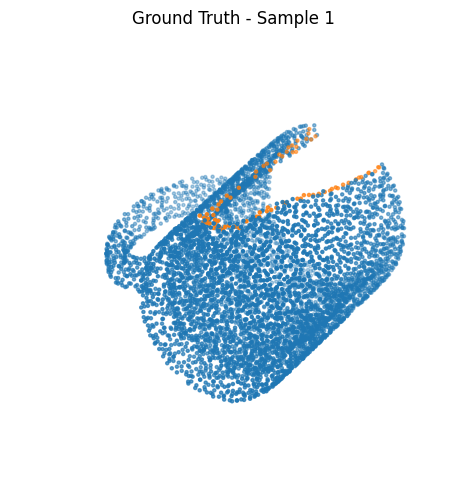

Unique classes [0 1]


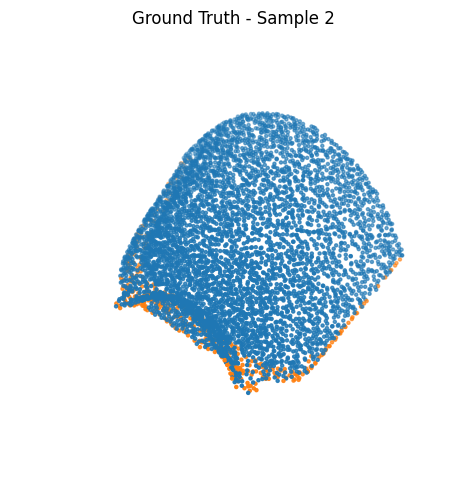

Unique classes [0 1]


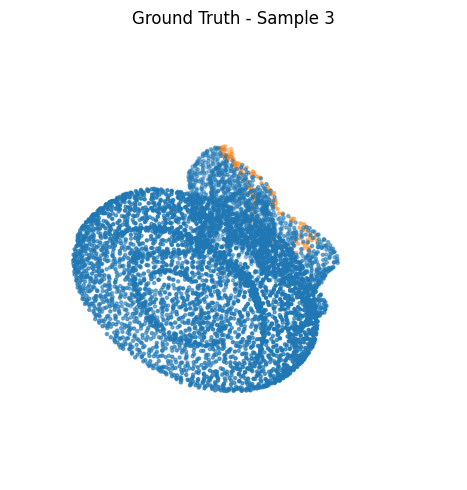

Unique classes [0 1]


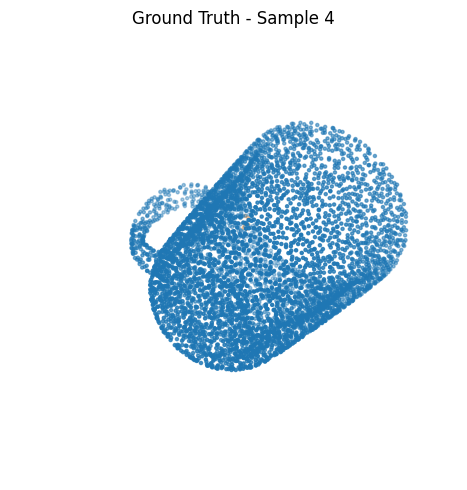

In [67]:
visualize_ground_truth_3d(test_loader2, num_samples=4)

In [68]:
acc, miou = eval_value(train_loader2)
print(f"Accuracy: {acc:.4f}, Mean IoU: {miou:.4f}")

Accuracy: 0.1306, Mean IoU: 0.0689


In [69]:
length = predict_and_save_per_sample(train_loader2,output_dir = "fanta_result")

Saved 120 samples to: fanta_result


Sample_0043.npz
[0 1]
[0 1]


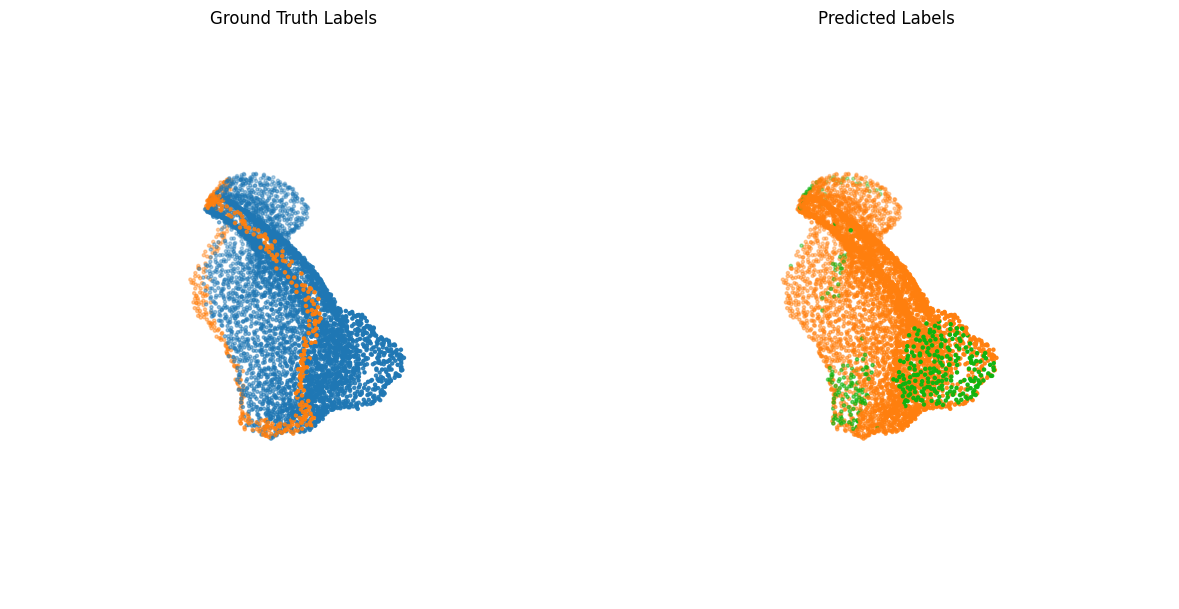

Sample_0115.npz
[0 1]
[0 1]


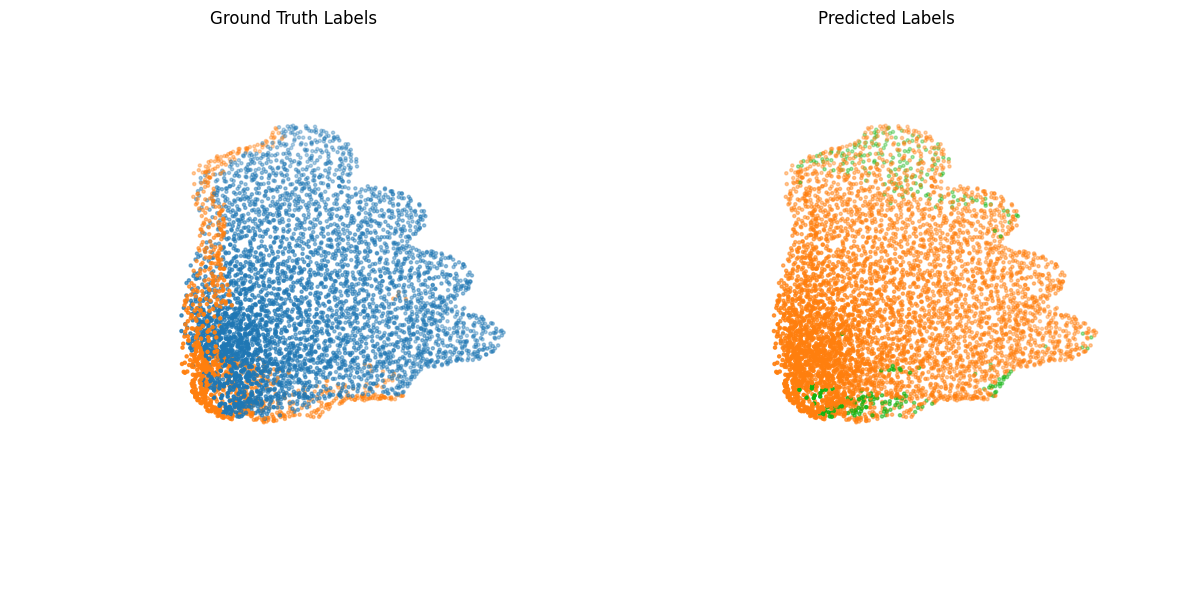

Sample_0097.npz
[0 1]
[0 1]


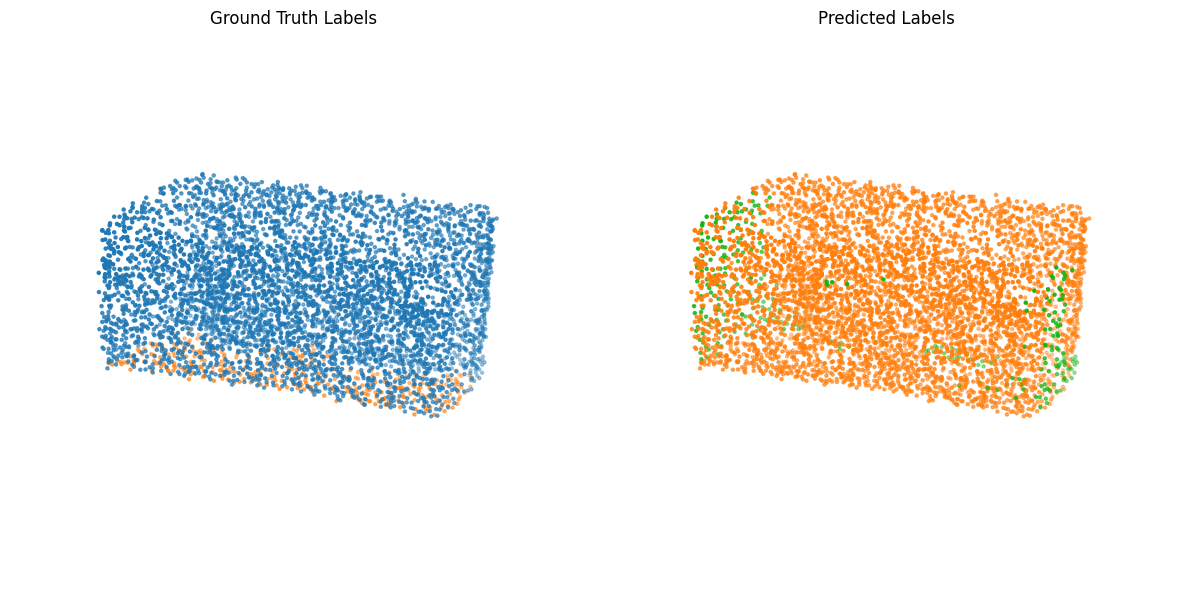

Sample_0040.npz
[0 1]
[0 1]


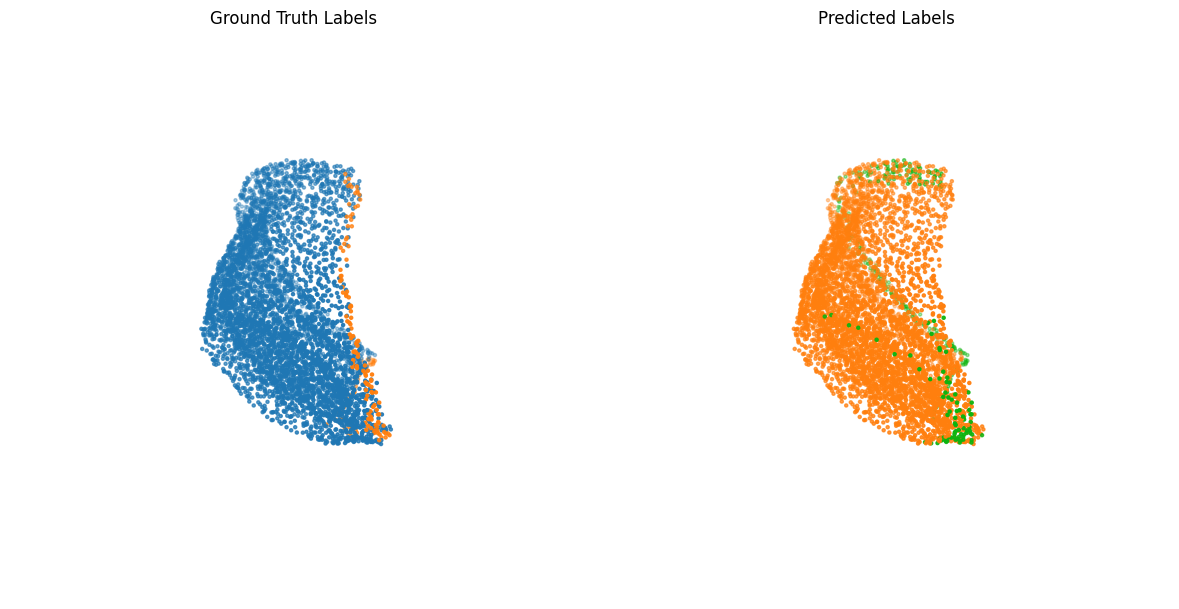

Sample_0007.npz
[0 1]
[0 1]


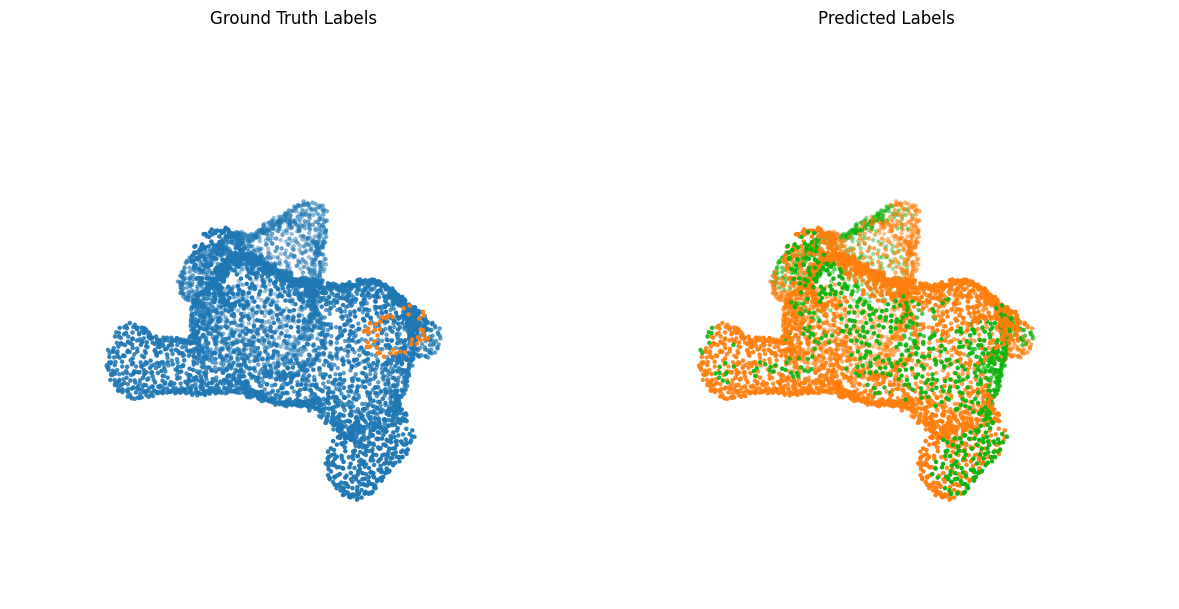

In [79]:
def wow2():
  idx = random.randint(0, 120)
  print(f"Sample_{idx:04d}.npz")
  visualize_sample_npz(f"/content/fanta_result/sample_{idx:04d}.npz")

wow2()

wow2()

wow2()
wow2()

wow2()

In [80]:
!mkdir -p output
!cp -r /content/break_result output/
!cp -r /content/fanta_result output/
!cp /content/ranlanet.pth output/
!zip -r ranlanet.zip output

from google.colab import files
files.download("ranlanet.zip")

  adding: output/ (stored 0%)
  adding: output/break_result/ (stored 0%)
  adding: output/break_result/sample_0463.npz (deflated 0%)
  adding: output/break_result/sample_0200.npz (deflated 0%)
  adding: output/break_result/sample_0333.npz (deflated 0%)
  adding: output/break_result/sample_0510.npz (deflated 0%)
  adding: output/break_result/sample_0210.npz (deflated 0%)
  adding: output/break_result/sample_0270.npz (deflated 0%)
  adding: output/break_result/sample_0344.npz (deflated 0%)
  adding: output/break_result/sample_0322.npz (deflated 0%)
  adding: output/break_result/sample_0230.npz (deflated 0%)
  adding: output/break_result/sample_0172.npz (deflated 0%)
  adding: output/break_result/sample_0308.npz (deflated 0%)
  adding: output/break_result/sample_0125.npz (deflated 0%)
  adding: output/break_result/sample_0394.npz (deflated 0%)
  adding: output/break_result/sample_0195.npz (deflated 0%)
  adding: output/break_result/sample_0260.npz (deflated 0%)
  adding: output/break_resu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>